## Package Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import easydict
import re
import os
import random
import torch
print(torch.cuda.is_available(), torch.cuda.device_count())

os.chdir('./code/') # 경로 설정
print(os.getcwd())

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from scipy.stats import f_oneway

# Wandb
import wandb
# wandb.login(key = 'Personal Key') # Personal Key 입력

# Catboost
import catboost
from catboost import CatBoostRegressor, Pool
print(f'CatBoost Version : {catboost.__version__}')

# Optuna
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from optuna.integration import CatBoostPruningCallback

from src.utils import Logger, Setting, rmse, models_load
from src.train.trainer import train, valid, test, RMSELoss

from src.data import context_data_load, context_data_split, context_data_loader # 'FM', 'FFM'에서 사용되는 데이터 처리 모듈
from src.data import dl_data_load, dl_data_split, dl_data_loader                # 'NCF', 'WDN', 'DCN'에서 사용되는 데이터 처리 모듈
from src.data import image_data_load, image_data_split, image_data_loader       # 'CNN_FM'에서 사용되는 데이터 처리 모듈
from src.data import text_data_load, text_data_split, text_data_loader          # 'DeepCoNN'에서 사용되는 데이터 처리 모듈

from src.models.FM.FM_model import FactorizationMachineModel
from src.models.FFM.FFM_model import FieldAwareFactorizationMachineModel
from src.models.WDN.WDN_model import WideAndDeepModel
from src.models.NCF.NCF_model import NeuralCollaborativeFiltering
from src.models.DCN.DCN_model import StackedDeepCrossNetworkModel, ParallelDeepCrossNetworkModel
from src.models.CNN_FM.CNN_FM_model import CNN_FM
from src.models.DeepCoNN.DeepCoNN_model import DeepCoNN

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings(action = 'ignore')

# Seed 고정
SEED = 42
def seed_everything(seed) :
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True
    torch.use_deterministic_algorithms(True)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
seed_everything(SEED)

True 1
/data/ephemeral/Project/code
CatBoost Version : 1.2.2


## Data Load

![data](./code/data/Data_Schema.png)

In [2]:
path = './data/'
books = pd.read_csv(path + 'books.csv')
users = pd.read_csv(path + 'users.csv')
train_ratings = pd.read_csv(path + 'train_ratings.csv')
test_ratings = pd.read_csv(path + 'test_ratings.csv')

print(books.shape, users.shape, train_ratings.shape, test_ratings.shape)

(149570, 10) (68092, 3) (306795, 3) (76699, 3)


## `books`

In [3]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149569 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


In [4]:
def text_preprocessing(summary) :
    """
    Parameters
    ----------
    summary : pd.Series
        정규화와 같은 기본적인 전처리를 하기위한 텍스트 데이터를 입력합니다.
    ----------
    """
    summary = re.sub("[.,\'\"''""!?]", "", summary)
    summary = re.sub("[^0-9a-zA-Z\\s]", " ", summary)
    summary = re.sub("\s+", " ", summary)
    summary = summary.lower()
    return summary


### `isbn`
- https://sciencing.com/difference-isbn-13-isbn-10-5890031.html
- group identifier / publisher identifier / title identifier / and check digit로 구성
- Format : XX-XXXX-XXX-X

> **ISBN 확인**
- URL 정보를 사용해서 ISBN이 재대로 입력됐는지 확인

In [5]:
books['img_url_isbn'] = books['img_url'].apply(lambda x : x.split('/')[5].split('.')[0])
books[books['isbn'] != books['img_url_isbn']]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,img_url_isbn


In [6]:
books.drop(columns = 'img_url_isbn', inplace = True)

### `isbn_country`
- 도서의 발매 국적 추가

In [7]:
# isbn 국가 분류 추가
books['isbn_country'] = books['isbn'].apply(lambda x : x[:1])

### `book_author` 결측치 확인
- 실제 저자가 없는 책
- 동일한 `book_title`의 데이터도 없음
- => 동일한 `publisher`의 최빈값으로 대체

In [8]:
books[books['book_title'] == books.loc[books['book_author'].isna(), 'book_title'].values[0]]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,isbn_country
73737,0751352497,A+ Quiz Masters:01 Earth,NaN,1999.0,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,NaN,NaN,NaN,images/0751352497.01.THUMBZZZ.jpg,0


In [9]:
books.loc[books['book_title'] == books.loc[books['book_author'].isna(), 'book_title'].values[0], 'book_author'] = \
    books.loc[books['publisher'] == books.loc[books['book_author'].isna(), 'publisher'].values[0], 'book_author'].mode().values[0]
print(books['book_author'].isna().sum())

0


In [10]:
# 텍스트 전처리 진행
books["book_title"] = books["book_title"].apply(lambda x : text_preprocessing(x))
books["book_author"] = books["book_author"].apply(lambda x : text_preprocessing(x))
books["publisher"] = books["publisher"].apply(lambda x : text_preprocessing(x))

### `year_of_publication`
- 1970년 이전과 2000년 이후를 제회하고 5년 단위로 범주화

In [11]:
def preprocess_year(x) :
    if x <= 1970 :
        return 1970
    elif (x > 1970) and (x <= 1980) :
        return 1980
    elif (x > 1980) and (x <= 1985) :
        return 1985
    elif (x > 1985) and (x <= 1990) :
        return 1990
    elif (x > 1990) and (x <= 1995) :
        return 1995
    elif (x > 1995) and (x <= 2000) :
        return 2000
    else:
        return 2006
    
books['years'] = books['year_of_publication'].apply(preprocess_year)
books['years'].value_counts()

years
2000    46463
2006    35910
1995    32007
1990    17095
1985     9905
1980     6503
1970     1687
Name: count, dtype: int64

In [12]:
# ANOVA 수행
year_rating = pd.merge(books[['isbn', 'years']], train_ratings[['isbn', 'rating']], how = 'left', on = 'isbn').dropna()
result = f_oneway(*[group['rating'] for name, group in year_rating.groupby('years')])

# 결과 출력
print('------------------------- ANOVA TEST -------------------------')
print('H0 : 출판년도 그룹 간 Rating의 평균이 동일하다.')
print('H1 : 출판년도 그룹 간 Rating의 평균이 적어도 하나는 동일하지 않다.\n')

print(f'F-statistic : {result.statistic:.5f}')
print(f'p-value : {result.pvalue}\n')

# p-value를 기반으로 한 유의성 검정
alpha = 0.05
if result.pvalue < alpha :
    print('p-value < alpha이므로 유의수준 5% 하에서 H0를 기각한다. \n즉, 출판년도 그룹 간 Rating의 평균이 적어도 하나는 동일하지 않다.')
else:
    print('p-value > alpha이므로 유의수준 5% 하에서 H0를 기각할 수 없다. \n즉, 출판년도 그룹 간 Rating의 평균이 동일하다.')

------------------------- ANOVA TEST -------------------------
H0 : 출판년도 그룹 간 Rating의 평균이 동일하다.
H1 : 출판년도 그룹 간 Rating의 평균이 적어도 하나는 동일하지 않다.

F-statistic : 66.49107
p-value : 5.347374704534725e-83

p-value < alpha이므로 유의수준 5% 하에서 H0를 기각한다. 
즉, 출판년도 그룹 간 Rating의 평균이 적어도 하나는 동일하지 않다.


### `publisher`
- 결측치가 없어 기존 `publisher`를 그대로 사용

### `language`, `category`, `summary`
- `language` & `category` & `summary`가 모두 결측인 행 -> 67227행
- `language` & `summary`만 결측인 행 -> 67227 + 1624행

In [13]:
display(books.loc[books['language'].isna(), ['language', 'category', 'summary']])
display(books.loc[books['language'].isna() & books['category'].notnull()])
display(books.loc[books['language'].isna() & books['summary'].notnull()])

,language,category,summary
5,NaN,NaN,NaN
8,NaN,NaN,NaN
9,NaN,NaN,NaN
10,NaN,NaN,NaN
11,NaN,NaN,NaN
...,...,...,...
149560,NaN,NaN,NaN
149561,NaN,NaN,NaN
149564,NaN,NaN,NaN
149567,NaN,NaN,NaN


,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,isbn_country,years


,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,isbn_country,years


- `language`는 `isbn`의 region 정보를 활용하여 결측치 대체
- `isbn`의 2자리를 언어로 사용

In [14]:
region_code = set([code[:1] for code in books['isbn']])

for code in region_code :
    lang = books.loc[books['isbn'].str.startswith(str(code)), 'language']
    mode = lang.mode().iloc[0] if not lang.mode().empty else 'en'
    if len(mode) != 2:
        books.loc[(books['isbn'].str.startswith(str(code))), 'language'] = 'en'
    books.loc[(books['isbn'].str.startswith(str(code))) & (books['language'].isna()), 'language'] = mode

books['language'].isna().sum()

0

In [15]:
books['language'].value_counts()

language
en       134830
de         6566
es         4535
fr         3303
it          123
nl           67
pt           47
da           37
ca           23
ms           10
no            6
ja            3
la            3
ru            3
gl            3
ro            1
th            1
el            1
fa            1
eo            1
gd            1
ga            1
vi            1
zh-CN         1
zh-TW         1
ko            1
Name: count, dtype: int64

### `category`
- 상위 카테고리인 `category_high`를 생성

In [16]:
# 대괄호 삭제
books['category'] = books['category'].apply(lambda x : re.sub('[\W_]+',  ' ', str(x).lower()).strip())

category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category', 'count']
category_df.head()

,category,count
0,nan,68851
1,fiction,33016
2,juvenile fiction,5835
3,biography autobiography,3326
4,history,1927


In [17]:
books['category_high'] = books['category'].copy()

categories = ['garden', 'crafts', 'physics', 'adventure', 'music', 'fiction', 'nonfiction', 'science', 'science fiction', 'social', 'homicide', 
              'sociology', 'disease', 'religion', 'christian', 'philosophy', 'psycholog', 'mathemat', 'agricult', 'environmental',
              'business', 'poetry', 'drama', 'literary', 'travel', 'motion picture', 'children', 'cook', 'literature', 'electronic', 
              'humor', 'animal', 'bird', 'photograph', 'computer', 'house', 'ecology', 'family', 'architect', 'camp', 'criminal', 'language', 'india']

for category in categories :
    books.loc[books[books['category'].str.contains(category, na = False)].index, 'category_high'] = category
books['category'] = books['category']

In [18]:
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category', 'count']
category_high_df.head(10)

,category,count
0,nan,68851
1,fiction,39678
2,biography autobiography,3326
3,history,1927
4,religion,1824
5,nonfiction,1427
6,humor,1291
7,social,1271
8,business,1146
9,cook,1125


In [19]:
# 5개 이하인 항목은 others
others_list = category_high_df[category_high_df['count'] < 5]['category'].values
print(len(others_list))

books.loc[books[books['category_high'].isin(others_list)].index, 'category_high'] = 'others'

2856


In [20]:
books['category_high'] = books['category_high'].replace('nan', np.nan)
books['category_high'] = books['category_high'].replace('unknown', np.nan)
print(books['category_high'].isna().sum())

books['category_high'] = books['category_high'].fillna('fiction')

68851


In [21]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149570 non-null  object 
 7   category             149570 non-null  object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
 10  isbn_country         149570 non-null  object 
 11  years                149570 non-null  int64  
 12  category_high        149570 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 14.8+ MB


In [22]:
# books.to_csv('/home/code/data/books_preprocessed.csv', index = False)

## `users`

In [23]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


### `city`, `state`, `country`

In [24]:
users['location'] = users['location'].str.replace(r'[^a-zA-Z:,]', '', regex = True)

users['city'] = users['location'].apply(lambda x : x.split(',')[0].strip())
users['state'] = users['location'].apply(lambda x : x.split(',')[1].strip())
users['country'] = users['location'].apply(lambda x : x.split(',')[2].strip())

users = users.replace('na', np.nan)
users = users.replace('n/a', np.nan)
users = users.replace('', np.nan)

users[['location', 'city', 'state', 'country']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  68092 non-null  object
 1   city      67963 non-null  object
 2   state     64838 non-null  object
 3   country   65968 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


In [25]:
modify_location = users[(users['country'].isna()) & (users['city'].notnull())]['city'].values
location = users[(users['location'].str.contains('seattle'))&(users['country'].notnull())]['location'].value_counts().index[0]

location_list = []
for location in tqdm.tqdm(modify_location) :
    try :
        right_location = users[(users['location'].str.contains(location))&(users['country'].notnull())]['location'].value_counts().index[0]
        location_list.append(right_location)
    except :
        pass

for location in tqdm.tqdm(location_list) :
    users.loc[users[users['city'] == location.split(',')[0]].index, 'state'] = location.split(',')[1]
    users.loc[users[users['city'] == location.split(',')[0]].index, 'country'] = location.split(',')[2]

city2idx = {v : k for k, v in enumerate(users['city'].unique())}
state2idx = {v : k for k, v in enumerate(users['state'].unique())}
country2idx = {v : k for k, v in enumerate(users['country'].unique())}

users['city'] = users['city'].map(city2idx)
users['state'] = users['state'].map(state2idx)
users['country'] = users['country'].map(country2idx)

  0%|          | 0/2113 [00:00<?, ?it/s]

100%|██████████| 1963/1963 [00:19<00:00, 101.74it/s]


In [26]:
print(users['city'].nunique(), users['state'].nunique(), users['country'].nunique())

11959 1319 269


In [27]:
# country가 결측 / city 결측 X인 경우
cities = users[(users['city'].notnull()) & (users['country'].isna())]['city'].values

for city in tqdm.tqdm(cities) :
    try :
        country = users.loc[(users['location'].str.contains(city)), 'country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(city)) & (users['country'].isna()), 'country'] = country
    except :
        pass
    
# country가 결측 / state 결측 X인 경우
states = users[(users['state'].notnull()) & (users['country'].isna())]['state'].values

for state in tqdm.tqdm(states) :
    try :
        country = users.loc[(users['location'].str.contains(state)), 'country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(state)) & (users['country'].isna()), 'country'] = country
    except :
        pass

# 각 나라 별로 location의 최빈값으로 대체
countries_list = users['country'].value_counts()
for country in tqdm.tqdm(countries_list.index) :
    try :
        new_country = users.loc[(users['location'].str.contains(country)), 'country'].value_counts().index[0]
        users.loc[(users['location'].str.contains(country)) & (users['country'] == country), 
                  'country'] = new_country
    except :
        pass

0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 269/269 [00:00<00:00, 94179.28it/s]


In [28]:
print(users['country'].isna().sum())
users['country'].value_counts().to_frame()

0


,count
country,
2,45206
0,6525
9,3604
6,3148
11,1816
...,...
221,1
222,1
223,1


In [29]:
# 10개 이하의 country를 others로 변환
others = users['country'].value_counts()[users['country'].value_counts() < 10].index
for country in tqdm.tqdm(others) :
    try :
        users.loc[(users['country'] == country), 'country'] = 'others'
    except :
        pass

100%|██████████| 215/215 [00:00<00:00, 236.53it/s]


In [30]:
# 나머지 결측치에 대해서도 others로 변환
users['country'] = users['country'].fillna('others')
users['state'] = users['state'].fillna('others')
users['city'] = users['city'].fillna('others')
print(users['country'].nunique())

55


In [31]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
 3   city      68092 non-null  int64  
 4   state     68092 non-null  int64  
 5   country   68092 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 3.1+ MB


### `age`
- 10살 단위 연령대로 분할하여 `new_age` 변수 생성
- 청소년기는 3년 단위로 범주화, 이후에는 10년 단위로 범주화 진행
- 결측치는 평균 나이로 대체

In [32]:
labels = ['3-6','6-8','8-12','12-15','15-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
bins = [3, 6, 8, 12, 15, 18, 25, 34, 44, 54, 64, 74, 100]
    
users['age'] = users['age'].apply(lambda x : 100 if x > 100 else x)
users.loc[(users['age'] > 90), 'age'] = np.nan

users['age'] = users['age'].fillna(users['age'].mean())
users['age'] = users['age'].astype(np.int64)

users['new_age'] = pd.cut(users.age, bins, labels = labels, include_lowest = True)

In [33]:
# ANOVA 수행
user_rating = pd.merge(users[['user_id', 'new_age']], train_ratings[['user_id', 'rating']], how = 'left', on = 'user_id').dropna()
result = f_oneway(*[group['rating'] for name, group in user_rating.groupby('new_age')])

# 결과 출력
print('------------------------- ANOVA TEST -------------------------')
print('H0 : 연령대 간 Rating의 평균이 동일하다.')
print('H1 : 연령대 간 Rating의 평균이 적어도 하나는 동일하지 않다.\n')

print(f'F-statistic : {result.statistic:.5f}')
print(f'p-value : {result.pvalue}\n')

# p-value를 기반으로 한 유의성 검정
alpha = 0.05
if result.pvalue < alpha :
    print('p-value < alpha이므로 유의수준 5% 하에서 H0를 기각한다. \n즉, 연령대 간 Rating의 평균이 적어도 하나는 동일하지 않다.')
else:
    print('p-value > alpha이므로 유의수준 5% 하에서 H0를 기각할 수 없다. \n즉, H0 채택. 연령대 간 Rating의 평균이 동일하다.')

------------------------- ANOVA TEST -------------------------
H0 : 연령대 간 Rating의 평균이 동일하다.
H1 : 연령대 간 Rating의 평균이 적어도 하나는 동일하지 않다.

F-statistic : 182.34382
p-value : 0.0

p-value < alpha이므로 유의수준 5% 하에서 H0를 기각한다. 
즉, 연령대 간 Rating의 평균이 적어도 하나는 동일하지 않다.


In [34]:
users['new_age'].value_counts()

new_age
35-44    36493
25-34    10873
18-25     6791
45-54     5946
55-64     3394
15-18     2012
65-74     1109
12-15     1086
75+        197
8-12       143
6-8         34
3-6         14
Name: count, dtype: int64

In [35]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   user_id   68092 non-null  int64   
 1   location  68092 non-null  object  
 2   age       68092 non-null  int64   
 3   city      68092 non-null  int64   
 4   state     68092 non-null  int64   
 5   country   68092 non-null  object  
 6   new_age   68092 non-null  category
dtypes: category(1), int64(4), object(2)
memory usage: 3.2+ MB


In [36]:
# users.to_csv('/home/code/data/users_preprocessed.csv', index = False)

## `ratings`와 Merge

In [37]:
path = './data/'
books_pre = books.copy()
users_pre = users.copy()
train_ratings = pd.read_csv(path + 'train_ratings.csv')
test_ratings = pd.read_csv(path + 'test_ratings.csv')

print(books_pre.shape, users_pre.shape, train_ratings.shape, test_ratings.shape)

(149570, 13) (68092, 7) (306795, 3) (76699, 3)


In [38]:
display(books_pre.info(), users_pre.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149570 non-null  object 
 7   category             149570 non-null  object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
 10  isbn_country         149570 non-null  object 
 11  years                149570 non-null  int64  
 12  category_high        149570 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 14.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entr

None

None

In [40]:
books_final = books_pre[['isbn', 'book_title', 'book_author', 'language', 'years', 'publisher', 'category_high', 'isbn_country']]
users_final = users_pre[['user_id', 'city', 'state', 'country', 'new_age']]

In [41]:
train_ratings['index'] = train_ratings.index
train_df = pd.merge(books_final, train_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
train_df = pd.merge(users_final, train_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
train_df = train_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   user_id        306795 non-null  int64   
 1   city           306795 non-null  int64   
 2   state          306795 non-null  int64   
 3   country        306795 non-null  object  
 4   new_age        306795 non-null  category
 5   isbn           306795 non-null  object  
 6   book_title     306795 non-null  object  
 7   book_author    306795 non-null  object  
 8   language       306795 non-null  object  
 9   years          306795 non-null  float64 
 10  publisher      306795 non-null  object  
 11  category_high  306795 non-null  object  
 12  isbn_country   306795 non-null  object  
 13  rating         306795 non-null  float64 
dtypes: category(1), float64(2), int64(3), object(8)
memory usage: 30.7+ MB


In [42]:
test_ratings['index'] = test_ratings.index
test_df = pd.merge(books_final, test_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
test_df = pd.merge(users_final, test_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
test_df = test_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   user_id        76699 non-null  int64   
 1   city           76699 non-null  int64   
 2   state          76699 non-null  int64   
 3   country        76699 non-null  object  
 4   new_age        76699 non-null  category
 5   isbn           76699 non-null  object  
 6   book_title     76699 non-null  object  
 7   book_author    76699 non-null  object  
 8   language       76699 non-null  object  
 9   years          76699 non-null  float64 
 10  publisher      76699 non-null  object  
 11  category_high  76699 non-null  object  
 12  isbn_country   76699 non-null  object  
 13  rating         76699 non-null  float64 
dtypes: category(1), float64(2), int64(3), object(8)
memory usage: 7.7+ MB


### `review_counts`
- 유저의 책 리뷰 횟수를 추가
- train_df에 없던 유저는 리뷰 횟수를 0으로 변경

In [43]:
user_id_counts = train_df['user_id'].value_counts()

train_df['review_counts'] = train_df['user_id'].map(user_id_counts)
test_df['review_counts'] = test_df['user_id'].map(user_id_counts)
test_df['review_counts'] = test_df['review_counts'].fillna(0)

### Data Type Modify

In [46]:
cat_col = ['user_id', 'city', 'state', 'country', 'new_age', 'isbn', 'book_title',
           'book_author', 'language', 'publisher', 'category_high', 'isbn_country']
num_col = ['rating', 'review_counts']

for df in [train_df, test_df] :
    df['years'] = df['years'].astype('int').astype('str')
    for cat in cat_col :
        df[cat] = df[cat].astype('str')
    for num in num_col :
        df[num] = df[num].astype('int')

cat_col.append('years')

In [47]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        306795 non-null  object
 1   city           306795 non-null  object
 2   state          306795 non-null  object
 3   country        306795 non-null  object
 4   new_age        306795 non-null  object
 5   isbn           306795 non-null  object
 6   book_title     306795 non-null  object
 7   book_author    306795 non-null  object
 8   language       306795 non-null  object
 9   years          306795 non-null  object
 10  publisher      306795 non-null  object
 11  category_high  306795 non-null  object
 12  isbn_country   306795 non-null  object
 13  rating         306795 non-null  int64 
 14  review_counts  306795 non-null  int64 
dtypes: int64(2), object(13)
memory usage: 35.1+ MB


In [48]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        76699 non-null  object
 1   city           76699 non-null  object
 2   state          76699 non-null  object
 3   country        76699 non-null  object
 4   new_age        76699 non-null  object
 5   isbn           76699 non-null  object
 6   book_title     76699 non-null  object
 7   book_author    76699 non-null  object
 8   language       76699 non-null  object
 9   years          76699 non-null  object
 10  publisher      76699 non-null  object
 11  category_high  76699 non-null  object
 12  isbn_country   76699 non-null  object
 13  rating         76699 non-null  int64 
 14  review_counts  76699 non-null  int64 
dtypes: int64(2), object(13)
memory usage: 8.8+ MB


## Modeling

In [49]:
for col in cat_col :
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    for label in tqdm.tqdm((test_df[col].unique())) :
        if label not in le.classes_ : 
            le.classes_ = np.append(le.classes_, label)
    test_df[col] = le.transform(test_df[col])

100%|██████████| 7/7 [00:00<00:00, 37401.44it/s]


### Catboost

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df.drop(columns = 'rating'), train_df['rating'],
                                                      test_size = 0.05, random_state = SEED)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(291455, 14) (291455,) (15340, 14) (15340,)


In [ ]:
from optuna.integration import CatBoostPruningCallback

def objectiveCAT(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.1, 0.5]),
        'depth' : trial.suggest_int('depth', 1, 15),
        'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel', [1e-3, 0.01, 0.1, 0.5]),   
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    }

    if param['bootstrap_type'] == 'Bayesian' :
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli' :
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
        
    train_data = Pool(data = X_train, label = y_train, cat_features = cat_col)
    valid_data = Pool(data = X_valid, label = y_valid, cat_features = cat_col)
    
    model = CatBoostRegressor(**param, iterations = 5000, loss_function = 'RMSE', eval_metric = 'RMSE',
                              use_best_model = True, random_state = SEED, # task_type = 'GPU', devices = '0'
                              cat_features = [i for i in range(0, 13)])
    pruning_callback = CatBoostPruningCallback(trial, 'RMSE', eval_set_index = 1)
    cat_model = model.fit(train_data, eval_set = [train_data, valid_data], verbose = 500, use_best_model = True,
                          early_stopping_rounds = 100, callbacks = [pruning_callback])
    pruning_callback.check_pruned()
    
    score = mean_squared_error(y_valid, cat_model.predict(X_valid), squared = False)
    return score

In [ ]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveCAT(trial, X_train, y_train, X_valid, y_valid), n_trials = 50)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n') 

In [ ]:
X_data, y_data = train_df.drop(columns = 'rating'), train_df['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []
pred_df = pd.DataFrame()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) : 
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    train_data = Pool(data = X_train, label = y_train, cat_features = cat_col)
    valid_data = Pool(data = X_valid, label = y_valid, cat_features = cat_col)
    
    # Best Parameter 학습
    param = {'learning_rate' : 0.1, 'depth' : 11, 'colsample_bylevel' : 0.5, 'boosting_type' : 'Plain', 'bootstrap_type' : 'MVS'} # study.best_params
    
    cat_reg = CatBoostRegressor(**param, iterations = 5000, 
                                loss_function = 'RMSE', eval_metric = 'RMSE', 
                                use_best_model = True, random_state = SEED,
                                cat_features = [i for i in range(0, 13)])
    cat_reg.fit(train_data, eval_set = [train_data, valid_data], use_best_model = True,
                verbose = 500, early_stopping_rounds = 100)
    
    # Feature Importance 출력
    feature_importance = cat_reg.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    fig = plt.figure(figsize = (12, 6))
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align = 'center')
    plt.yticks(range(len(sorted_idx)), np.array(X_data.columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()
    
    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, cat_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score:.5f}')
    
    # Predict
    pred = cat_reg.predict(test_df.drop(['rating'], axis = 1))
    pred_df[f'pred_{fold}'] = pred
    
print(f'CatBoost RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

  0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 2.4018339	test: 2.3861068	test1: 2.3973673	best: 2.3973673 (0)	total: 708ms	remaining: 58m 59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.124233314
bestIteration = 263

Shrink model to first 264 iterations.
Valid Set 1 번째 Fold RMSE : 2.12423


 10%|█         | 1/10 [04:00<36:03, 240.38s/it]

0:	learn: 2.4022668	test: 2.3869523	test1: 2.3960262	best: 2.3960262 (0)	total: 496ms	remaining: 41m 18s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.119489323
bestIteration = 335

Shrink model to first 336 iterations.
Valid Set 2 번째 Fold RMSE : 2.11949


 20%|██        | 2/10 [08:51<36:00, 270.00s/it]

0:	learn: 2.4013956	test: 2.3865267	test1: 2.3962129	best: 2.3962129 (0)	total: 510ms	remaining: 42m 31s
500:	learn: 2.0259101	test: 1.6663322	test1: 2.1204190	best: 2.1199691 (421)	total: 5m 31s	remaining: 49m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.119969061
bestIteration = 421

Shrink model to first 422 iterations.
Valid Set 3 번째 Fold RMSE : 2.11997


 30%|███       | 3/10 [14:40<35:44, 306.42s/it]

0:	learn: 2.4022039	test: 2.3858918	test1: 2.3965489	best: 2.3965489 (0)	total: 582ms	remaining: 48m 29s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.127139518
bestIteration = 296

Shrink model to first 297 iterations.
Valid Set 4 번째 Fold RMSE : 2.12714


 40%|████      | 4/10 [18:59<28:45, 287.64s/it]

0:	learn: 2.4021273	test: 2.3878241	test1: 2.3983347	best: 2.3983347 (0)	total: 547ms	remaining: 45m 36s
500:	learn: 2.0200697	test: 1.6698160	test1: 2.1267280	best: 2.1265084 (481)	total: 5m 32s	remaining: 49m 47s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.126508444
bestIteration = 481

Shrink model to first 482 iterations.
Valid Set 5 번째 Fold RMSE : 2.12651


 50%|█████     | 5/10 [25:33<27:09, 325.82s/it]

0:	learn: 2.4008197	test: 2.3830444	test1: 2.3950871	best: 2.3950871 (0)	total: 483ms	remaining: 40m 12s
500:	learn: 2.0208102	test: 1.6717204	test1: 2.1272308	best: 2.1268484 (428)	total: 5m 31s	remaining: 49m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.126848409
bestIteration = 428

Shrink model to first 429 iterations.
Valid Set 6 번째 Fold RMSE : 2.12685


 60%|██████    | 6/10 [31:28<22:23, 335.85s/it]

0:	learn: 2.4013014	test: 2.3829263	test1: 2.3951905	best: 2.3951905 (0)	total: 365ms	remaining: 30m 23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.125212352
bestIteration = 333

Shrink model to first 334 iterations.
Valid Set 7 번째 Fold RMSE : 2.12521


 70%|███████   | 7/10 [36:17<16:01, 320.58s/it]

0:	learn: 2.4013481	test: 2.3831215	test1: 2.3961092	best: 2.3961092 (0)	total: 535ms	remaining: 44m 36s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.13270564
bestIteration = 349

Shrink model to first 350 iterations.
Valid Set 8 번째 Fold RMSE : 2.13271


 80%|████████  | 8/10 [41:16<10:27, 313.67s/it]

0:	learn: 2.4009507	test: 2.3831549	test1: 2.3952153	best: 2.3952153 (0)	total: 483ms	remaining: 40m 12s
500:	learn: 2.0191733	test: 1.6605207	test1: 2.1251098	best: 2.1246944 (414)	total: 5m 31s	remaining: 49m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.124694439
bestIteration = 414

Shrink model to first 415 iterations.
Valid Set 9 번째 Fold RMSE : 2.12469


 90%|█████████ | 9/10 [47:01<05:23, 323.42s/it]

0:	learn: 2.4007995	test: 2.3832501	test1: 2.3948019	best: 2.3948019 (0)	total: 510ms	remaining: 42m 30s
500:	learn: 2.0182169	test: 1.6665937	test1: 2.1257845	best: 2.1257373 (454)	total: 5m 30s	remaining: 49m 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.125637298
bestIteration = 504

Shrink model to first 505 iterations.
Valid Set 10 번째 Fold RMSE : 2.12564


100%|██████████| 10/10 [53:46<00:00, 322.68s/it]

CatBoost RMSE 평균 : 2.12524 



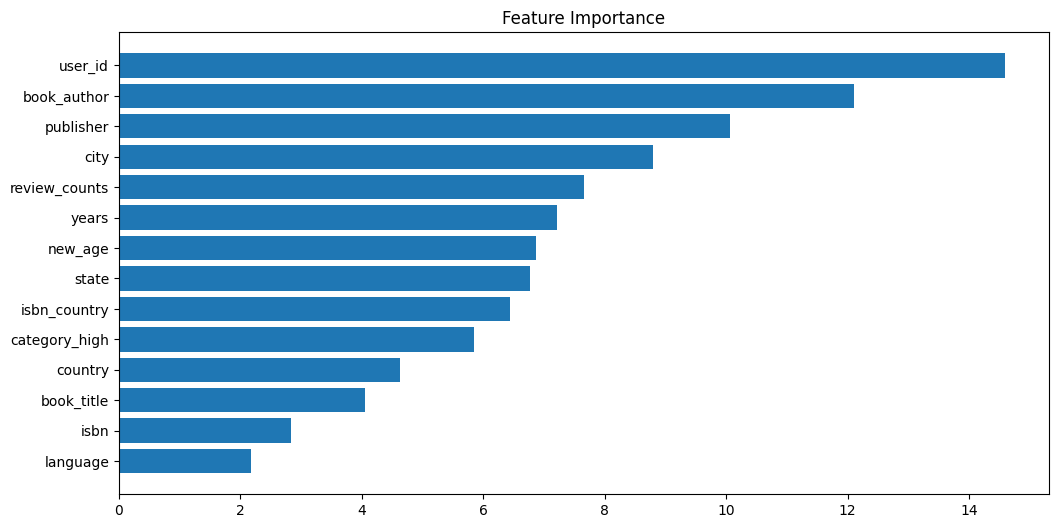

In [ ]:
feature_importance = cat_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize = (12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align = 'center')
plt.yticks(range(len(sorted_idx)), np.array(X_data.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [ ]:
test_ratings['rating'] = (pred_df['pred_0'] + pred_df['pred_1'] + pred_df['pred_2'] + pred_df['pred_3'] + pred_df['pred_4'] + 
                          pred_df['pred_5'] + pred_df['pred_6'] + pred_df['pred_7'] + pred_df['pred_8'] + pred_df['pred_9']) / 10
submit = test_ratings[['user_id', 'isbn', 'rating']]
submit

,user_id,isbn,rating
0,11676,0002005018,7.207394
1,116866,0002005018,7.231461
2,152827,0060973129,7.245058
3,157969,0374157065,7.563367
4,67958,0399135782,7.753247
...,...,...,...
76694,278543,1576734218,5.997184
76695,278563,3492223710,6.096248
76696,278633,1896095186,6.354181
76697,278668,8408044079,5.355587


In [ ]:
submit.to_csv('/home/code/submit/CB_HPO_Pred_punblisher.csv', index = False)

In [ ]:
# 파일 이름 변경 -> LB Score : 2.1226
# os.rename('/home/code/submit/CB_HPO_Pred_punblisher.csv', '/home/code/submit/Catboost_1226.csv')

### Deep Learning Model args

In [ ]:
args = easydict.EasyDict({
    'data_path' : './data/',  # Data path 설정
    'saved_pred_path' : './submit',
    'saved_model_path' : './saved_models',  # Saved Model path 설정
    'model' : None,  # 학습 및 예측할 모델 선택 (None으로 초기화, 사용 전에 설정 필요)
    'data_shuffle' : True,  # 데이터 셔플 여부 조정
    'test_size' : 0.1,  # Train/Valid split 비율 조정
    'seed' : 42,  # Seed 값 조정
    'use_best_model' : True,  # 검증 성능이 가장 좋은 모델 사용 여부 설정
    'patience' : 10, # Earlystop의 patience를 조정
    'runname' : None,

    # TRAINING OPTION
    'batch_size' : 256,  # Batch size 조정
    'epochs' : 30,  # Epoch 수 조정
    'lr' : 1e-3,  # Learning Rate 조정
    'loss_fn' : 'RMSE',  # 손실 함수 변경 (MSE 또는 RMSE)
    'optimizer' : 'NAdam',  # 최적화 함수 변경 (SGD, Adam, AdamW, NAdam, SparseAdam)
    'weight_decay' : 1e-6,  # Adam optimizer에서 정규화에 사용하는 값 조정
    'lr_scheduler' : None, # Learning Rate Scheduler 설정

    # GPU
    'device' : 'cuda',  # 학습에 사용할 Device 조정

    # FM, FFM, NCF, WDN, DCN Common OPTION
    'embed_dim' : 16,  # FM, FFM, NCF, WDN, DCN에서 embedding시킬 차원 조정
    'dropout' : 0.2,  # NCF, WDN, DCN에서 Dropout rate 조정
    'mlp_dims' : (16, 16),  # NCF, WDN, DCN에서 MLP Network의 차원 조정

    # DCN
    'num_layers' : 5,  # Cross Network의 레이어 수 조정

    # CNN_FM
    'cnn_embed_dim' : 64,  # CNN_FM에서 user와 item에 대한 embedding시킬 차원 조정
    'cnn_latent_dim' : 12,  # CNN_FM에서 user/item/image에 대한 latent 차원 조정

    # DeepCoNN
    'vector_create' : False,  # DEEP_CONN에서 text vector 생성 여부 조정 (최초 학습에만 True로 설정)
    'deepconn_embed_dim' : 32,  # DEEP_CONN에서 user와 item에 대한 embedding시킬 차원 조정
    'deepconn_latent_dim' : 10,  # DEEP_CONN에서 user/item/image에 대한 latent 차원 조정
    'conv_1d_out_dim' : 50,  # DEEP_CONN에서 1D conv의 출력 크기 조정
    'kernel_size' : 3,  # DEEP_CONN에서 1D conv의 kernel 크기 조정
    'word_dim' : 768,  # DEEP_CONN에서 1D conv의 입력 크기 조정
    'out_dim' : 32  # DEEP_CONN에서 1D conv의 출력 크기 조정
})

### CNN_FM

In [ ]:
def objective_CNN_FM(trial : Trial, dataset) :
    
    # Setting for Log
    setting = Setting()
    setting.seed_everything(SEED)

    log_path = setting.get_log_path(args)
    setting.make_dir(log_path)

    logger = Logger(args, log_path)
    logger.save_args()
    
    args.runname = 'CNN_FM_HPO'
    
    # wandb
    wandb.init(project = 'Book_Recommendation')
    wandb.run.name = args.runname + str(trial)
    wandb.run.save()
    wandb.config.update(args)
    
    # Common Parameter
    args.batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024])
    args.lr = trial.suggest_categorical('lr', [1e-3, 0.01, 0.1, 0.5])
    args.optimizer = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'AdamW', 'NAdam'])
    args.weight_decay = trial.suggest_categorical('weight_decay', [1e-7, 5e-7, 1e-6, 5e-6, 1e-5])
    
    # CNN_FM Parameter
    args.cnn_embed_dim = trial.suggest_int('cnn_embed_dim', 16, 64)
    args.cnn_latent_dim = trial.suggest_int('cnn_latent_dim', 8, 16)

    args.model = 'CNN_FM'
    args.loss_fn = 'RMSE'
    args.epochs = 30
    
    data = image_data_split(args, dataset)
    data = image_data_loader(args, dataset)
    
    model = CNN_FM(args, data).to(args.device)
    model, minimum_loss = train(args, model, data, logger, setting)
    return minimum_loss

In [ ]:
CNN_FM_Dataset = image_data_load(args)

129777it [01:00, 2159.96it/s]
52000it [00:24, 2135.16it/s]


In [ ]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objective_CNN_FM(trial, CNN_FM_Dataset), n_trials = 50, show_progress_bar = True)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

[I 2023-12-19 23:31:16,168] A new study created in memory with name: no-name-b1aba7e5-0910-4dc3-a0a8-5c2fe03996bf
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  3%|▎         | 1/30 [00:15<07:17, 15.10s/it]

Epoch : 1, Train Loss : 2.679, Valid Loss : 2.418, LR : 0.001, EarlyStop Count : 0


  7%|▋         | 2/30 [00:29<06:46, 14.52s/it]

Epoch : 2, Train Loss : 2.381, Valid Loss : 2.366, LR : 0.001, EarlyStop Count : 0


 10%|█         | 3/30 [00:42<06:21, 14.12s/it]

Epoch : 3, Train Loss : 2.337, Valid Loss : 2.346, LR : 0.001, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:56<06:04, 14.01s/it]

Epoch : 4, Train Loss : 2.306, Valid Loss : 2.323, LR : 0.001, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:10<05:47, 13.90s/it]

Epoch : 5, Train Loss : 2.283, Valid Loss : 2.310, LR : 0.001, EarlyStop Count : 0


 20%|██        | 6/30 [01:24<05:33, 13.88s/it]

Epoch : 6, Train Loss : 2.264, Valid Loss : 2.292, LR : 0.001, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:38<05:23, 14.04s/it]

Epoch : 7, Train Loss : 2.247, Valid Loss : 2.279, LR : 0.001, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:52<05:07, 13.97s/it]

Epoch : 8, Train Loss : 2.232, Valid Loss : 2.271, LR : 0.001, EarlyStop Count : 0


 30%|███       | 9/30 [02:06<04:53, 13.96s/it]

Epoch : 9, Train Loss : 2.218, Valid Loss : 2.267, LR : 0.001, EarlyStop Count : 0


 33%|███▎      | 10/30 [02:20<04:38, 13.91s/it]

Epoch : 10, Train Loss : 2.205, Valid Loss : 2.256, LR : 0.001, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:34<04:24, 13.92s/it]

Epoch : 11, Train Loss : 2.193, Valid Loss : 2.254, LR : 0.001, EarlyStop Count : 0


 40%|████      | 12/30 [02:48<04:10, 13.93s/it]

Epoch : 12, Train Loss : 2.181, Valid Loss : 2.242, LR : 0.001, EarlyStop Count : 0


 43%|████▎     | 13/30 [03:02<04:00, 14.17s/it]

Epoch : 13, Train Loss : 2.170, Valid Loss : 2.238, LR : 0.001, EarlyStop Count : 0


 47%|████▋     | 14/30 [03:17<03:47, 14.19s/it]

Epoch : 14, Train Loss : 2.159, Valid Loss : 2.234, LR : 0.001, EarlyStop Count : 0


 50%|█████     | 15/30 [03:32<03:36, 14.44s/it]

Epoch : 15, Train Loss : 2.148, Valid Loss : 2.228, LR : 0.001, EarlyStop Count : 0


 53%|█████▎    | 16/30 [03:47<03:24, 14.62s/it]

Epoch : 16, Train Loss : 2.136, Valid Loss : 2.225, LR : 0.001, EarlyStop Count : 0


 57%|█████▋    | 17/30 [04:02<03:13, 14.86s/it]

Epoch : 17, Train Loss : 2.125, Valid Loss : 2.223, LR : 0.001, EarlyStop Count : 0


 60%|██████    | 18/30 [04:17<02:57, 14.80s/it]

Epoch : 18, Train Loss : 2.115, Valid Loss : 2.216, LR : 0.001, EarlyStop Count : 0


 63%|██████▎   | 19/30 [04:30<02:39, 14.50s/it]

Epoch : 19, Train Loss : 2.104, Valid Loss : 2.211, LR : 0.001, EarlyStop Count : 0


 67%|██████▋   | 20/30 [04:44<02:23, 14.34s/it]

Epoch : 20, Train Loss : 2.093, Valid Loss : 2.208, LR : 0.001, EarlyStop Count : 0


 70%|███████   | 21/30 [04:58<02:07, 14.17s/it]

Epoch : 21, Train Loss : 2.083, Valid Loss : 2.205, LR : 0.001, EarlyStop Count : 0


 73%|███████▎  | 22/30 [05:12<01:52, 14.03s/it]

Epoch : 22, Train Loss : 2.074, Valid Loss : 2.201, LR : 0.001, EarlyStop Count : 0


 77%|███████▋  | 23/30 [05:26<01:37, 13.94s/it]

Epoch : 23, Train Loss : 2.064, Valid Loss : 2.203, LR : 0.001, EarlyStop Count : 1


 80%|████████  | 24/30 [05:39<01:23, 13.91s/it]

Epoch : 24, Train Loss : 2.055, Valid Loss : 2.197, LR : 0.001, EarlyStop Count : 0


 83%|████████▎ | 25/30 [05:53<01:08, 13.76s/it]

Epoch : 25, Train Loss : 2.044, Valid Loss : 2.194, LR : 0.001, EarlyStop Count : 0


 87%|████████▋ | 26/30 [06:07<00:55, 13.76s/it]

Epoch : 26, Train Loss : 2.033, Valid Loss : 2.199, LR : 0.001, EarlyStop Count : 1


 90%|█████████ | 27/30 [06:20<00:40, 13.67s/it]

Epoch : 27, Train Loss : 2.021, Valid Loss : 2.191, LR : 0.001, EarlyStop Count : 0


 93%|█████████▎| 28/30 [06:34<00:27, 13.66s/it]

Epoch : 28, Train Loss : 2.008, Valid Loss : 2.191, LR : 0.001, EarlyStop Count : 1


 97%|█████████▋| 29/30 [06:47<00:13, 13.66s/it]

Epoch : 29, Train Loss : 1.994, Valid Loss : 2.204, LR : 0.001, EarlyStop Count : 2


100%|██████████| 30/30 [07:01<00:00, 14.06s/it]

Epoch : 30, Train Loss : 1.979, Valid Loss : 2.187, LR : 0.001, EarlyStop Count : 0



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Train Loss,█▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
Valid Loss,█▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Best Loss,2.18723
Train Loss,1.9786
Valid Loss,2.18723


[I 2023-12-19 23:38:49,947] Trial 0 finished with value: 2.187231703599294 and parameters: {'batch_size': 512, 'lr': 0.001, 'optimizer': 'SGD', 'weight_decay': 1e-07, 'cnn_embed_dim': 30, 'cnn_latent_dim': 12}. Best is trial 0 with value: 2.187231703599294.


  3%|▎         | 1/30 [00:13<06:23, 13.24s/it]

Epoch : 1, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 1


  7%|▋         | 2/30 [00:27<06:19, 13.57s/it]

Epoch : 2, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 2


 10%|█         | 3/30 [00:40<06:00, 13.36s/it]

Epoch : 3, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 3


 13%|█▎        | 4/30 [00:53<05:45, 13.29s/it]

Epoch : 4, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 4


 17%|█▋        | 5/30 [01:06<05:27, 13.11s/it]

Epoch : 5, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 5


 17%|█▋        | 5/30 [01:19<06:37, 15.90s/it]

Epoch : 6, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 6
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁
Best Loss,999999999
Train Loss,inf
Valid Loss,inf


[I 2023-12-19 23:40:31,785] Trial 1 finished with value: 999999999.0 and parameters: {'batch_size': 1024, 'lr': 0.5, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 63, 'cnn_latent_dim': 15}. Best is trial 0 with value: 2.187231703599294.


  3%|▎         | 1/30 [00:13<06:28, 13.39s/it]

Epoch : 1, Train Loss : 3.436, Valid Loss : 2.393, LR : 0.1, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:16, 13.44s/it]

Epoch : 2, Train Loss : 2.375, Valid Loss : 2.375, LR : 0.1, EarlyStop Count : 0


 10%|█         | 3/30 [00:40<06:07, 13.62s/it]

Epoch : 3, Train Loss : 2.347, Valid Loss : 2.353, LR : 0.1, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:54<05:51, 13.54s/it]

Epoch : 4, Train Loss : 2.324, Valid Loss : 2.344, LR : 0.1, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:07<05:38, 13.52s/it]

Epoch : 5, Train Loss : 2.305, Valid Loss : 2.335, LR : 0.1, EarlyStop Count : 0


 20%|██        | 6/30 [01:21<05:23, 13.50s/it]

Epoch : 6, Train Loss : 2.287, Valid Loss : 2.324, LR : 0.1, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:34<05:09, 13.47s/it]

Epoch : 7, Train Loss : 2.267, Valid Loss : 2.316, LR : 0.1, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:48<04:57, 13.53s/it]

Epoch : 8, Train Loss : 2.247, Valid Loss : 2.306, LR : 0.1, EarlyStop Count : 0


 30%|███       | 9/30 [02:01<04:42, 13.45s/it]

Epoch : 9, Train Loss : 2.228, Valid Loss : 2.300, LR : 0.1, EarlyStop Count : 0


 33%|███▎      | 10/30 [02:14<04:24, 13.24s/it]

Epoch : 10, Train Loss : 2.209, Valid Loss : 2.305, LR : 0.1, EarlyStop Count : 1


 37%|███▋      | 11/30 [02:27<04:12, 13.27s/it]

Epoch : 11, Train Loss : 2.191, Valid Loss : 2.298, LR : 0.1, EarlyStop Count : 0


 40%|████      | 12/30 [02:40<03:59, 13.28s/it]

Epoch : 12, Train Loss : 2.173, Valid Loss : 2.289, LR : 0.1, EarlyStop Count : 0


 43%|████▎     | 13/30 [02:54<03:47, 13.41s/it]

Epoch : 13, Train Loss : 2.156, Valid Loss : 2.286, LR : 0.1, EarlyStop Count : 0


 47%|████▋     | 14/30 [03:08<03:35, 13.48s/it]

Epoch : 14, Train Loss : 2.139, Valid Loss : 2.286, LR : 0.1, EarlyStop Count : 0


 50%|█████     | 15/30 [03:21<03:19, 13.33s/it]

Epoch : 15, Train Loss : 2.121, Valid Loss : 2.286, LR : 0.1, EarlyStop Count : 1


 53%|█████▎    | 16/30 [03:34<03:06, 13.34s/it]

Epoch : 16, Train Loss : 2.105, Valid Loss : 2.283, LR : 0.1, EarlyStop Count : 0


 57%|█████▋    | 17/30 [03:48<02:56, 13.55s/it]

Epoch : 17, Train Loss : 2.088, Valid Loss : 2.283, LR : 0.1, EarlyStop Count : 1


 60%|██████    | 18/30 [04:02<02:42, 13.56s/it]

Epoch : 18, Train Loss : 2.071, Valid Loss : 2.283, LR : 0.1, EarlyStop Count : 2


 63%|██████▎   | 19/30 [04:15<02:27, 13.40s/it]

Epoch : 19, Train Loss : 2.054, Valid Loss : 2.288, LR : 0.1, EarlyStop Count : 3


 67%|██████▋   | 20/30 [04:28<02:13, 13.40s/it]

Epoch : 20, Train Loss : 2.037, Valid Loss : 2.284, LR : 0.1, EarlyStop Count : 4


 70%|███████   | 21/30 [04:41<02:00, 13.38s/it]

Epoch : 21, Train Loss : 2.022, Valid Loss : 2.288, LR : 0.1, EarlyStop Count : 5


 73%|███████▎  | 22/30 [04:55<01:48, 13.53s/it]

Epoch : 22, Train Loss : 2.004, Valid Loss : 2.288, LR : 0.1, EarlyStop Count : 6


 77%|███████▋  | 23/30 [05:09<01:34, 13.54s/it]

Epoch : 23, Train Loss : 1.990, Valid Loss : 2.291, LR : 0.1, EarlyStop Count : 7


 80%|████████  | 24/30 [05:22<01:21, 13.54s/it]

Epoch : 24, Train Loss : 1.970, Valid Loss : 2.295, LR : 0.1, EarlyStop Count : 8


 83%|████████▎ | 25/30 [05:37<01:08, 13.76s/it]

Epoch : 25, Train Loss : 1.958, Valid Loss : 2.298, LR : 0.1, EarlyStop Count : 9


 83%|████████▎ | 25/30 [05:50<01:10, 14.03s/it]

Epoch : 26, Train Loss : 1.939, Valid Loss : 2.301, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.283



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▇▅▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Valid Loss,█▇▅▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂
Best Loss,2.28253
Train Loss,1.93858
Valid Loss,2.30094


[I 2023-12-19 23:46:47,478] Trial 2 finished with value: 2.282532469431559 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'SGD', 'weight_decay': 5e-06, 'cnn_embed_dim': 62, 'cnn_latent_dim': 16}. Best is trial 0 with value: 2.187231703599294.


  3%|▎         | 1/30 [00:14<06:57, 14.39s/it]

Epoch : 1, Train Loss : 16483.059, Valid Loss : 983.493, LR : 0.5, EarlyStop Count : 0


  7%|▋         | 2/30 [00:28<06:41, 14.35s/it]

Epoch : 2, Train Loss : 5330.554, Valid Loss : 1898.174, LR : 0.5, EarlyStop Count : 1


 10%|█         | 3/30 [00:42<06:26, 14.32s/it]

Epoch : 3, Train Loss : 4534.659, Valid Loss : 4743.981, LR : 0.5, EarlyStop Count : 2


 13%|█▎        | 4/30 [00:57<06:12, 14.33s/it]

Epoch : 4, Train Loss : 7504.670, Valid Loss : 672.926, LR : 0.5, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:11<05:59, 14.37s/it]

Epoch : 5, Train Loss : 8672.813, Valid Loss : 849.166, LR : 0.5, EarlyStop Count : 1


 17%|█▋        | 5/30 [01:25<07:08, 17.15s/it]

Epoch : 6, Train Loss : 8932.847, Valid Loss : 2720.804, LR : 0.5, EarlyStop Count : 2
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,███▁▁▁
Train Loss,█▁▁▃▃▄
Valid Loss,▂▃█▁▁▅
Best Loss,672.92636
Train Loss,8932.8472
Valid Loss,2720.80389


[I 2023-12-19 23:48:43,869] Trial 3 finished with value: 672.9263580322265 and parameters: {'batch_size': 512, 'lr': 0.5, 'optimizer': 'Adam', 'weight_decay': 1e-05, 'cnn_embed_dim': 53, 'cnn_latent_dim': 9}. Best is trial 0 with value: 2.187231703599294.


  3%|▎         | 1/30 [00:14<06:57, 14.38s/it]

Epoch : 1, Train Loss : 2.508, Valid Loss : 2.214, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:28<06:41, 14.32s/it]

Epoch : 2, Train Loss : 1.916, Valid Loss : 2.256, LR : 0.01, EarlyStop Count : 1


 10%|█         | 3/30 [00:42<06:26, 14.31s/it]

Epoch : 3, Train Loss : 1.604, Valid Loss : 2.297, LR : 0.01, EarlyStop Count : 2


 13%|█▎        | 4/30 [00:57<06:12, 14.34s/it]

Epoch : 4, Train Loss : 1.392, Valid Loss : 2.334, LR : 0.01, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:12<06:02, 14.50s/it]

Epoch : 5, Train Loss : 1.220, Valid Loss : 2.376, LR : 0.01, EarlyStop Count : 4


 20%|██        | 6/30 [01:26<05:46, 14.45s/it]

Epoch : 6, Train Loss : 1.084, Valid Loss : 2.363, LR : 0.01, EarlyStop Count : 5


 23%|██▎       | 7/30 [01:41<05:32, 14.48s/it]

Epoch : 7, Train Loss : 0.986, Valid Loss : 2.376, LR : 0.01, EarlyStop Count : 6


 27%|██▋       | 8/30 [01:56<05:22, 14.67s/it]

Epoch : 8, Train Loss : 0.906, Valid Loss : 2.386, LR : 0.01, EarlyStop Count : 7


 30%|███       | 9/30 [02:10<05:06, 14.59s/it]

Epoch : 9, Train Loss : 0.846, Valid Loss : 2.391, LR : 0.01, EarlyStop Count : 8


 33%|███▎      | 10/30 [02:24<04:50, 14.52s/it]

Epoch : 10, Train Loss : 0.797, Valid Loss : 2.409, LR : 0.01, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:39<05:19, 15.95s/it]

Epoch : 11, Train Loss : 0.763, Valid Loss : 2.392, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.214



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▄▄▃▂▂▂▁▁▁
Valid Loss,▁▂▄▅▇▆▇▇▇█▇
Best Loss,2.21397
Train Loss,0.76328
Valid Loss,2.39175


[I 2023-12-19 23:51:50,937] Trial 4 finished with value: 2.2139694054921466 and parameters: {'batch_size': 512, 'lr': 0.01, 'optimizer': 'Adam', 'weight_decay': 5e-06, 'cnn_embed_dim': 59, 'cnn_latent_dim': 12}. Best is trial 0 with value: 2.187231703599294.


  3%|▎         | 1/30 [00:13<06:38, 13.75s/it]

Epoch : 1, Train Loss : 2.614, Valid Loss : 2.281, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:28<06:42, 14.39s/it]

Epoch : 2, Train Loss : 2.217, Valid Loss : 2.241, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:41<06:15, 13.92s/it]

Epoch : 3, Train Loss : 2.154, Valid Loss : 2.217, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:55<05:58, 13.80s/it]

Epoch : 4, Train Loss : 2.105, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:09<05:42, 13.68s/it]

Epoch : 5, Train Loss : 2.063, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:22<05:24, 13.54s/it]

Epoch : 6, Train Loss : 2.026, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:35<05:09, 13.45s/it]

Epoch : 7, Train Loss : 1.992, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:48<04:55, 13.42s/it]

Epoch : 8, Train Loss : 1.959, Valid Loss : 2.179, LR : 0.01, EarlyStop Count : 0


 30%|███       | 9/30 [02:02<04:41, 13.38s/it]

Epoch : 9, Train Loss : 1.927, Valid Loss : 2.174, LR : 0.01, EarlyStop Count : 0


 33%|███▎      | 10/30 [02:15<04:27, 13.37s/it]

Epoch : 10, Train Loss : 1.895, Valid Loss : 2.174, LR : 0.01, EarlyStop Count : 1


 37%|███▋      | 11/30 [02:28<04:11, 13.24s/it]

Epoch : 11, Train Loss : 1.862, Valid Loss : 2.174, LR : 0.01, EarlyStop Count : 2


 40%|████      | 12/30 [02:41<03:57, 13.19s/it]

Epoch : 12, Train Loss : 1.827, Valid Loss : 2.177, LR : 0.01, EarlyStop Count : 3


 43%|████▎     | 13/30 [02:54<03:43, 13.13s/it]

Epoch : 13, Train Loss : 1.790, Valid Loss : 2.185, LR : 0.01, EarlyStop Count : 4


 47%|████▋     | 14/30 [03:07<03:30, 13.13s/it]

Epoch : 14, Train Loss : 1.750, Valid Loss : 2.192, LR : 0.01, EarlyStop Count : 5


 50%|█████     | 15/30 [03:20<03:17, 13.18s/it]

Epoch : 15, Train Loss : 1.714, Valid Loss : 2.216, LR : 0.01, EarlyStop Count : 6


 53%|█████▎    | 16/30 [03:34<03:07, 13.37s/it]

Epoch : 16, Train Loss : 1.704, Valid Loss : 2.255, LR : 0.01, EarlyStop Count : 7


 57%|█████▋    | 17/30 [03:48<02:54, 13.43s/it]

Epoch : 17, Train Loss : 1.706, Valid Loss : 2.306, LR : 0.01, EarlyStop Count : 8


 60%|██████    | 18/30 [04:01<02:39, 13.32s/it]

Epoch : 18, Train Loss : 1.663, Valid Loss : 2.327, LR : 0.01, EarlyStop Count : 9


 60%|██████    | 18/30 [04:14<02:49, 14.15s/it]

Epoch : 19, Train Loss : 1.632, Valid Loss : 2.299, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.174



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁
Valid Loss,▆▄▃▂▂▂▁▁▁▁▁▁▂▂▃▅▇█▇
Best Loss,2.17361
Train Loss,1.63222
Valid Loss,2.29897


[I 2023-12-19 23:56:37,524] Trial 5 finished with value: 2.1736075003941853 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 5e-06, 'cnn_embed_dim': 36, 'cnn_latent_dim': 14}. Best is trial 5 with value: 2.1736075003941853.


  3%|▎         | 1/30 [00:13<06:26, 13.33s/it]

Epoch : 1, Train Loss : 2.527, Valid Loss : 2.287, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:14, 13.37s/it]

Epoch : 2, Train Loss : 1.906, Valid Loss : 2.244, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:39<05:58, 13.27s/it]

Epoch : 3, Train Loss : 1.625, Valid Loss : 2.296, LR : 0.01, EarlyStop Count : 1


 13%|█▎        | 4/30 [00:53<05:44, 13.24s/it]

Epoch : 4, Train Loss : 1.423, Valid Loss : 2.344, LR : 0.01, EarlyStop Count : 2


 17%|█▋        | 5/30 [01:06<05:33, 13.33s/it]

Epoch : 5, Train Loss : 1.245, Valid Loss : 2.354, LR : 0.01, EarlyStop Count : 3


 20%|██        | 6/30 [01:19<05:18, 13.28s/it]

Epoch : 6, Train Loss : 1.097, Valid Loss : 2.360, LR : 0.01, EarlyStop Count : 4


 23%|██▎       | 7/30 [01:33<05:05, 13.28s/it]

Epoch : 7, Train Loss : 0.974, Valid Loss : 2.391, LR : 0.01, EarlyStop Count : 5


 27%|██▋       | 8/30 [01:46<04:51, 13.26s/it]

Epoch : 8, Train Loss : 0.888, Valid Loss : 2.392, LR : 0.01, EarlyStop Count : 6


 30%|███       | 9/30 [01:59<04:38, 13.25s/it]

Epoch : 9, Train Loss : 0.809, Valid Loss : 2.387, LR : 0.01, EarlyStop Count : 7


 33%|███▎      | 10/30 [02:13<04:26, 13.35s/it]

Epoch : 10, Train Loss : 0.746, Valid Loss : 2.398, LR : 0.01, EarlyStop Count : 8


 37%|███▋      | 11/30 [02:26<04:12, 13.30s/it]

Epoch : 11, Train Loss : 0.701, Valid Loss : 2.400, LR : 0.01, EarlyStop Count : 9


 37%|███▋      | 11/30 [02:39<04:35, 14.49s/it]

Epoch : 12, Train Loss : 0.658, Valid Loss : 2.397, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.244



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▅▄▃▃▂▂▂▁▁▁
Valid Loss,▃▁▃▅▆▆██▇███
Best Loss,2.24375
Train Loss,0.6585
Valid Loss,2.39748


[I 2023-12-19 23:59:43,476] Trial 6 finished with value: 2.2437469244003294 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'NAdam', 'weight_decay': 1e-06, 'cnn_embed_dim': 27, 'cnn_latent_dim': 11}. Best is trial 5 with value: 2.1736075003941853.


  3%|▎         | 1/30 [00:14<06:50, 14.14s/it]

Epoch : 1, Train Loss : 2.625, Valid Loss : 2.217, LR : 0.001, EarlyStop Count : 0


  7%|▋         | 2/30 [00:28<06:35, 14.13s/it]

Epoch : 2, Train Loss : 1.878, Valid Loss : 2.248, LR : 0.001, EarlyStop Count : 1


 10%|█         | 3/30 [00:42<06:18, 14.01s/it]

Epoch : 3, Train Loss : 1.696, Valid Loss : 2.324, LR : 0.001, EarlyStop Count : 2


 13%|█▎        | 4/30 [00:56<06:05, 14.04s/it]

Epoch : 4, Train Loss : 1.603, Valid Loss : 2.323, LR : 0.001, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:10<05:51, 14.06s/it]

Epoch : 5, Train Loss : 1.540, Valid Loss : 2.336, LR : 0.001, EarlyStop Count : 4


 20%|██        | 6/30 [01:24<05:36, 14.03s/it]

Epoch : 6, Train Loss : 1.493, Valid Loss : 2.336, LR : 0.001, EarlyStop Count : 5


 23%|██▎       | 7/30 [01:38<05:23, 14.07s/it]

Epoch : 7, Train Loss : 1.453, Valid Loss : 2.362, LR : 0.001, EarlyStop Count : 6


 27%|██▋       | 8/30 [01:52<05:10, 14.10s/it]

Epoch : 8, Train Loss : 1.406, Valid Loss : 2.378, LR : 0.001, EarlyStop Count : 7


 30%|███       | 9/30 [02:06<04:55, 14.09s/it]

Epoch : 9, Train Loss : 1.353, Valid Loss : 2.380, LR : 0.001, EarlyStop Count : 8


 33%|███▎      | 10/30 [02:20<04:40, 14.01s/it]

Epoch : 10, Train Loss : 1.300, Valid Loss : 2.403, LR : 0.001, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:34<05:09, 15.47s/it]

Epoch : 11, Train Loss : 1.253, Valid Loss : 2.426, LR : 0.001, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.217



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▄▃▃▂▂▂▂▂▁▁
Valid Loss,▁▂▅▅▅▅▆▆▆▇█
Best Loss,2.21743
Train Loss,1.25274
Valid Loss,2.42629


[I 2023-12-20 00:02:40,761] Trial 7 finished with value: 2.2174341003100078 and parameters: {'batch_size': 512, 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 1e-06, 'cnn_embed_dim': 40, 'cnn_latent_dim': 10}. Best is trial 5 with value: 2.1736075003941853.


  3%|▎         | 1/30 [00:14<06:52, 14.22s/it]

Epoch : 1, Train Loss : 103794.007, Valid Loss : 41.103, LR : 0.5, EarlyStop Count : 0


  7%|▋         | 2/30 [00:28<06:46, 14.52s/it]

Epoch : 2, Train Loss : 30.160, Valid Loss : 11.144, LR : 0.5, EarlyStop Count : 0


 10%|█         | 3/30 [00:42<06:15, 13.92s/it]

Epoch : 3, Train Loss : 16644.421, Valid Loss : 29.361, LR : 0.5, EarlyStop Count : 1


 13%|█▎        | 4/30 [00:55<05:57, 13.76s/it]

Epoch : 4, Train Loss : 28.886, Valid Loss : 21.893, LR : 0.5, EarlyStop Count : 2


 17%|█▋        | 5/30 [01:08<05:39, 13.58s/it]

Epoch : 5, Train Loss : 23.545, Valid Loss : 21.814, LR : 0.5, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:22<06:51, 16.44s/it]

Epoch : 6, Train Loss : 17.581, Valid Loss : 16.404, LR : 0.5, EarlyStop Count : 4
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁
Train Loss,█▁▂▁▁▁
Valid Loss,█▁▅▄▃▂
Best Loss,11.14362
Train Loss,17.58058
Valid Loss,16.40438


[I 2023-12-20 00:04:29,259] Trial 8 finished with value: 11.143624305725098 and parameters: {'batch_size': 1024, 'lr': 0.5, 'optimizer': 'NAdam', 'weight_decay': 1e-06, 'cnn_embed_dim': 34, 'cnn_latent_dim': 13}. Best is trial 5 with value: 2.1736075003941853.


  3%|▎         | 1/30 [00:16<08:08, 16.84s/it]

Epoch : 1, Train Loss : 2.463, Valid Loss : 2.205, LR : 0.001, EarlyStop Count : 0


  7%|▋         | 2/30 [00:33<07:54, 16.96s/it]

Epoch : 2, Train Loss : 1.897, Valid Loss : 2.246, LR : 0.001, EarlyStop Count : 1


 10%|█         | 3/30 [00:50<07:39, 17.01s/it]

Epoch : 3, Train Loss : 1.699, Valid Loss : 2.281, LR : 0.001, EarlyStop Count : 2


 13%|█▎        | 4/30 [01:08<07:22, 17.03s/it]

Epoch : 4, Train Loss : 1.560, Valid Loss : 2.319, LR : 0.001, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:24<07:04, 16.98s/it]

Epoch : 5, Train Loss : 1.440, Valid Loss : 2.333, LR : 0.001, EarlyStop Count : 4


 20%|██        | 6/30 [01:41<06:45, 16.90s/it]

Epoch : 6, Train Loss : 1.328, Valid Loss : 2.370, LR : 0.001, EarlyStop Count : 5


 23%|██▎       | 7/30 [01:58<06:29, 16.93s/it]

Epoch : 7, Train Loss : 1.221, Valid Loss : 2.401, LR : 0.001, EarlyStop Count : 6


 27%|██▋       | 8/30 [02:16<06:16, 17.09s/it]

Epoch : 8, Train Loss : 1.112, Valid Loss : 2.435, LR : 0.001, EarlyStop Count : 7


 30%|███       | 9/30 [02:32<05:57, 17.03s/it]

Epoch : 9, Train Loss : 1.007, Valid Loss : 2.453, LR : 0.001, EarlyStop Count : 8


 33%|███▎      | 10/30 [02:49<05:39, 16.99s/it]

Epoch : 10, Train Loss : 0.911, Valid Loss : 2.468, LR : 0.001, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:06<06:13, 18.69s/it]

Epoch : 11, Train Loss : 0.830, Valid Loss : 2.473, LR : 0.001, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.205



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▅▄▄▃▃▂▂▁▁
Valid Loss,▁▂▃▄▄▅▆▇▇██
Best Loss,2.20465
Train Loss,0.8304
Valid Loss,2.47326


[I 2023-12-20 00:08:07,928] Trial 9 finished with value: 2.2046462098757424 and parameters: {'batch_size': 256, 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 5e-06, 'cnn_embed_dim': 61, 'cnn_latent_dim': 9}. Best is trial 5 with value: 2.1736075003941853.


  3%|▎         | 1/30 [00:15<07:41, 15.93s/it]

Epoch : 1, Train Loss : 2.322, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:32<07:28, 16.03s/it]

Epoch : 2, Train Loss : 1.915, Valid Loss : 2.248, LR : 0.01, EarlyStop Count : 1


 10%|█         | 3/30 [00:47<07:10, 15.94s/it]

Epoch : 3, Train Loss : 1.572, Valid Loss : 2.302, LR : 0.01, EarlyStop Count : 2


 13%|█▎        | 4/30 [01:04<07:00, 16.18s/it]

Epoch : 4, Train Loss : 1.322, Valid Loss : 2.321, LR : 0.01, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:20<06:46, 16.28s/it]

Epoch : 5, Train Loss : 1.148, Valid Loss : 2.350, LR : 0.01, EarlyStop Count : 4


 20%|██        | 6/30 [01:37<06:29, 16.25s/it]

Epoch : 6, Train Loss : 1.046, Valid Loss : 2.365, LR : 0.01, EarlyStop Count : 5


 23%|██▎       | 7/30 [01:53<06:18, 16.45s/it]

Epoch : 7, Train Loss : 0.979, Valid Loss : 2.360, LR : 0.01, EarlyStop Count : 6


 27%|██▋       | 8/30 [02:10<06:01, 16.43s/it]

Epoch : 8, Train Loss : 0.936, Valid Loss : 2.358, LR : 0.01, EarlyStop Count : 7


 30%|███       | 9/30 [02:26<05:40, 16.21s/it]

Epoch : 9, Train Loss : 0.906, Valid Loss : 2.367, LR : 0.01, EarlyStop Count : 8


 33%|███▎      | 10/30 [02:42<05:23, 16.20s/it]

Epoch : 10, Train Loss : 0.893, Valid Loss : 2.355, LR : 0.01, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:58<05:56, 17.82s/it]

Epoch : 11, Train Loss : 0.870, Valid Loss : 2.355, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.194



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▄▃▂▂▂▁▁▁▁
Valid Loss,▁▃▅▆▇██████
Best Loss,2.19391
Train Loss,0.86991
Valid Loss,2.35477


[I 2023-12-20 00:11:33,177] Trial 10 finished with value: 2.193906320134799 and parameters: {'batch_size': 256, 'lr': 0.01, 'optimizer': 'AdamW', 'weight_decay': 5e-07, 'cnn_embed_dim': 17, 'cnn_latent_dim': 14}. Best is trial 5 with value: 2.1736075003941853.


  3%|▎         | 1/30 [00:13<06:33, 13.57s/it]

Epoch : 1, Train Loss : 2.603, Valid Loss : 2.388, LR : 0.001, EarlyStop Count : 0


  7%|▋         | 2/30 [00:27<06:25, 13.77s/it]

Epoch : 2, Train Loss : 2.359, Valid Loss : 2.352, LR : 0.001, EarlyStop Count : 0


 10%|█         | 3/30 [00:41<06:14, 13.85s/it]

Epoch : 3, Train Loss : 2.323, Valid Loss : 2.327, LR : 0.001, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:55<06:03, 13.97s/it]

Epoch : 4, Train Loss : 2.297, Valid Loss : 2.308, LR : 0.001, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:09<05:48, 13.94s/it]

Epoch : 5, Train Loss : 2.276, Valid Loss : 2.293, LR : 0.001, EarlyStop Count : 0


 20%|██        | 6/30 [01:23<05:31, 13.81s/it]

Epoch : 6, Train Loss : 2.259, Valid Loss : 2.286, LR : 0.001, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:37<05:19, 13.90s/it]

Epoch : 7, Train Loss : 2.243, Valid Loss : 2.281, LR : 0.001, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:50<05:03, 13.81s/it]

Epoch : 8, Train Loss : 2.229, Valid Loss : 2.264, LR : 0.001, EarlyStop Count : 0


 30%|███       | 9/30 [02:04<04:49, 13.80s/it]

Epoch : 9, Train Loss : 2.217, Valid Loss : 2.262, LR : 0.001, EarlyStop Count : 0


 33%|███▎      | 10/30 [02:18<04:39, 13.97s/it]

Epoch : 10, Train Loss : 2.205, Valid Loss : 2.251, LR : 0.001, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:32<04:25, 13.95s/it]

Epoch : 11, Train Loss : 2.194, Valid Loss : 2.246, LR : 0.001, EarlyStop Count : 0


 40%|████      | 12/30 [02:47<04:13, 14.06s/it]

Epoch : 12, Train Loss : 2.184, Valid Loss : 2.248, LR : 0.001, EarlyStop Count : 1


 43%|████▎     | 13/30 [03:01<03:58, 14.04s/it]

Epoch : 13, Train Loss : 2.174, Valid Loss : 2.235, LR : 0.001, EarlyStop Count : 0


 47%|████▋     | 14/30 [03:14<03:43, 13.96s/it]

Epoch : 14, Train Loss : 2.165, Valid Loss : 2.231, LR : 0.001, EarlyStop Count : 0


 50%|█████     | 15/30 [03:29<03:31, 14.11s/it]

Epoch : 15, Train Loss : 2.156, Valid Loss : 2.227, LR : 0.001, EarlyStop Count : 0


 53%|█████▎    | 16/30 [03:43<03:17, 14.09s/it]

Epoch : 16, Train Loss : 2.148, Valid Loss : 2.224, LR : 0.001, EarlyStop Count : 0


 57%|█████▋    | 17/30 [03:57<03:03, 14.11s/it]

Epoch : 17, Train Loss : 2.140, Valid Loss : 2.229, LR : 0.001, EarlyStop Count : 1


 60%|██████    | 18/30 [04:11<02:48, 14.02s/it]

Epoch : 18, Train Loss : 2.132, Valid Loss : 2.219, LR : 0.001, EarlyStop Count : 0


 63%|██████▎   | 19/30 [04:25<02:35, 14.10s/it]

Epoch : 19, Train Loss : 2.125, Valid Loss : 2.215, LR : 0.001, EarlyStop Count : 0


 67%|██████▋   | 20/30 [04:39<02:19, 13.97s/it]

Epoch : 20, Train Loss : 2.118, Valid Loss : 2.211, LR : 0.001, EarlyStop Count : 0


 70%|███████   | 21/30 [04:53<02:05, 13.95s/it]

Epoch : 21, Train Loss : 2.110, Valid Loss : 2.209, LR : 0.001, EarlyStop Count : 0


 73%|███████▎  | 22/30 [05:06<01:51, 13.91s/it]

Epoch : 22, Train Loss : 2.103, Valid Loss : 2.206, LR : 0.001, EarlyStop Count : 0


 77%|███████▋  | 23/30 [05:20<01:37, 13.93s/it]

Epoch : 23, Train Loss : 2.096, Valid Loss : 2.208, LR : 0.001, EarlyStop Count : 1


 80%|████████  | 24/30 [05:34<01:23, 13.91s/it]

Epoch : 24, Train Loss : 2.089, Valid Loss : 2.204, LR : 0.001, EarlyStop Count : 0


 83%|████████▎ | 25/30 [05:48<01:09, 13.82s/it]

Epoch : 25, Train Loss : 2.083, Valid Loss : 2.200, LR : 0.001, EarlyStop Count : 0


 87%|████████▋ | 26/30 [06:02<00:55, 13.90s/it]

Epoch : 26, Train Loss : 2.076, Valid Loss : 2.198, LR : 0.001, EarlyStop Count : 0


 90%|█████████ | 27/30 [06:16<00:41, 13.96s/it]

Epoch : 27, Train Loss : 2.070, Valid Loss : 2.195, LR : 0.001, EarlyStop Count : 0


 93%|█████████▎| 28/30 [06:30<00:27, 13.92s/it]

Epoch : 28, Train Loss : 2.063, Valid Loss : 2.194, LR : 0.001, EarlyStop Count : 0


 97%|█████████▋| 29/30 [06:44<00:13, 13.91s/it]

Epoch : 29, Train Loss : 2.056, Valid Loss : 2.193, LR : 0.001, EarlyStop Count : 0


100%|██████████| 30/30 [06:58<00:00, 13.93s/it]

Epoch : 30, Train Loss : 2.050, Valid Loss : 2.190, LR : 0.001, EarlyStop Count : 0



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▇▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Train Loss,█▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Valid Loss,█▇▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Best Loss,2.18981
Train Loss,2.04961
Valid Loss,2.18981


[I 2023-12-20 00:18:57,601] Trial 11 finished with value: 2.1898067951202393 and parameters: {'batch_size': 512, 'lr': 0.001, 'optimizer': 'SGD', 'weight_decay': 1e-07, 'cnn_embed_dim': 28, 'cnn_latent_dim': 13}. Best is trial 5 with value: 2.1736075003941853.


  3%|▎         | 1/30 [00:13<06:39, 13.77s/it]

Epoch : 1, Train Loss : 9.345, Valid Loss : 2.297, LR : 0.1, EarlyStop Count : 0


  7%|▋         | 2/30 [00:27<06:19, 13.56s/it]

Epoch : 2, Train Loss : 2.203, Valid Loss : 2.239, LR : 0.1, EarlyStop Count : 0


 10%|█         | 3/30 [00:40<06:03, 13.47s/it]

Epoch : 3, Train Loss : 2.092, Valid Loss : 2.211, LR : 0.1, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:53<05:45, 13.30s/it]

Epoch : 4, Train Loss : 1.979, Valid Loss : 2.218, LR : 0.1, EarlyStop Count : 1


 17%|█▋        | 5/30 [01:06<05:30, 13.20s/it]

Epoch : 5, Train Loss : 1.866, Valid Loss : 2.236, LR : 0.1, EarlyStop Count : 2


 20%|██        | 6/30 [01:19<05:16, 13.19s/it]

Epoch : 6, Train Loss : 1.763, Valid Loss : 2.266, LR : 0.1, EarlyStop Count : 3


 23%|██▎       | 7/30 [01:32<05:02, 13.16s/it]

Epoch : 7, Train Loss : 1.679, Valid Loss : 2.295, LR : 0.1, EarlyStop Count : 4


 27%|██▋       | 8/30 [01:45<04:48, 13.12s/it]

Epoch : 8, Train Loss : 1.615, Valid Loss : 2.308, LR : 0.1, EarlyStop Count : 5


 30%|███       | 9/30 [01:59<04:35, 13.11s/it]

Epoch : 9, Train Loss : 1.570, Valid Loss : 2.319, LR : 0.1, EarlyStop Count : 6


 33%|███▎      | 10/30 [02:12<04:21, 13.10s/it]

Epoch : 10, Train Loss : 1.536, Valid Loss : 2.328, LR : 0.1, EarlyStop Count : 7


 37%|███▋      | 11/30 [02:25<04:09, 13.14s/it]

Epoch : 11, Train Loss : 1.509, Valid Loss : 2.354, LR : 0.1, EarlyStop Count : 8


 40%|████      | 12/30 [02:38<03:56, 13.12s/it]

Epoch : 12, Train Loss : 1.486, Valid Loss : 2.355, LR : 0.1, EarlyStop Count : 9


 40%|████      | 12/30 [02:51<04:17, 14.29s/it]

Epoch : 13, Train Loss : 1.467, Valid Loss : 2.356, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.211



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▃▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▂▁▁▁▁▁▁▁▁▁▁
Valid Loss,▅▂▁▁▂▄▅▆▆▇███
Best Loss,2.21058
Train Loss,1.46743
Valid Loss,2.35597


[I 2023-12-20 00:22:15,437] Trial 12 finished with value: 2.2105830272038776 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'SGD', 'weight_decay': 1e-07, 'cnn_embed_dim': 45, 'cnn_latent_dim': 12}. Best is trial 5 with value: 2.1736075003941853.


  3%|▎         | 1/30 [00:14<06:47, 14.05s/it]

Epoch : 1, Train Loss : 2.645, Valid Loss : 2.419, LR : 0.001, EarlyStop Count : 0


  7%|▋         | 2/30 [00:27<06:30, 13.93s/it]

Epoch : 2, Train Loss : 2.388, Valid Loss : 2.374, LR : 0.001, EarlyStop Count : 0


 10%|█         | 3/30 [00:41<06:15, 13.89s/it]

Epoch : 3, Train Loss : 2.349, Valid Loss : 2.351, LR : 0.001, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:55<05:58, 13.78s/it]

Epoch : 4, Train Loss : 2.322, Valid Loss : 2.329, LR : 0.001, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:09<05:45, 13.81s/it]

Epoch : 5, Train Loss : 2.301, Valid Loss : 2.317, LR : 0.001, EarlyStop Count : 0


 20%|██        | 6/30 [01:23<05:33, 13.91s/it]

Epoch : 6, Train Loss : 2.284, Valid Loss : 2.304, LR : 0.001, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:37<05:20, 13.92s/it]

Epoch : 7, Train Loss : 2.270, Valid Loss : 2.296, LR : 0.001, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:51<05:11, 14.17s/it]

Epoch : 8, Train Loss : 2.257, Valid Loss : 2.286, LR : 0.001, EarlyStop Count : 0


 30%|███       | 9/30 [02:05<04:53, 13.98s/it]

Epoch : 9, Train Loss : 2.244, Valid Loss : 2.284, LR : 0.001, EarlyStop Count : 0


 33%|███▎      | 10/30 [02:19<04:38, 13.95s/it]

Epoch : 10, Train Loss : 2.234, Valid Loss : 2.273, LR : 0.001, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:33<04:25, 13.95s/it]

Epoch : 11, Train Loss : 2.223, Valid Loss : 2.269, LR : 0.001, EarlyStop Count : 0


 40%|████      | 12/30 [02:47<04:10, 13.93s/it]

Epoch : 12, Train Loss : 2.214, Valid Loss : 2.261, LR : 0.001, EarlyStop Count : 0


 43%|████▎     | 13/30 [03:01<03:56, 13.91s/it]

Epoch : 13, Train Loss : 2.205, Valid Loss : 2.256, LR : 0.001, EarlyStop Count : 0


 47%|████▋     | 14/30 [03:15<03:45, 14.11s/it]

Epoch : 14, Train Loss : 2.198, Valid Loss : 2.252, LR : 0.001, EarlyStop Count : 0


 50%|█████     | 15/30 [03:30<03:35, 14.37s/it]

Epoch : 15, Train Loss : 2.189, Valid Loss : 2.248, LR : 0.001, EarlyStop Count : 0


 53%|█████▎    | 16/30 [03:44<03:20, 14.35s/it]

Epoch : 16, Train Loss : 2.181, Valid Loss : 2.247, LR : 0.001, EarlyStop Count : 0


 57%|█████▋    | 17/30 [03:59<03:06, 14.33s/it]

Epoch : 17, Train Loss : 2.174, Valid Loss : 2.241, LR : 0.001, EarlyStop Count : 0


 60%|██████    | 18/30 [04:12<02:49, 14.15s/it]

Epoch : 18, Train Loss : 2.167, Valid Loss : 2.238, LR : 0.001, EarlyStop Count : 0


 63%|██████▎   | 19/30 [04:27<02:35, 14.14s/it]

Epoch : 19, Train Loss : 2.160, Valid Loss : 2.234, LR : 0.001, EarlyStop Count : 0


 67%|██████▋   | 20/30 [04:40<02:20, 14.05s/it]

Epoch : 20, Train Loss : 2.153, Valid Loss : 2.232, LR : 0.001, EarlyStop Count : 0


 70%|███████   | 21/30 [04:54<02:05, 13.90s/it]

Epoch : 21, Train Loss : 2.147, Valid Loss : 2.229, LR : 0.001, EarlyStop Count : 0


 73%|███████▎  | 22/30 [05:08<01:51, 13.97s/it]

Epoch : 22, Train Loss : 2.140, Valid Loss : 2.227, LR : 0.001, EarlyStop Count : 0


 77%|███████▋  | 23/30 [05:22<01:37, 13.96s/it]

Epoch : 23, Train Loss : 2.135, Valid Loss : 2.223, LR : 0.001, EarlyStop Count : 0


 80%|████████  | 24/30 [05:36<01:23, 13.96s/it]

Epoch : 24, Train Loss : 2.129, Valid Loss : 2.222, LR : 0.001, EarlyStop Count : 0


 83%|████████▎ | 25/30 [05:50<01:09, 13.93s/it]

Epoch : 25, Train Loss : 2.123, Valid Loss : 2.220, LR : 0.001, EarlyStop Count : 0


 87%|████████▋ | 26/30 [06:03<00:55, 13.79s/it]

Epoch : 26, Train Loss : 2.117, Valid Loss : 2.216, LR : 0.001, EarlyStop Count : 0


 90%|█████████ | 27/30 [06:17<00:41, 13.86s/it]

Epoch : 27, Train Loss : 2.111, Valid Loss : 2.213, LR : 0.001, EarlyStop Count : 0


 93%|█████████▎| 28/30 [06:31<00:27, 13.75s/it]

Epoch : 28, Train Loss : 2.105, Valid Loss : 2.211, LR : 0.001, EarlyStop Count : 0


 97%|█████████▋| 29/30 [06:45<00:13, 13.79s/it]

Epoch : 29, Train Loss : 2.099, Valid Loss : 2.209, LR : 0.001, EarlyStop Count : 0


100%|██████████| 30/30 [06:58<00:00, 13.97s/it]

Epoch : 30, Train Loss : 2.093, Valid Loss : 2.208, LR : 0.001, EarlyStop Count : 0



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▇▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Train Loss,█▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Valid Loss,█▇▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Best Loss,2.20811
Train Loss,2.09329
Valid Loss,2.20811


[I 2023-12-20 00:29:47,289] Trial 13 finished with value: 2.208111504713694 and parameters: {'batch_size': 512, 'lr': 0.001, 'optimizer': 'SGD', 'weight_decay': 1e-07, 'cnn_embed_dim': 20, 'cnn_latent_dim': 14}. Best is trial 5 with value: 2.1736075003941853.


  3%|▎         | 1/30 [00:16<07:59, 16.53s/it]

Epoch : 1, Train Loss : 2.382, Valid Loss : 2.212, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:32<07:38, 16.36s/it]

Epoch : 2, Train Loss : 1.934, Valid Loss : 2.235, LR : 0.01, EarlyStop Count : 1


 10%|█         | 3/30 [00:49<07:23, 16.41s/it]

Epoch : 3, Train Loss : 1.612, Valid Loss : 2.312, LR : 0.01, EarlyStop Count : 2


 13%|█▎        | 4/30 [01:06<07:14, 16.70s/it]

Epoch : 4, Train Loss : 1.378, Valid Loss : 2.337, LR : 0.01, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:23<07:00, 16.81s/it]

Epoch : 5, Train Loss : 1.210, Valid Loss : 2.352, LR : 0.01, EarlyStop Count : 4


 20%|██        | 6/30 [01:41<06:52, 17.18s/it]

Epoch : 6, Train Loss : 1.108, Valid Loss : 2.353, LR : 0.01, EarlyStop Count : 5


 23%|██▎       | 7/30 [01:58<06:32, 17.04s/it]

Epoch : 7, Train Loss : 1.036, Valid Loss : 2.367, LR : 0.01, EarlyStop Count : 6


 27%|██▋       | 8/30 [02:14<06:13, 16.98s/it]

Epoch : 8, Train Loss : 0.994, Valid Loss : 2.368, LR : 0.01, EarlyStop Count : 7


 30%|███       | 9/30 [02:31<05:53, 16.85s/it]

Epoch : 9, Train Loss : 0.964, Valid Loss : 2.363, LR : 0.01, EarlyStop Count : 8


 33%|███▎      | 10/30 [02:47<05:32, 16.63s/it]

Epoch : 10, Train Loss : 0.937, Valid Loss : 2.365, LR : 0.01, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:04<06:08, 18.41s/it]

Epoch : 11, Train Loss : 0.917, Valid Loss : 2.373, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.212



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▄▃▂▂▂▁▁▁▁
Valid Loss,▁▂▅▆▇▇█████
Best Loss,2.21231
Train Loss,0.91721
Valid Loss,2.37266


[I 2023-12-20 00:33:17,910] Trial 14 finished with value: 2.212314306696256 and parameters: {'batch_size': 256, 'lr': 0.01, 'optimizer': 'AdamW', 'weight_decay': 5e-07, 'cnn_embed_dim': 35, 'cnn_latent_dim': 16}. Best is trial 5 with value: 2.1736075003941853.


  3%|▎         | 1/30 [00:13<06:22, 13.20s/it]

Epoch : 1, Train Loss : 3.522, Valid Loss : 2.477, LR : 0.001, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:12, 13.29s/it]

Epoch : 2, Train Loss : 2.426, Valid Loss : 2.393, LR : 0.001, EarlyStop Count : 0


 10%|█         | 3/30 [00:40<06:02, 13.44s/it]

Epoch : 3, Train Loss : 2.370, Valid Loss : 2.360, LR : 0.001, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:53<05:47, 13.37s/it]

Epoch : 4, Train Loss : 2.339, Valid Loss : 2.339, LR : 0.001, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:06<05:35, 13.42s/it]

Epoch : 5, Train Loss : 2.317, Valid Loss : 2.323, LR : 0.001, EarlyStop Count : 0


 20%|██        | 6/30 [01:20<05:21, 13.40s/it]

Epoch : 6, Train Loss : 2.298, Valid Loss : 2.312, LR : 0.001, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:33<05:08, 13.39s/it]

Epoch : 7, Train Loss : 2.283, Valid Loss : 2.301, LR : 0.001, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:47<04:54, 13.38s/it]

Epoch : 8, Train Loss : 2.269, Valid Loss : 2.293, LR : 0.001, EarlyStop Count : 0


 30%|███       | 9/30 [02:00<04:42, 13.46s/it]

Epoch : 9, Train Loss : 2.257, Valid Loss : 2.286, LR : 0.001, EarlyStop Count : 0


 33%|███▎      | 10/30 [02:14<04:28, 13.43s/it]

Epoch : 10, Train Loss : 2.246, Valid Loss : 2.278, LR : 0.001, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:27<04:13, 13.36s/it]

Epoch : 11, Train Loss : 2.236, Valid Loss : 2.273, LR : 0.001, EarlyStop Count : 0


 40%|████      | 12/30 [02:41<04:04, 13.56s/it]

Epoch : 12, Train Loss : 2.227, Valid Loss : 2.267, LR : 0.001, EarlyStop Count : 0


 43%|████▎     | 13/30 [02:54<03:49, 13.50s/it]

Epoch : 13, Train Loss : 2.218, Valid Loss : 2.262, LR : 0.001, EarlyStop Count : 0


 47%|████▋     | 14/30 [03:08<03:36, 13.51s/it]

Epoch : 14, Train Loss : 2.210, Valid Loss : 2.257, LR : 0.001, EarlyStop Count : 0


 50%|█████     | 15/30 [03:21<03:22, 13.49s/it]

Epoch : 15, Train Loss : 2.202, Valid Loss : 2.253, LR : 0.001, EarlyStop Count : 0


 53%|█████▎    | 16/30 [03:34<03:08, 13.46s/it]

Epoch : 16, Train Loss : 2.194, Valid Loss : 2.249, LR : 0.001, EarlyStop Count : 0


 57%|█████▋    | 17/30 [03:48<02:56, 13.56s/it]

Epoch : 17, Train Loss : 2.187, Valid Loss : 2.246, LR : 0.001, EarlyStop Count : 0


 60%|██████    | 18/30 [04:02<02:42, 13.51s/it]

Epoch : 18, Train Loss : 2.180, Valid Loss : 2.242, LR : 0.001, EarlyStop Count : 0


 63%|██████▎   | 19/30 [04:15<02:29, 13.55s/it]

Epoch : 19, Train Loss : 2.174, Valid Loss : 2.239, LR : 0.001, EarlyStop Count : 0


 67%|██████▋   | 20/30 [04:29<02:15, 13.53s/it]

Epoch : 20, Train Loss : 2.167, Valid Loss : 2.236, LR : 0.001, EarlyStop Count : 0


 70%|███████   | 21/30 [04:42<02:01, 13.51s/it]

Epoch : 21, Train Loss : 2.161, Valid Loss : 2.233, LR : 0.001, EarlyStop Count : 0


 73%|███████▎  | 22/30 [04:56<01:47, 13.46s/it]

Epoch : 22, Train Loss : 2.155, Valid Loss : 2.231, LR : 0.001, EarlyStop Count : 0


 77%|███████▋  | 23/30 [05:10<01:35, 13.69s/it]

Epoch : 23, Train Loss : 2.150, Valid Loss : 2.229, LR : 0.001, EarlyStop Count : 0


 80%|████████  | 24/30 [05:23<01:21, 13.62s/it]

Epoch : 24, Train Loss : 2.144, Valid Loss : 2.226, LR : 0.001, EarlyStop Count : 0


 83%|████████▎ | 25/30 [05:37<01:08, 13.67s/it]

Epoch : 25, Train Loss : 2.139, Valid Loss : 2.224, LR : 0.001, EarlyStop Count : 0


 87%|████████▋ | 26/30 [05:52<00:55, 13.96s/it]

Epoch : 26, Train Loss : 2.134, Valid Loss : 2.222, LR : 0.001, EarlyStop Count : 0


 90%|█████████ | 27/30 [06:05<00:41, 13.83s/it]

Epoch : 27, Train Loss : 2.129, Valid Loss : 2.220, LR : 0.001, EarlyStop Count : 0


 93%|█████████▎| 28/30 [06:19<00:27, 13.67s/it]

Epoch : 28, Train Loss : 2.123, Valid Loss : 2.217, LR : 0.001, EarlyStop Count : 0


 97%|█████████▋| 29/30 [06:32<00:13, 13.59s/it]

Epoch : 29, Train Loss : 2.118, Valid Loss : 2.215, LR : 0.001, EarlyStop Count : 0


100%|██████████| 30/30 [06:46<00:00, 13.54s/it]

Epoch : 30, Train Loss : 2.114, Valid Loss : 2.214, LR : 0.001, EarlyStop Count : 0



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Train Loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Best Loss,2.21358
Train Loss,2.11372
Valid Loss,2.21358


[I 2023-12-20 00:40:31,554] Trial 15 finished with value: 2.21358003616333 and parameters: {'batch_size': 1024, 'lr': 0.001, 'optimizer': 'SGD', 'weight_decay': 5e-06, 'cnn_embed_dim': 49, 'cnn_latent_dim': 11}. Best is trial 5 with value: 2.1736075003941853.


  3%|▎         | 1/30 [00:14<07:03, 14.60s/it]

Epoch : 1, Train Loss : 2.383, Valid Loss : 2.257, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:28<06:38, 14.22s/it]

Epoch : 2, Train Loss : 2.190, Valid Loss : 2.219, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:42<06:25, 14.27s/it]

Epoch : 3, Train Loss : 2.118, Valid Loss : 2.197, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:56<06:07, 14.15s/it]

Epoch : 4, Train Loss : 2.063, Valid Loss : 2.222, LR : 0.01, EarlyStop Count : 1


 17%|█▋        | 5/30 [01:10<05:49, 13.97s/it]

Epoch : 5, Train Loss : 2.013, Valid Loss : 2.198, LR : 0.01, EarlyStop Count : 2


 20%|██        | 6/30 [01:24<05:32, 13.87s/it]

Epoch : 6, Train Loss : 1.972, Valid Loss : 2.290, LR : 0.01, EarlyStop Count : 3


 23%|██▎       | 7/30 [01:37<05:15, 13.73s/it]

Epoch : 7, Train Loss : 1.933, Valid Loss : 2.209, LR : 0.01, EarlyStop Count : 4


 27%|██▋       | 8/30 [01:51<05:03, 13.78s/it]

Epoch : 8, Train Loss : 1.926, Valid Loss : 2.239, LR : 0.01, EarlyStop Count : 5


 30%|███       | 9/30 [02:05<04:48, 13.72s/it]

Epoch : 9, Train Loss : 1.882, Valid Loss : 2.324, LR : 0.01, EarlyStop Count : 6


 33%|███▎      | 10/30 [02:19<04:35, 13.79s/it]

Epoch : 10, Train Loss : 1.801, Valid Loss : 2.232, LR : 0.01, EarlyStop Count : 7


 37%|███▋      | 11/30 [02:34<04:30, 14.24s/it]

Epoch : 11, Train Loss : 1.732, Valid Loss : 2.322, LR : 0.01, EarlyStop Count : 8


 40%|████      | 12/30 [02:48<04:18, 14.37s/it]

Epoch : 12, Train Loss : 1.699, Valid Loss : 2.249, LR : 0.01, EarlyStop Count : 9


 40%|████      | 12/30 [03:02<04:33, 15.22s/it]

Epoch : 13, Train Loss : 1.651, Valid Loss : 2.250, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.197



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▄▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▅▅▄▄▄▄▃▂▂▁▁
Valid Loss,▄▂▁▂▁▆▂▃█▃█▄▄
Best Loss,2.19685
Train Loss,1.65069
Valid Loss,2.25018


[I 2023-12-20 00:44:05,188] Trial 16 finished with value: 2.1968546231587727 and parameters: {'batch_size': 512, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-07, 'cnn_embed_dim': 25, 'cnn_latent_dim': 14}. Best is trial 5 with value: 2.1736075003941853.


  3%|▎         | 1/30 [00:13<06:22, 13.19s/it]

Epoch : 1, Train Loss : 3.831, Valid Loss : 2.417, LR : 0.1, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:18, 13.50s/it]

Epoch : 2, Train Loss : 2.408, Valid Loss : 2.409, LR : 0.1, EarlyStop Count : 0


 10%|█         | 3/30 [00:40<06:06, 13.58s/it]

Epoch : 3, Train Loss : 2.399, Valid Loss : 2.401, LR : 0.1, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:55<06:04, 14.02s/it]

Epoch : 4, Train Loss : 2.388, Valid Loss : 2.389, LR : 0.1, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:09<05:53, 14.15s/it]

Epoch : 5, Train Loss : 2.375, Valid Loss : 2.379, LR : 0.1, EarlyStop Count : 0


 20%|██        | 6/30 [01:23<05:38, 14.10s/it]

Epoch : 6, Train Loss : 2.365, Valid Loss : 2.372, LR : 0.1, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:37<05:21, 13.98s/it]

Epoch : 7, Train Loss : 2.356, Valid Loss : 2.364, LR : 0.1, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:50<05:02, 13.76s/it]

Epoch : 8, Train Loss : 2.346, Valid Loss : 2.357, LR : 0.1, EarlyStop Count : 0


 30%|███       | 9/30 [02:03<04:45, 13.62s/it]

Epoch : 9, Train Loss : 2.336, Valid Loss : 2.348, LR : 0.1, EarlyStop Count : 0


 33%|███▎      | 10/30 [02:17<04:31, 13.56s/it]

Epoch : 10, Train Loss : 2.324, Valid Loss : 2.338, LR : 0.1, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:32<04:23, 13.89s/it]

Epoch : 11, Train Loss : 2.312, Valid Loss : 2.329, LR : 0.1, EarlyStop Count : 0


 40%|████      | 12/30 [02:45<04:10, 13.91s/it]

Epoch : 12, Train Loss : 2.300, Valid Loss : 2.321, LR : 0.1, EarlyStop Count : 0


 43%|████▎     | 13/30 [02:59<03:56, 13.90s/it]

Epoch : 13, Train Loss : 2.287, Valid Loss : 2.311, LR : 0.1, EarlyStop Count : 0


 47%|████▋     | 14/30 [03:14<03:43, 13.98s/it]

Epoch : 14, Train Loss : 2.275, Valid Loss : 2.305, LR : 0.1, EarlyStop Count : 0


 50%|█████     | 15/30 [03:27<03:27, 13.82s/it]

Epoch : 15, Train Loss : 2.263, Valid Loss : 2.296, LR : 0.1, EarlyStop Count : 0


 53%|█████▎    | 16/30 [03:40<03:12, 13.73s/it]

Epoch : 16, Train Loss : 2.251, Valid Loss : 2.288, LR : 0.1, EarlyStop Count : 0


 57%|█████▋    | 17/30 [03:54<02:56, 13.61s/it]

Epoch : 17, Train Loss : 2.238, Valid Loss : 2.283, LR : 0.1, EarlyStop Count : 0


 60%|██████    | 18/30 [04:08<02:43, 13.65s/it]

Epoch : 18, Train Loss : 2.224, Valid Loss : 2.274, LR : 0.1, EarlyStop Count : 0


 63%|██████▎   | 19/30 [04:22<02:31, 13.81s/it]

Epoch : 19, Train Loss : 2.211, Valid Loss : 2.268, LR : 0.1, EarlyStop Count : 0


 67%|██████▋   | 20/30 [04:36<02:18, 13.83s/it]

Epoch : 20, Train Loss : 2.196, Valid Loss : 2.263, LR : 0.1, EarlyStop Count : 0


 70%|███████   | 21/30 [04:50<02:06, 14.02s/it]

Epoch : 21, Train Loss : 2.182, Valid Loss : 2.257, LR : 0.1, EarlyStop Count : 0


 73%|███████▎  | 22/30 [05:05<01:55, 14.43s/it]

Epoch : 22, Train Loss : 2.167, Valid Loss : 2.256, LR : 0.1, EarlyStop Count : 0


 77%|███████▋  | 23/30 [05:20<01:40, 14.35s/it]

Epoch : 23, Train Loss : 2.153, Valid Loss : 2.246, LR : 0.1, EarlyStop Count : 0


 80%|████████  | 24/30 [05:34<01:26, 14.37s/it]

Epoch : 24, Train Loss : 2.140, Valid Loss : 2.246, LR : 0.1, EarlyStop Count : 1


 83%|████████▎ | 25/30 [05:48<01:10, 14.12s/it]

Epoch : 25, Train Loss : 2.125, Valid Loss : 2.239, LR : 0.1, EarlyStop Count : 0


 87%|████████▋ | 26/30 [06:01<00:55, 13.90s/it]

Epoch : 26, Train Loss : 2.113, Valid Loss : 2.237, LR : 0.1, EarlyStop Count : 0


 90%|█████████ | 27/30 [06:14<00:41, 13.77s/it]

Epoch : 27, Train Loss : 2.097, Valid Loss : 2.232, LR : 0.1, EarlyStop Count : 0


 93%|█████████▎| 28/30 [06:28<00:27, 13.60s/it]

Epoch : 28, Train Loss : 2.086, Valid Loss : 2.227, LR : 0.1, EarlyStop Count : 0


 97%|█████████▋| 29/30 [06:41<00:13, 13.44s/it]

Epoch : 29, Train Loss : 2.068, Valid Loss : 2.227, LR : 0.1, EarlyStop Count : 1


100%|██████████| 30/30 [06:54<00:00, 13.82s/it]

Epoch : 30, Train Loss : 2.056, Valid Loss : 2.224, LR : 0.1, EarlyStop Count : 0



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,██▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Train Loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Valid Loss,██▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Best Loss,2.22404
Train Loss,2.05554
Valid Loss,2.22404


[I 2023-12-20 00:51:27,082] Trial 17 finished with value: 2.2240434885025024 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'SGD', 'weight_decay': 5e-06, 'cnn_embed_dim': 35, 'cnn_latent_dim': 8}. Best is trial 5 with value: 2.1736075003941853.


  3%|▎         | 1/30 [00:14<06:54, 14.30s/it]

Epoch : 1, Train Loss : 2.399, Valid Loss : 2.210, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:28<06:40, 14.32s/it]

Epoch : 2, Train Loss : 1.913, Valid Loss : 2.326, LR : 0.01, EarlyStop Count : 1


 10%|█         | 3/30 [00:42<06:27, 14.34s/it]

Epoch : 3, Train Loss : 1.599, Valid Loss : 2.331, LR : 0.01, EarlyStop Count : 2


 13%|█▎        | 4/30 [00:57<06:10, 14.24s/it]

Epoch : 4, Train Loss : 1.378, Valid Loss : 2.347, LR : 0.01, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:11<05:56, 14.27s/it]

Epoch : 5, Train Loss : 1.179, Valid Loss : 2.350, LR : 0.01, EarlyStop Count : 4


 20%|██        | 6/30 [01:25<05:43, 14.32s/it]

Epoch : 6, Train Loss : 1.036, Valid Loss : 2.372, LR : 0.01, EarlyStop Count : 5


 23%|██▎       | 7/30 [01:40<05:29, 14.34s/it]

Epoch : 7, Train Loss : 0.922, Valid Loss : 2.375, LR : 0.01, EarlyStop Count : 6


 27%|██▋       | 8/30 [01:54<05:15, 14.33s/it]

Epoch : 8, Train Loss : 0.850, Valid Loss : 2.375, LR : 0.01, EarlyStop Count : 7


 30%|███       | 9/30 [02:08<04:59, 14.25s/it]

Epoch : 9, Train Loss : 0.785, Valid Loss : 2.384, LR : 0.01, EarlyStop Count : 8


 33%|███▎      | 10/30 [02:23<04:46, 14.33s/it]

Epoch : 10, Train Loss : 0.734, Valid Loss : 2.371, LR : 0.01, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:37<05:14, 15.71s/it]

Epoch : 11, Train Loss : 0.700, Valid Loss : 2.377, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.210



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▅▄▃▂▂▂▁▁▁
Valid Loss,▁▆▆▇▇▇███▇█
Best Loss,2.20998
Train Loss,0.7002
Valid Loss,2.37675


[I 2023-12-20 00:54:31,582] Trial 18 finished with value: 2.2099757929642996 and parameters: {'batch_size': 512, 'lr': 0.01, 'optimizer': 'NAdam', 'weight_decay': 1e-07, 'cnn_embed_dim': 42, 'cnn_latent_dim': 13}. Best is trial 5 with value: 2.1736075003941853.


  3%|▎         | 1/30 [00:16<08:00, 16.58s/it]

Epoch : 1, Train Loss : 2.386, Valid Loss : 2.207, LR : 0.001, EarlyStop Count : 0


  7%|▋         | 2/30 [00:32<07:37, 16.32s/it]

Epoch : 2, Train Loss : 1.899, Valid Loss : 2.241, LR : 0.001, EarlyStop Count : 1


 10%|█         | 3/30 [00:49<07:21, 16.34s/it]

Epoch : 3, Train Loss : 1.706, Valid Loss : 2.288, LR : 0.001, EarlyStop Count : 2


 13%|█▎        | 4/30 [01:05<07:05, 16.38s/it]

Epoch : 4, Train Loss : 1.572, Valid Loss : 2.317, LR : 0.001, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:21<06:47, 16.31s/it]

Epoch : 5, Train Loss : 1.460, Valid Loss : 2.329, LR : 0.001, EarlyStop Count : 4


 20%|██        | 6/30 [01:38<06:36, 16.52s/it]

Epoch : 6, Train Loss : 1.371, Valid Loss : 2.371, LR : 0.001, EarlyStop Count : 5


 23%|██▎       | 7/30 [01:55<06:21, 16.57s/it]

Epoch : 7, Train Loss : 1.301, Valid Loss : 2.395, LR : 0.001, EarlyStop Count : 6


 27%|██▋       | 8/30 [02:11<06:02, 16.50s/it]

Epoch : 8, Train Loss : 1.239, Valid Loss : 2.401, LR : 0.001, EarlyStop Count : 7


 30%|███       | 9/30 [02:28<05:45, 16.46s/it]

Epoch : 9, Train Loss : 1.176, Valid Loss : 2.430, LR : 0.001, EarlyStop Count : 8


 33%|███▎      | 10/30 [02:44<05:27, 16.39s/it]

Epoch : 10, Train Loss : 1.102, Valid Loss : 2.445, LR : 0.001, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:00<06:00, 18.04s/it]

Epoch : 11, Train Loss : 1.021, Valid Loss : 2.463, LR : 0.001, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.207



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▅▄▃▃▂▂▂▁▁
Valid Loss,▁▂▃▄▄▅▆▆▇██
Best Loss,2.20685
Train Loss,1.0211
Valid Loss,2.46296


[I 2023-12-20 00:58:03,412] Trial 19 finished with value: 2.2068534205357233 and parameters: {'batch_size': 256, 'lr': 0.001, 'optimizer': 'AdamW', 'weight_decay': 5e-07, 'cnn_embed_dim': 32, 'cnn_latent_dim': 15}. Best is trial 5 with value: 2.1736075003941853.


  3%|▎         | 1/30 [00:13<06:22, 13.19s/it]

Epoch : 1, Train Loss : 2.626, Valid Loss : 2.299, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:15, 13.40s/it]

Epoch : 2, Train Loss : 2.243, Valid Loss : 2.254, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:40<06:01, 13.38s/it]

Epoch : 3, Train Loss : 2.185, Valid Loss : 2.230, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:53<05:46, 13.33s/it]

Epoch : 4, Train Loss : 2.142, Valid Loss : 2.227, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:06<05:33, 13.32s/it]

Epoch : 5, Train Loss : 2.106, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:19<05:19, 13.32s/it]

Epoch : 6, Train Loss : 2.073, Valid Loss : 2.196, LR : 0.01, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:33<05:06, 13.34s/it]

Epoch : 7, Train Loss : 2.044, Valid Loss : 2.189, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:46<04:54, 13.40s/it]

Epoch : 8, Train Loss : 2.016, Valid Loss : 2.185, LR : 0.01, EarlyStop Count : 0


 30%|███       | 9/30 [02:00<04:41, 13.40s/it]

Epoch : 9, Train Loss : 1.990, Valid Loss : 2.183, LR : 0.01, EarlyStop Count : 0


 33%|███▎      | 10/30 [02:13<04:27, 13.40s/it]

Epoch : 10, Train Loss : 1.964, Valid Loss : 2.183, LR : 0.01, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:26<04:13, 13.36s/it]

Epoch : 11, Train Loss : 1.938, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 0


 40%|████      | 12/30 [02:40<04:02, 13.48s/it]

Epoch : 12, Train Loss : 1.912, Valid Loss : 2.179, LR : 0.01, EarlyStop Count : 1


 43%|████▎     | 13/30 [02:54<03:50, 13.54s/it]

Epoch : 13, Train Loss : 1.887, Valid Loss : 2.170, LR : 0.01, EarlyStop Count : 0


 47%|████▋     | 14/30 [03:07<03:36, 13.56s/it]

Epoch : 14, Train Loss : 1.857, Valid Loss : 2.176, LR : 0.01, EarlyStop Count : 1


 50%|█████     | 15/30 [03:21<03:21, 13.40s/it]

Epoch : 15, Train Loss : 1.829, Valid Loss : 2.214, LR : 0.01, EarlyStop Count : 2


 53%|█████▎    | 16/30 [03:34<03:07, 13.36s/it]

Epoch : 16, Train Loss : 1.799, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 3


 57%|█████▋    | 17/30 [03:47<02:53, 13.35s/it]

Epoch : 17, Train Loss : 1.762, Valid Loss : 2.195, LR : 0.01, EarlyStop Count : 4


 60%|██████    | 18/30 [04:00<02:38, 13.25s/it]

Epoch : 18, Train Loss : 1.734, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 5


 63%|██████▎   | 19/30 [04:13<02:26, 13.28s/it]

Epoch : 19, Train Loss : 1.709, Valid Loss : 2.215, LR : 0.01, EarlyStop Count : 6


 67%|██████▋   | 20/30 [04:26<02:11, 13.20s/it]

Epoch : 20, Train Loss : 1.673, Valid Loss : 2.238, LR : 0.01, EarlyStop Count : 7


 70%|███████   | 21/30 [04:39<01:58, 13.13s/it]

Epoch : 21, Train Loss : 1.645, Valid Loss : 2.275, LR : 0.01, EarlyStop Count : 8


 73%|███████▎  | 22/30 [04:53<01:44, 13.12s/it]

Epoch : 22, Train Loss : 1.615, Valid Loss : 2.256, LR : 0.01, EarlyStop Count : 9


 73%|███████▎  | 22/30 [05:06<01:51, 13.91s/it]

Epoch : 23, Train Loss : 1.581, Valid Loss : 2.278, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.170



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▆▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Valid Loss,█▆▄▄▃▂▂▂▂▂▁▁▁▁▃▂▂▄▃▅▇▆▇
Best Loss,2.1704
Train Loss,1.58123
Valid Loss,2.27833


[I 2023-12-20 01:03:35,029] Trial 20 finished with value: 2.1704036553700763 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 39, 'cnn_latent_dim': 11}. Best is trial 20 with value: 2.1704036553700763.


  3%|▎         | 1/30 [00:13<06:21, 13.14s/it]

Epoch : 1, Train Loss : 2.466, Valid Loss : 2.310, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:10, 13.24s/it]

Epoch : 2, Train Loss : 2.251, Valid Loss : 2.342, LR : 0.01, EarlyStop Count : 1


 10%|█         | 3/30 [00:39<05:57, 13.25s/it]

Epoch : 3, Train Loss : 2.194, Valid Loss : 2.290, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:52<05:44, 13.25s/it]

Epoch : 4, Train Loss : 2.153, Valid Loss : 2.211, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:06<05:29, 13.18s/it]

Epoch : 5, Train Loss : 2.119, Valid Loss : 2.233, LR : 0.01, EarlyStop Count : 1


 20%|██        | 6/30 [01:19<05:15, 13.14s/it]

Epoch : 6, Train Loss : 2.094, Valid Loss : 2.256, LR : 0.01, EarlyStop Count : 2


 23%|██▎       | 7/30 [01:32<05:03, 13.22s/it]

Epoch : 7, Train Loss : 2.075, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 3


 27%|██▋       | 8/30 [01:45<04:51, 13.25s/it]

Epoch : 8, Train Loss : 2.048, Valid Loss : 2.209, LR : 0.01, EarlyStop Count : 0


 30%|███       | 9/30 [01:59<04:39, 13.29s/it]

Epoch : 9, Train Loss : 2.016, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 0


 33%|███▎      | 10/30 [02:12<04:24, 13.25s/it]

Epoch : 10, Train Loss : 2.003, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 1


 37%|███▋      | 11/30 [02:25<04:10, 13.18s/it]

Epoch : 11, Train Loss : 2.002, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 2


 40%|████      | 12/30 [02:38<03:56, 13.14s/it]

Epoch : 12, Train Loss : 1.972, Valid Loss : 2.278, LR : 0.01, EarlyStop Count : 3


 43%|████▎     | 13/30 [02:51<03:43, 13.15s/it]

Epoch : 13, Train Loss : 1.965, Valid Loss : 2.187, LR : 0.01, EarlyStop Count : 4


 47%|████▋     | 14/30 [03:04<03:31, 13.21s/it]

Epoch : 14, Train Loss : 1.917, Valid Loss : 2.167, LR : 0.01, EarlyStop Count : 0


 50%|█████     | 15/30 [03:18<03:17, 13.19s/it]

Epoch : 15, Train Loss : 1.885, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 1


 53%|█████▎    | 16/30 [03:31<03:04, 13.15s/it]

Epoch : 16, Train Loss : 1.871, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 2


 57%|█████▋    | 17/30 [03:45<02:55, 13.53s/it]

Epoch : 17, Train Loss : 1.861, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 3


 60%|██████    | 18/30 [03:59<02:42, 13.57s/it]

Epoch : 18, Train Loss : 1.820, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 4


 63%|██████▎   | 19/30 [04:14<02:35, 14.18s/it]

Epoch : 19, Train Loss : 1.799, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 5


 67%|██████▋   | 20/30 [04:28<02:19, 13.99s/it]

Epoch : 20, Train Loss : 1.778, Valid Loss : 2.188, LR : 0.01, EarlyStop Count : 6


 70%|███████   | 21/30 [04:42<02:05, 13.98s/it]

Epoch : 21, Train Loss : 1.748, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 7


 73%|███████▎  | 22/30 [04:55<01:49, 13.68s/it]

Epoch : 22, Train Loss : 1.757, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 8


 77%|███████▋  | 23/30 [05:08<01:34, 13.55s/it]

Epoch : 23, Train Loss : 1.737, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 9


 77%|███████▋  | 23/30 [05:21<01:37, 13.99s/it]

Epoch : 24, Train Loss : 1.681, Valid Loss : 2.199, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.167



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,██▇▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁
Valid Loss,▇█▆▃▄▅▃▃▁▂▃▅▂▁▁▁▃▁▂▂▂▂▃▂
Best Loss,2.16749
Train Loss,1.68109
Valid Loss,2.19941


[I 2023-12-20 01:09:28,075] Trial 21 finished with value: 2.1674882570902505 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 38, 'cnn_latent_dim': 11}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:19, 13.10s/it]

Epoch : 1, Train Loss : 2.649, Valid Loss : 2.292, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:13, 13.33s/it]

Epoch : 2, Train Loss : 2.236, Valid Loss : 2.270, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:39<05:59, 13.31s/it]

Epoch : 3, Train Loss : 2.179, Valid Loss : 2.228, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:53<05:50, 13.48s/it]

Epoch : 4, Train Loss : 2.135, Valid Loss : 2.213, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:07<05:38, 13.54s/it]

Epoch : 5, Train Loss : 2.098, Valid Loss : 2.206, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:20<05:24, 13.50s/it]

Epoch : 6, Train Loss : 2.066, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:34<05:13, 13.64s/it]

Epoch : 7, Train Loss : 2.038, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:48<05:01, 13.68s/it]

Epoch : 8, Train Loss : 2.010, Valid Loss : 2.190, LR : 0.01, EarlyStop Count : 1


 30%|███       | 9/30 [02:02<04:50, 13.86s/it]

Epoch : 9, Train Loss : 1.985, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 0


 33%|███▎      | 10/30 [02:16<04:37, 13.86s/it]

Epoch : 10, Train Loss : 1.958, Valid Loss : 2.193, LR : 0.01, EarlyStop Count : 1


 37%|███▋      | 11/30 [02:30<04:26, 14.01s/it]

Epoch : 11, Train Loss : 1.935, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 0


 40%|████      | 12/30 [02:44<04:10, 13.94s/it]

Epoch : 12, Train Loss : 1.909, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 0


 43%|████▎     | 13/30 [02:58<03:54, 13.82s/it]

Epoch : 13, Train Loss : 1.890, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 1


 47%|████▋     | 14/30 [03:11<03:39, 13.71s/it]

Epoch : 14, Train Loss : 1.862, Valid Loss : 2.208, LR : 0.01, EarlyStop Count : 2


 50%|█████     | 15/30 [03:24<03:23, 13.56s/it]

Epoch : 15, Train Loss : 1.826, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 3


 53%|█████▎    | 16/30 [03:37<03:07, 13.43s/it]

Epoch : 16, Train Loss : 1.792, Valid Loss : 2.187, LR : 0.01, EarlyStop Count : 4


 57%|█████▋    | 17/30 [03:51<02:54, 13.45s/it]

Epoch : 17, Train Loss : 1.763, Valid Loss : 2.201, LR : 0.01, EarlyStop Count : 5


 60%|██████    | 18/30 [04:05<02:42, 13.51s/it]

Epoch : 18, Train Loss : 1.727, Valid Loss : 2.200, LR : 0.01, EarlyStop Count : 6


 63%|██████▎   | 19/30 [04:18<02:27, 13.40s/it]

Epoch : 19, Train Loss : 1.702, Valid Loss : 2.292, LR : 0.01, EarlyStop Count : 7


 67%|██████▋   | 20/30 [04:31<02:13, 13.31s/it]

Epoch : 20, Train Loss : 1.677, Valid Loss : 2.219, LR : 0.01, EarlyStop Count : 8


 70%|███████   | 21/30 [04:44<01:59, 13.26s/it]

Epoch : 21, Train Loss : 1.652, Valid Loss : 2.237, LR : 0.01, EarlyStop Count : 9


 70%|███████   | 21/30 [04:59<02:08, 14.25s/it]

Epoch : 22, Train Loss : 1.619, Valid Loss : 2.243, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.173



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▇▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Valid Loss,█▇▄▃▃▂▂▂▁▂▁▁▁▃▁▂▃▃█▄▅▅
Best Loss,2.1733
Train Loss,1.61885
Valid Loss,2.24313


[I 2023-12-20 01:14:48,810] Trial 22 finished with value: 2.173304494222005 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 40, 'cnn_latent_dim': 11}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:40, 13.81s/it]

Epoch : 1, Train Loss : 2.578, Valid Loss : 2.295, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:27<06:22, 13.68s/it]

Epoch : 2, Train Loss : 2.242, Valid Loss : 2.255, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:40<06:05, 13.52s/it]

Epoch : 3, Train Loss : 2.187, Valid Loss : 2.243, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:54<05:50, 13.49s/it]

Epoch : 4, Train Loss : 2.145, Valid Loss : 2.219, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:07<05:34, 13.40s/it]

Epoch : 5, Train Loss : 2.110, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:20<05:21, 13.39s/it]

Epoch : 6, Train Loss : 2.079, Valid Loss : 2.197, LR : 0.01, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:34<05:07, 13.39s/it]

Epoch : 7, Train Loss : 2.050, Valid Loss : 2.189, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:47<04:53, 13.35s/it]

Epoch : 8, Train Loss : 2.025, Valid Loss : 2.188, LR : 0.01, EarlyStop Count : 0


 30%|███       | 9/30 [02:00<04:38, 13.29s/it]

Epoch : 9, Train Loss : 2.000, Valid Loss : 2.196, LR : 0.01, EarlyStop Count : 1


 33%|███▎      | 10/30 [02:13<04:26, 13.32s/it]

Epoch : 10, Train Loss : 1.976, Valid Loss : 2.184, LR : 0.01, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:27<04:16, 13.49s/it]

Epoch : 11, Train Loss : 1.953, Valid Loss : 2.177, LR : 0.01, EarlyStop Count : 0


 40%|████      | 12/30 [02:41<04:01, 13.44s/it]

Epoch : 12, Train Loss : 1.930, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 0


 43%|████▎     | 13/30 [02:54<03:47, 13.35s/it]

Epoch : 13, Train Loss : 1.906, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 1


 47%|████▋     | 14/30 [03:07<03:32, 13.31s/it]

Epoch : 14, Train Loss : 1.883, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 2


 50%|█████     | 15/30 [03:20<03:19, 13.29s/it]

Epoch : 15, Train Loss : 1.859, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 0


 53%|█████▎    | 16/30 [03:33<03:05, 13.24s/it]

Epoch : 16, Train Loss : 1.836, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 1


 57%|█████▋    | 17/30 [03:47<02:52, 13.26s/it]

Epoch : 17, Train Loss : 1.812, Valid Loss : 2.176, LR : 0.01, EarlyStop Count : 2


 60%|██████    | 18/30 [04:00<02:38, 13.20s/it]

Epoch : 18, Train Loss : 1.787, Valid Loss : 2.184, LR : 0.01, EarlyStop Count : 3


 63%|██████▎   | 19/30 [04:13<02:25, 13.20s/it]

Epoch : 19, Train Loss : 1.759, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 4


 67%|██████▋   | 20/30 [04:26<02:11, 13.15s/it]

Epoch : 20, Train Loss : 1.730, Valid Loss : 2.200, LR : 0.01, EarlyStop Count : 5


 70%|███████   | 21/30 [04:39<01:58, 13.12s/it]

Epoch : 21, Train Loss : 1.710, Valid Loss : 2.200, LR : 0.01, EarlyStop Count : 6


 73%|███████▎  | 22/30 [04:52<01:45, 13.19s/it]

Epoch : 22, Train Loss : 1.666, Valid Loss : 2.212, LR : 0.01, EarlyStop Count : 7


 77%|███████▋  | 23/30 [05:06<01:32, 13.24s/it]

Epoch : 23, Train Loss : 1.637, Valid Loss : 2.218, LR : 0.01, EarlyStop Count : 8


 80%|████████  | 24/30 [05:20<01:20, 13.45s/it]

Epoch : 24, Train Loss : 1.601, Valid Loss : 2.228, LR : 0.01, EarlyStop Count : 9


 80%|████████  | 24/30 [05:33<01:23, 13.89s/it]

Epoch : 25, Train Loss : 1.569, Valid Loss : 2.242, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.171



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁
Valid Loss,█▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▂▂▃▃▃▄▄▅
Best Loss,2.17117
Train Loss,1.56901
Valid Loss,2.24203


[I 2023-12-20 01:20:53,857] Trial 23 finished with value: 2.171172793706258 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 40, 'cnn_latent_dim': 10}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:36, 13.68s/it]

Epoch : 1, Train Loss : 2.706, Valid Loss : 2.290, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:27<06:19, 13.57s/it]

Epoch : 2, Train Loss : 2.228, Valid Loss : 2.242, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:41<06:15, 13.89s/it]

Epoch : 3, Train Loss : 2.166, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:56<06:08, 14.17s/it]

Epoch : 4, Train Loss : 2.120, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:09<05:47, 13.92s/it]

Epoch : 5, Train Loss : 2.081, Valid Loss : 2.193, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:22<05:30, 13.75s/it]

Epoch : 6, Train Loss : 2.044, Valid Loss : 2.185, LR : 0.01, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:36<05:13, 13.63s/it]

Epoch : 7, Train Loss : 2.012, Valid Loss : 2.183, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:50<05:04, 13.83s/it]

Epoch : 8, Train Loss : 1.982, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 1


 30%|███       | 9/30 [02:04<04:51, 13.86s/it]

Epoch : 9, Train Loss : 1.959, Valid Loss : 2.198, LR : 0.01, EarlyStop Count : 2


 33%|███▎      | 10/30 [02:18<04:36, 13.80s/it]

Epoch : 10, Train Loss : 1.928, Valid Loss : 2.181, LR : 0.01, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:31<04:19, 13.68s/it]

Epoch : 11, Train Loss : 1.897, Valid Loss : 2.177, LR : 0.01, EarlyStop Count : 0


 40%|████      | 12/30 [02:44<04:03, 13.51s/it]

Epoch : 12, Train Loss : 1.869, Valid Loss : 2.241, LR : 0.01, EarlyStop Count : 1


 43%|████▎     | 13/30 [02:58<03:48, 13.47s/it]

Epoch : 13, Train Loss : 1.840, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 2


 47%|████▋     | 14/30 [03:11<03:35, 13.45s/it]

Epoch : 14, Train Loss : 1.794, Valid Loss : 2.226, LR : 0.01, EarlyStop Count : 3


 50%|█████     | 15/30 [03:24<03:19, 13.31s/it]

Epoch : 15, Train Loss : 1.752, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 4


 53%|█████▎    | 16/30 [03:37<03:05, 13.27s/it]

Epoch : 16, Train Loss : 1.719, Valid Loss : 2.214, LR : 0.01, EarlyStop Count : 5


 57%|█████▋    | 17/30 [03:50<02:52, 13.27s/it]

Epoch : 17, Train Loss : 1.678, Valid Loss : 2.242, LR : 0.01, EarlyStop Count : 6


 60%|██████    | 18/30 [04:03<02:38, 13.18s/it]

Epoch : 18, Train Loss : 1.645, Valid Loss : 2.276, LR : 0.01, EarlyStop Count : 7


 63%|██████▎   | 19/30 [04:16<02:24, 13.15s/it]

Epoch : 19, Train Loss : 1.608, Valid Loss : 2.331, LR : 0.01, EarlyStop Count : 8


 67%|██████▋   | 20/30 [04:30<02:12, 13.30s/it]

Epoch : 20, Train Loss : 1.574, Valid Loss : 2.277, LR : 0.01, EarlyStop Count : 9


 67%|██████▋   | 20/30 [04:43<02:21, 14.18s/it]

Epoch : 21, Train Loss : 1.541, Valid Loss : 2.280, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.177



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Valid Loss,▆▄▃▂▂▁▁▂▂▁▁▄▂▃▃▃▄▅█▆▆
Best Loss,2.17715
Train Loss,1.54077
Valid Loss,2.27958


[I 2023-12-20 01:26:09,182] Trial 24 finished with value: 2.177146379152934 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 47, 'cnn_latent_dim': 10}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:22, 13.19s/it]

Epoch : 1, Train Loss : 2.470, Valid Loss : 2.284, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:12, 13.32s/it]

Epoch : 2, Train Loss : 2.229, Valid Loss : 2.245, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:40<06:01, 13.39s/it]

Epoch : 3, Train Loss : 2.166, Valid Loss : 2.221, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:53<05:48, 13.41s/it]

Epoch : 4, Train Loss : 2.119, Valid Loss : 2.210, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:07<05:37, 13.51s/it]

Epoch : 5, Train Loss : 2.078, Valid Loss : 2.196, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:20<05:24, 13.51s/it]

Epoch : 6, Train Loss : 2.044, Valid Loss : 2.187, LR : 0.01, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:34<05:11, 13.55s/it]

Epoch : 7, Train Loss : 2.013, Valid Loss : 2.183, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:48<05:00, 13.67s/it]

Epoch : 8, Train Loss : 1.984, Valid Loss : 2.178, LR : 0.01, EarlyStop Count : 0


 30%|███       | 9/30 [02:02<04:49, 13.78s/it]

Epoch : 9, Train Loss : 1.954, Valid Loss : 2.181, LR : 0.01, EarlyStop Count : 1


 33%|███▎      | 10/30 [02:16<04:38, 13.92s/it]

Epoch : 10, Train Loss : 1.930, Valid Loss : 2.174, LR : 0.01, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:30<04:22, 13.81s/it]

Epoch : 11, Train Loss : 1.903, Valid Loss : 2.210, LR : 0.01, EarlyStop Count : 1


 40%|████      | 12/30 [02:43<04:06, 13.72s/it]

Epoch : 12, Train Loss : 1.886, Valid Loss : 2.176, LR : 0.01, EarlyStop Count : 2


 43%|████▎     | 13/30 [02:56<03:50, 13.54s/it]

Epoch : 13, Train Loss : 1.849, Valid Loss : 2.175, LR : 0.01, EarlyStop Count : 3


 47%|████▋     | 14/30 [03:09<03:35, 13.44s/it]

Epoch : 14, Train Loss : 1.815, Valid Loss : 2.227, LR : 0.01, EarlyStop Count : 4


 50%|█████     | 15/30 [03:23<03:20, 13.34s/it]

Epoch : 15, Train Loss : 1.788, Valid Loss : 2.232, LR : 0.01, EarlyStop Count : 5


 53%|█████▎    | 16/30 [03:36<03:07, 13.36s/it]

Epoch : 16, Train Loss : 1.770, Valid Loss : 2.200, LR : 0.01, EarlyStop Count : 6


 57%|█████▋    | 17/30 [03:49<02:52, 13.28s/it]

Epoch : 17, Train Loss : 1.750, Valid Loss : 2.237, LR : 0.01, EarlyStop Count : 7


 60%|██████    | 18/30 [04:02<02:38, 13.22s/it]

Epoch : 18, Train Loss : 1.722, Valid Loss : 2.221, LR : 0.01, EarlyStop Count : 8


 63%|██████▎   | 19/30 [04:15<02:25, 13.20s/it]

Epoch : 19, Train Loss : 1.693, Valid Loss : 2.241, LR : 0.01, EarlyStop Count : 9


 63%|██████▎   | 19/30 [04:28<02:35, 14.15s/it]

Epoch : 20, Train Loss : 1.676, Valid Loss : 2.258, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.174



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Valid Loss,█▆▄▃▂▂▂▁▁▁▃▁▁▄▅▃▅▄▅▆
Best Loss,2.1739
Train Loss,1.67554
Valid Loss,2.25784


[I 2023-12-20 01:31:10,380] Trial 25 finished with value: 2.173899698257446 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 51, 'cnn_latent_dim': 10}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:29, 13.43s/it]

Epoch : 1, Train Loss : 2.856, Valid Loss : 2.316, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:13, 13.33s/it]

Epoch : 2, Train Loss : 2.249, Valid Loss : 2.261, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:40<06:01, 13.38s/it]

Epoch : 3, Train Loss : 2.190, Valid Loss : 2.231, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:53<05:50, 13.49s/it]

Epoch : 4, Train Loss : 2.145, Valid Loss : 2.215, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:07<05:37, 13.50s/it]

Epoch : 5, Train Loss : 2.107, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:20<05:23, 13.47s/it]

Epoch : 6, Train Loss : 2.074, Valid Loss : 2.199, LR : 0.01, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:34<05:09, 13.46s/it]

Epoch : 7, Train Loss : 2.043, Valid Loss : 2.228, LR : 0.01, EarlyStop Count : 1


 27%|██▋       | 8/30 [01:47<04:55, 13.45s/it]

Epoch : 8, Train Loss : 2.016, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 0


 30%|███       | 9/30 [02:00<04:41, 13.43s/it]

Epoch : 9, Train Loss : 1.982, Valid Loss : 2.176, LR : 0.01, EarlyStop Count : 0


 33%|███▎      | 10/30 [02:14<04:26, 13.32s/it]

Epoch : 10, Train Loss : 1.950, Valid Loss : 2.213, LR : 0.01, EarlyStop Count : 1


 37%|███▋      | 11/30 [02:27<04:11, 13.25s/it]

Epoch : 11, Train Loss : 1.930, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 2


 40%|████      | 12/30 [02:40<03:59, 13.28s/it]

Epoch : 12, Train Loss : 1.889, Valid Loss : 2.331, LR : 0.01, EarlyStop Count : 3


 43%|████▎     | 13/30 [02:53<03:44, 13.23s/it]

Epoch : 13, Train Loss : 1.857, Valid Loss : 2.192, LR : 0.01, EarlyStop Count : 4


 47%|████▋     | 14/30 [03:06<03:30, 13.19s/it]

Epoch : 14, Train Loss : 1.821, Valid Loss : 2.229, LR : 0.01, EarlyStop Count : 5


 50%|█████     | 15/30 [03:19<03:17, 13.16s/it]

Epoch : 15, Train Loss : 1.776, Valid Loss : 2.378, LR : 0.01, EarlyStop Count : 6


 53%|█████▎    | 16/30 [03:32<03:03, 13.13s/it]

Epoch : 16, Train Loss : 1.745, Valid Loss : 2.259, LR : 0.01, EarlyStop Count : 7


 57%|█████▋    | 17/30 [03:45<02:50, 13.13s/it]

Epoch : 17, Train Loss : 1.703, Valid Loss : 2.243, LR : 0.01, EarlyStop Count : 8


 60%|██████    | 18/30 [03:59<02:38, 13.17s/it]

Epoch : 18, Train Loss : 1.661, Valid Loss : 2.254, LR : 0.01, EarlyStop Count : 9


 60%|██████    | 18/30 [04:12<02:48, 14.02s/it]

Epoch : 19, Train Loss : 1.628, Valid Loss : 2.295, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.176



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Valid Loss,▆▄▃▂▂▂▃▁▁▂▃▆▂▃█▄▃▄▅
Best Loss,2.17641
Train Loss,1.62763
Valid Loss,2.29468


[I 2023-12-20 01:35:54,887] Trial 26 finished with value: 2.1764103492101032 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 43, 'cnn_latent_dim': 9}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:31, 13.48s/it]

Epoch : 1, Train Loss : 2.452, Valid Loss : 2.211, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:15, 13.43s/it]

Epoch : 2, Train Loss : 1.916, Valid Loss : 2.256, LR : 0.01, EarlyStop Count : 1


 10%|█         | 3/30 [00:40<06:01, 13.39s/it]

Epoch : 3, Train Loss : 1.639, Valid Loss : 2.285, LR : 0.01, EarlyStop Count : 2


 13%|█▎        | 4/30 [00:53<05:51, 13.50s/it]

Epoch : 4, Train Loss : 1.446, Valid Loss : 2.315, LR : 0.01, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:07<05:36, 13.47s/it]

Epoch : 5, Train Loss : 1.279, Valid Loss : 2.351, LR : 0.01, EarlyStop Count : 4


 20%|██        | 6/30 [01:20<05:22, 13.45s/it]

Epoch : 6, Train Loss : 1.133, Valid Loss : 2.357, LR : 0.01, EarlyStop Count : 5


 23%|██▎       | 7/30 [01:33<05:07, 13.37s/it]

Epoch : 7, Train Loss : 1.019, Valid Loss : 2.373, LR : 0.01, EarlyStop Count : 6


 27%|██▋       | 8/30 [01:47<04:53, 13.36s/it]

Epoch : 8, Train Loss : 0.928, Valid Loss : 2.366, LR : 0.01, EarlyStop Count : 7


 30%|███       | 9/30 [02:00<04:40, 13.34s/it]

Epoch : 9, Train Loss : 0.848, Valid Loss : 2.397, LR : 0.01, EarlyStop Count : 8


 33%|███▎      | 10/30 [02:14<04:31, 13.55s/it]

Epoch : 10, Train Loss : 0.777, Valid Loss : 2.402, LR : 0.01, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:28<04:56, 14.82s/it]

Epoch : 11, Train Loss : 0.732, Valid Loss : 2.391, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.211



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▅▄▃▃▂▂▁▁▁
Valid Loss,▁▃▄▅▆▆▇▇███
Best Loss,2.21085
Train Loss,0.73152
Valid Loss,2.39132


[I 2023-12-20 01:38:55,512] Trial 27 finished with value: 2.2108460028966266 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'NAdam', 'weight_decay': 1e-05, 'cnn_embed_dim': 38, 'cnn_latent_dim': 11}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:25, 13.28s/it]

Epoch : 1, Train Loss : 2.766, Valid Loss : 2.297, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:28<06:36, 14.15s/it]

Epoch : 2, Train Loss : 2.245, Valid Loss : 2.255, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:42<06:24, 14.24s/it]

Epoch : 3, Train Loss : 2.185, Valid Loss : 2.238, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:56<06:10, 14.25s/it]

Epoch : 4, Train Loss : 2.140, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:09<05:48, 13.92s/it]

Epoch : 5, Train Loss : 2.103, Valid Loss : 2.201, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:23<05:29, 13.73s/it]

Epoch : 6, Train Loss : 2.070, Valid Loss : 2.192, LR : 0.01, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:36<05:14, 13.65s/it]

Epoch : 7, Train Loss : 2.041, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:50<04:59, 13.63s/it]

Epoch : 8, Train Loss : 2.014, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 1


 30%|███       | 9/30 [02:04<04:48, 13.75s/it]

Epoch : 9, Train Loss : 1.988, Valid Loss : 2.178, LR : 0.01, EarlyStop Count : 0


 33%|███▎      | 10/30 [02:18<04:38, 13.95s/it]

Epoch : 10, Train Loss : 1.965, Valid Loss : 2.174, LR : 0.01, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:33<04:27, 14.10s/it]

Epoch : 11, Train Loss : 1.940, Valid Loss : 2.178, LR : 0.01, EarlyStop Count : 1


 40%|████      | 12/30 [02:46<04:10, 13.94s/it]

Epoch : 12, Train Loss : 1.916, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 0


 43%|████▎     | 13/30 [03:00<03:55, 13.83s/it]

Epoch : 13, Train Loss : 1.889, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 0


 47%|████▋     | 14/30 [03:13<03:39, 13.74s/it]

Epoch : 14, Train Loss : 1.862, Valid Loss : 2.175, LR : 0.01, EarlyStop Count : 1


 50%|█████     | 15/30 [03:27<03:23, 13.54s/it]

Epoch : 15, Train Loss : 1.841, Valid Loss : 2.175, LR : 0.01, EarlyStop Count : 2


 53%|█████▎    | 16/30 [03:40<03:09, 13.51s/it]

Epoch : 16, Train Loss : 1.822, Valid Loss : 2.193, LR : 0.01, EarlyStop Count : 3


 57%|█████▋    | 17/30 [03:53<02:54, 13.41s/it]

Epoch : 17, Train Loss : 1.797, Valid Loss : 2.290, LR : 0.01, EarlyStop Count : 4


 60%|██████    | 18/30 [04:06<02:40, 13.33s/it]

Epoch : 18, Train Loss : 1.773, Valid Loss : 2.212, LR : 0.01, EarlyStop Count : 5


 63%|██████▎   | 19/30 [04:19<02:26, 13.29s/it]

Epoch : 19, Train Loss : 1.746, Valid Loss : 2.222, LR : 0.01, EarlyStop Count : 6


 67%|██████▋   | 20/30 [04:33<02:12, 13.27s/it]

Epoch : 20, Train Loss : 1.717, Valid Loss : 2.255, LR : 0.01, EarlyStop Count : 7


 70%|███████   | 21/30 [04:46<01:59, 13.26s/it]

Epoch : 21, Train Loss : 1.692, Valid Loss : 2.345, LR : 0.01, EarlyStop Count : 8


 73%|███████▎  | 22/30 [04:59<01:46, 13.27s/it]

Epoch : 22, Train Loss : 1.661, Valid Loss : 2.275, LR : 0.01, EarlyStop Count : 9


 73%|███████▎  | 22/30 [05:12<01:53, 14.22s/it]

Epoch : 23, Train Loss : 1.635, Valid Loss : 2.298, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.171



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Valid Loss,▆▄▄▃▂▂▂▂▁▁▁▁▁▁▁▂▆▃▃▄█▅▆
Best Loss,2.17077
Train Loss,1.63462
Valid Loss,2.2983


[I 2023-12-20 01:44:35,987] Trial 28 finished with value: 2.1707661787668866 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 56, 'cnn_latent_dim': 8}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:34, 13.62s/it]

Epoch : 1, Train Loss : 2.535, Valid Loss : 2.214, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:27<06:19, 13.56s/it]

Epoch : 2, Train Loss : 1.896, Valid Loss : 2.262, LR : 0.01, EarlyStop Count : 1


 10%|█         | 3/30 [00:40<06:06, 13.58s/it]

Epoch : 3, Train Loss : 1.623, Valid Loss : 2.310, LR : 0.01, EarlyStop Count : 2


 13%|█▎        | 4/30 [00:54<05:54, 13.64s/it]

Epoch : 4, Train Loss : 1.438, Valid Loss : 2.341, LR : 0.01, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:08<05:40, 13.62s/it]

Epoch : 5, Train Loss : 1.298, Valid Loss : 2.353, LR : 0.01, EarlyStop Count : 4


 20%|██        | 6/30 [01:21<05:26, 13.60s/it]

Epoch : 6, Train Loss : 1.175, Valid Loss : 2.381, LR : 0.01, EarlyStop Count : 5


 23%|██▎       | 7/30 [01:35<05:12, 13.59s/it]

Epoch : 7, Train Loss : 1.066, Valid Loss : 2.397, LR : 0.01, EarlyStop Count : 6


 27%|██▋       | 8/30 [01:48<04:58, 13.56s/it]

Epoch : 8, Train Loss : 0.989, Valid Loss : 2.411, LR : 0.01, EarlyStop Count : 7


 30%|███       | 9/30 [02:02<04:44, 13.55s/it]

Epoch : 9, Train Loss : 0.918, Valid Loss : 2.417, LR : 0.01, EarlyStop Count : 8


 33%|███▎      | 10/30 [02:15<04:32, 13.62s/it]

Epoch : 10, Train Loss : 0.865, Valid Loss : 2.419, LR : 0.01, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:29<04:58, 14.95s/it]

Epoch : 11, Train Loss : 0.825, Valid Loss : 2.417, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.214



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▅▄▄▃▂▂▂▁▁▁
Valid Loss,▁▃▄▅▆▇▇████
Best Loss,2.21441
Train Loss,0.82459
Valid Loss,2.41707


[I 2023-12-20 01:47:31,672] Trial 29 finished with value: 2.2144086678822834 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'cnn_embed_dim': 53, 'cnn_latent_dim': 8}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:23, 13.21s/it]

Epoch : 1, Train Loss : 8.374, Valid Loss : 2.413, LR : 0.1, EarlyStop Count : 0


  7%|▋         | 2/30 [00:27<06:23, 13.68s/it]

Epoch : 2, Train Loss : 2.405, Valid Loss : 2.403, LR : 0.1, EarlyStop Count : 0


 10%|█         | 3/30 [00:41<06:12, 13.79s/it]

Epoch : 3, Train Loss : 2.390, Valid Loss : 2.390, LR : 0.1, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:54<05:56, 13.72s/it]

Epoch : 4, Train Loss : 2.373, Valid Loss : 2.375, LR : 0.1, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:08<05:39, 13.59s/it]

Epoch : 5, Train Loss : 2.356, Valid Loss : 2.364, LR : 0.1, EarlyStop Count : 0


 20%|██        | 6/30 [01:21<05:25, 13.58s/it]

Epoch : 6, Train Loss : 2.344, Valid Loss : 2.356, LR : 0.1, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:34<05:10, 13.49s/it]

Epoch : 7, Train Loss : 2.333, Valid Loss : 2.349, LR : 0.1, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:48<04:54, 13.40s/it]

Epoch : 8, Train Loss : 2.321, Valid Loss : 2.342, LR : 0.1, EarlyStop Count : 0


 30%|███       | 9/30 [02:01<04:41, 13.42s/it]

Epoch : 9, Train Loss : 2.309, Valid Loss : 2.333, LR : 0.1, EarlyStop Count : 0


 33%|███▎      | 10/30 [02:15<04:29, 13.49s/it]

Epoch : 10, Train Loss : 2.296, Valid Loss : 2.325, LR : 0.1, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:28<04:16, 13.50s/it]

Epoch : 11, Train Loss : 2.283, Valid Loss : 2.316, LR : 0.1, EarlyStop Count : 0


 40%|████      | 12/30 [02:42<04:03, 13.51s/it]

Epoch : 12, Train Loss : 2.270, Valid Loss : 2.309, LR : 0.1, EarlyStop Count : 0


 43%|████▎     | 13/30 [02:55<03:49, 13.48s/it]

Epoch : 13, Train Loss : 2.257, Valid Loss : 2.302, LR : 0.1, EarlyStop Count : 0


 47%|████▋     | 14/30 [03:09<03:35, 13.48s/it]

Epoch : 14, Train Loss : 2.243, Valid Loss : 2.293, LR : 0.1, EarlyStop Count : 0


 50%|█████     | 15/30 [03:22<03:23, 13.56s/it]

Epoch : 15, Train Loss : 2.230, Valid Loss : 2.290, LR : 0.1, EarlyStop Count : 0


 53%|█████▎    | 16/30 [03:36<03:08, 13.46s/it]

Epoch : 16, Train Loss : 2.216, Valid Loss : 2.282, LR : 0.1, EarlyStop Count : 0


 57%|█████▋    | 17/30 [03:50<02:56, 13.58s/it]

Epoch : 17, Train Loss : 2.202, Valid Loss : 2.277, LR : 0.1, EarlyStop Count : 0


 60%|██████    | 18/30 [04:03<02:44, 13.67s/it]

Epoch : 18, Train Loss : 2.188, Valid Loss : 2.270, LR : 0.1, EarlyStop Count : 0


 63%|██████▎   | 19/30 [04:19<02:36, 14.22s/it]

Epoch : 19, Train Loss : 2.173, Valid Loss : 2.268, LR : 0.1, EarlyStop Count : 0


 67%|██████▋   | 20/30 [04:32<02:19, 13.97s/it]

Epoch : 20, Train Loss : 2.158, Valid Loss : 2.262, LR : 0.1, EarlyStop Count : 0


 70%|███████   | 21/30 [04:46<02:05, 13.97s/it]

Epoch : 21, Train Loss : 2.144, Valid Loss : 2.264, LR : 0.1, EarlyStop Count : 1


 73%|███████▎  | 22/30 [04:59<01:49, 13.67s/it]

Epoch : 22, Train Loss : 2.129, Valid Loss : 2.380, LR : 0.1, EarlyStop Count : 2


 77%|███████▋  | 23/30 [05:12<01:34, 13.46s/it]

Epoch : 23, Train Loss : 2.116, Valid Loss : 2.266, LR : 0.1, EarlyStop Count : 3


 80%|████████  | 24/30 [05:26<01:20, 13.42s/it]

Epoch : 24, Train Loss : 2.102, Valid Loss : 2.249, LR : 0.1, EarlyStop Count : 0


 83%|████████▎ | 25/30 [05:39<01:06, 13.39s/it]

Epoch : 25, Train Loss : 2.088, Valid Loss : 2.247, LR : 0.1, EarlyStop Count : 0


 87%|████████▋ | 26/30 [05:52<00:53, 13.32s/it]

Epoch : 26, Train Loss : 2.073, Valid Loss : 2.275, LR : 0.1, EarlyStop Count : 1


 90%|█████████ | 27/30 [06:05<00:39, 13.32s/it]

Epoch : 27, Train Loss : 2.058, Valid Loss : 2.248, LR : 0.1, EarlyStop Count : 2


 93%|█████████▎| 28/30 [06:19<00:27, 13.54s/it]

Epoch : 28, Train Loss : 2.042, Valid Loss : 2.242, LR : 0.1, EarlyStop Count : 0


 97%|█████████▋| 29/30 [06:33<00:13, 13.53s/it]

Epoch : 29, Train Loss : 2.028, Valid Loss : 2.241, LR : 0.1, EarlyStop Count : 0


100%|██████████| 30/30 [06:46<00:00, 13.56s/it]

Epoch : 30, Train Loss : 2.014, Valid Loss : 2.240, LR : 0.1, EarlyStop Count : 0



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,██▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,██▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▇▂▁▁▂▁▁▁▁
Best Loss,2.23975
Train Loss,2.01366
Valid Loss,2.23975


[I 2023-12-20 01:54:40,234] Trial 30 finished with value: 2.239748247464498 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 55, 'cnn_latent_dim': 8}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:25, 13.30s/it]

Epoch : 1, Train Loss : 2.860, Valid Loss : 2.298, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:27<06:19, 13.55s/it]

Epoch : 2, Train Loss : 2.243, Valid Loss : 2.275, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:40<06:07, 13.61s/it]

Epoch : 3, Train Loss : 2.181, Valid Loss : 2.226, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:54<05:53, 13.60s/it]

Epoch : 4, Train Loss : 2.134, Valid Loss : 2.220, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:08<05:44, 13.77s/it]

Epoch : 5, Train Loss : 2.095, Valid Loss : 2.201, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:22<05:32, 13.87s/it]

Epoch : 6, Train Loss : 2.057, Valid Loss : 2.189, LR : 0.01, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:36<05:19, 13.91s/it]

Epoch : 7, Train Loss : 2.022, Valid Loss : 2.183, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:50<05:04, 13.85s/it]

Epoch : 8, Train Loss : 1.986, Valid Loss : 2.188, LR : 0.01, EarlyStop Count : 1


 30%|███       | 9/30 [02:03<04:47, 13.69s/it]

Epoch : 9, Train Loss : 1.954, Valid Loss : 2.275, LR : 0.01, EarlyStop Count : 2


 33%|███▎      | 10/30 [02:16<04:31, 13.57s/it]

Epoch : 10, Train Loss : 1.921, Valid Loss : 2.244, LR : 0.01, EarlyStop Count : 3


 37%|███▋      | 11/30 [02:30<04:16, 13.52s/it]

Epoch : 11, Train Loss : 1.885, Valid Loss : 2.183, LR : 0.01, EarlyStop Count : 0


 40%|████      | 12/30 [02:43<04:00, 13.38s/it]

Epoch : 12, Train Loss : 1.849, Valid Loss : 2.189, LR : 0.01, EarlyStop Count : 1


 43%|████▎     | 13/30 [02:56<03:46, 13.34s/it]

Epoch : 13, Train Loss : 1.809, Valid Loss : 2.261, LR : 0.01, EarlyStop Count : 2


 47%|████▋     | 14/30 [03:11<03:42, 13.89s/it]

Epoch : 14, Train Loss : 1.769, Valid Loss : 2.246, LR : 0.01, EarlyStop Count : 3


 50%|█████     | 15/30 [03:26<03:31, 14.10s/it]

Epoch : 15, Train Loss : 1.728, Valid Loss : 2.222, LR : 0.01, EarlyStop Count : 4


 53%|█████▎    | 16/30 [03:40<03:16, 14.03s/it]

Epoch : 16, Train Loss : 1.687, Valid Loss : 2.258, LR : 0.01, EarlyStop Count : 5


 57%|█████▋    | 17/30 [03:53<02:58, 13.73s/it]

Epoch : 17, Train Loss : 1.642, Valid Loss : 2.335, LR : 0.01, EarlyStop Count : 6


 60%|██████    | 18/30 [04:06<02:42, 13.53s/it]

Epoch : 18, Train Loss : 1.603, Valid Loss : 2.349, LR : 0.01, EarlyStop Count : 7


 63%|██████▎   | 19/30 [04:19<02:28, 13.48s/it]

Epoch : 19, Train Loss : 1.571, Valid Loss : 2.319, LR : 0.01, EarlyStop Count : 8


 67%|██████▋   | 20/30 [04:32<02:13, 13.36s/it]

Epoch : 20, Train Loss : 1.542, Valid Loss : 2.296, LR : 0.01, EarlyStop Count : 9


 67%|██████▋   | 20/30 [04:45<02:22, 14.29s/it]

Epoch : 21, Train Loss : 1.507, Valid Loss : 2.314, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.183



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▇▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁
Valid Loss,▆▅▃▃▂▁▁▁▅▄▁▁▄▄▃▄▇█▇▆▇
Best Loss,2.18316
Train Loss,1.50733
Valid Loss,2.31396


[I 2023-12-20 01:59:52,055] Trial 31 finished with value: 2.183162879943848 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 43, 'cnn_latent_dim': 10}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:21, 13.16s/it]

Epoch : 1, Train Loss : 2.644, Valid Loss : 2.318, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:09, 13.21s/it]

Epoch : 2, Train Loss : 2.272, Valid Loss : 2.287, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:39<05:56, 13.22s/it]

Epoch : 3, Train Loss : 2.222, Valid Loss : 2.251, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:53<05:47, 13.36s/it]

Epoch : 4, Train Loss : 2.185, Valid Loss : 2.235, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:06<05:32, 13.31s/it]

Epoch : 5, Train Loss : 2.154, Valid Loss : 2.222, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:19<05:18, 13.26s/it]

Epoch : 6, Train Loss : 2.127, Valid Loss : 2.213, LR : 0.01, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:32<05:05, 13.26s/it]

Epoch : 7, Train Loss : 2.103, Valid Loss : 2.204, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:45<04:50, 13.22s/it]

Epoch : 8, Train Loss : 2.081, Valid Loss : 2.199, LR : 0.01, EarlyStop Count : 0


 30%|███       | 9/30 [01:59<04:38, 13.27s/it]

Epoch : 9, Train Loss : 2.060, Valid Loss : 2.191, LR : 0.01, EarlyStop Count : 0


 33%|███▎      | 10/30 [02:12<04:24, 13.23s/it]

Epoch : 10, Train Loss : 2.040, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 1


 37%|███▋      | 11/30 [02:25<04:10, 13.18s/it]

Epoch : 11, Train Loss : 2.021, Valid Loss : 2.184, LR : 0.01, EarlyStop Count : 0


 40%|████      | 12/30 [02:38<03:58, 13.23s/it]

Epoch : 12, Train Loss : 2.002, Valid Loss : 2.183, LR : 0.01, EarlyStop Count : 0


 43%|████▎     | 13/30 [02:52<03:45, 13.26s/it]

Epoch : 13, Train Loss : 1.984, Valid Loss : 2.176, LR : 0.01, EarlyStop Count : 0


 47%|████▋     | 14/30 [03:05<03:31, 13.22s/it]

Epoch : 14, Train Loss : 1.966, Valid Loss : 2.174, LR : 0.01, EarlyStop Count : 0


 50%|█████     | 15/30 [03:18<03:19, 13.33s/it]

Epoch : 15, Train Loss : 1.948, Valid Loss : 2.172, LR : 0.01, EarlyStop Count : 0


 53%|█████▎    | 16/30 [03:32<03:06, 13.33s/it]

Epoch : 16, Train Loss : 1.930, Valid Loss : 2.170, LR : 0.01, EarlyStop Count : 0


 57%|█████▋    | 17/30 [03:45<02:53, 13.32s/it]

Epoch : 17, Train Loss : 1.912, Valid Loss : 2.169, LR : 0.01, EarlyStop Count : 0


 60%|██████    | 18/30 [03:58<02:39, 13.30s/it]

Epoch : 18, Train Loss : 1.894, Valid Loss : 2.181, LR : 0.01, EarlyStop Count : 1


 63%|██████▎   | 19/30 [04:12<02:25, 13.26s/it]

Epoch : 19, Train Loss : 1.876, Valid Loss : 2.169, LR : 0.01, EarlyStop Count : 2


 67%|██████▋   | 20/30 [04:25<02:12, 13.20s/it]

Epoch : 20, Train Loss : 1.858, Valid Loss : 2.170, LR : 0.01, EarlyStop Count : 3


 70%|███████   | 21/30 [04:38<01:58, 13.20s/it]

Epoch : 21, Train Loss : 1.839, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 4


 73%|███████▎  | 22/30 [04:51<01:45, 13.14s/it]

Epoch : 22, Train Loss : 1.818, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 5


 77%|███████▋  | 23/30 [05:04<01:31, 13.13s/it]

Epoch : 23, Train Loss : 1.797, Valid Loss : 2.174, LR : 0.01, EarlyStop Count : 6


 80%|████████  | 24/30 [05:17<01:19, 13.25s/it]

Epoch : 24, Train Loss : 1.774, Valid Loss : 2.181, LR : 0.01, EarlyStop Count : 7


 83%|████████▎ | 25/30 [05:31<01:07, 13.44s/it]

Epoch : 25, Train Loss : 1.749, Valid Loss : 2.183, LR : 0.01, EarlyStop Count : 8


 87%|████████▋ | 26/30 [05:45<00:53, 13.37s/it]

Epoch : 26, Train Loss : 1.723, Valid Loss : 2.190, LR : 0.01, EarlyStop Count : 9


 87%|████████▋ | 26/30 [05:58<00:55, 13.79s/it]

Epoch : 27, Train Loss : 1.693, Valid Loss : 2.202, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.169



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▇▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁
Valid Loss,█▇▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▂▂▂▃
Best Loss,2.16878
Train Loss,1.69324
Valid Loss,2.20247


[I 2023-12-20 02:06:22,261] Trial 32 finished with value: 2.1687803506851195 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 31, 'cnn_latent_dim': 9}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:20, 13.13s/it]

Epoch : 1, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 1


  7%|▋         | 2/30 [00:26<06:06, 13.10s/it]

Epoch : 2, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 2


 10%|█         | 3/30 [00:39<06:00, 13.34s/it]

Epoch : 3, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 3


 13%|█▎        | 4/30 [00:54<05:55, 13.69s/it]

Epoch : 4, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 4


 17%|█▋        | 5/30 [01:07<05:40, 13.63s/it]

Epoch : 5, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 5


 17%|█▋        | 5/30 [01:20<06:43, 16.15s/it]

Epoch : 6, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 6
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁
Best Loss,999999999
Train Loss,inf
Valid Loss,inf


[I 2023-12-20 02:08:14,064] Trial 33 finished with value: 999999999.0 and parameters: {'batch_size': 1024, 'lr': 0.5, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 24, 'cnn_latent_dim': 9}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:18, 13.05s/it]

Epoch : 1, Train Loss : 2.717, Valid Loss : 2.324, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:08, 13.16s/it]

Epoch : 2, Train Loss : 2.287, Valid Loss : 2.277, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:39<05:57, 13.26s/it]

Epoch : 3, Train Loss : 2.231, Valid Loss : 2.270, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:53<05:45, 13.31s/it]

Epoch : 4, Train Loss : 2.187, Valid Loss : 2.229, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:06<05:35, 13.40s/it]

Epoch : 5, Train Loss : 2.150, Valid Loss : 2.226, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:19<05:19, 13.32s/it]

Epoch : 6, Train Loss : 2.119, Valid Loss : 2.212, LR : 0.01, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:33<05:12, 13.60s/it]

Epoch : 7, Train Loss : 2.090, Valid Loss : 2.204, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:46<04:54, 13.38s/it]

Epoch : 8, Train Loss : 2.058, Valid Loss : 2.222, LR : 0.01, EarlyStop Count : 1


 30%|███       | 9/30 [01:59<04:38, 13.27s/it]

Epoch : 9, Train Loss : 2.026, Valid Loss : 2.308, LR : 0.01, EarlyStop Count : 2


 33%|███▎      | 10/30 [02:13<04:25, 13.26s/it]

Epoch : 10, Train Loss : 1.986, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:26<04:11, 13.26s/it]

Epoch : 11, Train Loss : 1.957, Valid Loss : 2.219, LR : 0.01, EarlyStop Count : 1


 40%|████      | 12/30 [02:39<03:57, 13.19s/it]

Epoch : 12, Train Loss : 1.915, Valid Loss : 2.206, LR : 0.01, EarlyStop Count : 2


 43%|████▎     | 13/30 [02:52<03:45, 13.29s/it]

Epoch : 13, Train Loss : 1.871, Valid Loss : 2.238, LR : 0.01, EarlyStop Count : 3


 47%|████▋     | 14/30 [03:06<03:33, 13.34s/it]

Epoch : 14, Train Loss : 1.827, Valid Loss : 2.305, LR : 0.01, EarlyStop Count : 4


 50%|█████     | 15/30 [03:20<03:25, 13.68s/it]

Epoch : 15, Train Loss : 1.785, Valid Loss : 2.234, LR : 0.01, EarlyStop Count : 5


 53%|█████▎    | 16/30 [03:33<03:08, 13.50s/it]

Epoch : 16, Train Loss : 1.747, Valid Loss : 2.291, LR : 0.01, EarlyStop Count : 6


 57%|█████▋    | 17/30 [03:47<02:54, 13.40s/it]

Epoch : 17, Train Loss : 1.695, Valid Loss : 2.264, LR : 0.01, EarlyStop Count : 7


 60%|██████    | 18/30 [04:00<02:39, 13.31s/it]

Epoch : 18, Train Loss : 1.661, Valid Loss : 2.313, LR : 0.01, EarlyStop Count : 8


 63%|██████▎   | 19/30 [04:13<02:25, 13.26s/it]

Epoch : 19, Train Loss : 1.628, Valid Loss : 2.300, LR : 0.01, EarlyStop Count : 9


 63%|██████▎   | 19/30 [04:26<02:34, 14.03s/it]

Epoch : 20, Train Loss : 1.579, Valid Loss : 2.298, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.182



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▆▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
Valid Loss,█▆▅▃▃▂▂▃▇▁▃▂▄▇▄▆▅▇▇▇
Best Loss,2.18243
Train Loss,1.5785
Valid Loss,2.29817


[I 2023-12-20 02:13:09,860] Trial 34 finished with value: 2.182434066136678 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 31, 'cnn_latent_dim': 8}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:20, 13.11s/it]

Epoch : 1, Train Loss : nan, Valid Loss : nan, LR : 0.5, EarlyStop Count : 1


  7%|▋         | 2/30 [00:26<06:06, 13.10s/it]

Epoch : 2, Train Loss : nan, Valid Loss : nan, LR : 0.5, EarlyStop Count : 2


 10%|█         | 3/30 [00:39<05:57, 13.23s/it]

Epoch : 3, Train Loss : nan, Valid Loss : nan, LR : 0.5, EarlyStop Count : 3


 13%|█▎        | 4/30 [00:52<05:44, 13.26s/it]

Epoch : 4, Train Loss : nan, Valid Loss : nan, LR : 0.5, EarlyStop Count : 4


 17%|█▋        | 5/30 [01:05<05:29, 13.18s/it]

Epoch : 5, Train Loss : nan, Valid Loss : nan, LR : 0.5, EarlyStop Count : 5


 17%|█▋        | 5/30 [01:19<06:35, 15.81s/it]

Epoch : 6, Train Loss : nan, Valid Loss : nan, LR : 0.5, EarlyStop Count : 6
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁
Best Loss,999999999
Train Loss,nan
Valid Loss,nan


[I 2023-12-20 02:15:00,428] Trial 35 finished with value: 999999999.0 and parameters: {'batch_size': 1024, 'lr': 0.5, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 29, 'cnn_latent_dim': 9}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:42, 13.88s/it]

Epoch : 1, Train Loss : 3.869, Valid Loss : 2.255, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:27<06:24, 13.73s/it]

Epoch : 2, Train Loss : 1.976, Valid Loss : 2.275, LR : 0.01, EarlyStop Count : 1


 10%|█         | 3/30 [00:40<06:06, 13.56s/it]

Epoch : 3, Train Loss : 1.573, Valid Loss : 2.334, LR : 0.01, EarlyStop Count : 2


 13%|█▎        | 4/30 [00:54<05:52, 13.55s/it]

Epoch : 4, Train Loss : 1.358, Valid Loss : 2.344, LR : 0.01, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:07<05:38, 13.54s/it]

Epoch : 5, Train Loss : 1.204, Valid Loss : 2.381, LR : 0.01, EarlyStop Count : 4


 20%|██        | 6/30 [01:21<05:23, 13.49s/it]

Epoch : 6, Train Loss : 1.080, Valid Loss : 2.372, LR : 0.01, EarlyStop Count : 5


 23%|██▎       | 7/30 [01:34<05:10, 13.50s/it]

Epoch : 7, Train Loss : 0.982, Valid Loss : 2.385, LR : 0.01, EarlyStop Count : 6


 27%|██▋       | 8/30 [01:48<04:58, 13.55s/it]

Epoch : 8, Train Loss : 0.898, Valid Loss : 2.391, LR : 0.01, EarlyStop Count : 7


 30%|███       | 9/30 [02:01<04:43, 13.52s/it]

Epoch : 9, Train Loss : 0.833, Valid Loss : 2.386, LR : 0.01, EarlyStop Count : 8


 33%|███▎      | 10/30 [02:15<04:33, 13.66s/it]

Epoch : 10, Train Loss : 0.775, Valid Loss : 2.400, LR : 0.01, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:30<05:00, 15.01s/it]

Epoch : 11, Train Loss : 0.730, Valid Loss : 2.392, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.255



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▄▃▂▂▂▂▁▁▁▁
Valid Loss,▁▂▅▅▇▇▇█▇██
Best Loss,2.25459
Train Loss,0.73
Valid Loss,2.39216


[I 2023-12-20 02:17:51,888] Trial 36 finished with value: 2.2545878648757935 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'Adam', 'weight_decay': 1e-05, 'cnn_embed_dim': 57, 'cnn_latent_dim': 12}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:22, 13.20s/it]

Epoch : 1, Train Loss : 2.739, Valid Loss : 2.295, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:10, 13.23s/it]

Epoch : 2, Train Loss : 2.235, Valid Loss : 2.248, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:40<06:02, 13.42s/it]

Epoch : 3, Train Loss : 2.176, Valid Loss : 2.227, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:53<05:49, 13.44s/it]

Epoch : 4, Train Loss : 2.132, Valid Loss : 2.211, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:07<05:37, 13.49s/it]

Epoch : 5, Train Loss : 2.095, Valid Loss : 2.199, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:20<05:22, 13.42s/it]

Epoch : 6, Train Loss : 2.062, Valid Loss : 2.191, LR : 0.01, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:33<05:08, 13.40s/it]

Epoch : 7, Train Loss : 2.032, Valid Loss : 2.185, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:47<04:54, 13.39s/it]

Epoch : 8, Train Loss : 2.005, Valid Loss : 2.179, LR : 0.01, EarlyStop Count : 0


 30%|███       | 9/30 [02:00<04:44, 13.53s/it]

Epoch : 9, Train Loss : 1.979, Valid Loss : 2.184, LR : 0.01, EarlyStop Count : 1


 33%|███▎      | 10/30 [02:16<04:42, 14.12s/it]

Epoch : 10, Train Loss : 1.954, Valid Loss : 2.175, LR : 0.01, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:29<04:23, 13.88s/it]

Epoch : 11, Train Loss : 1.929, Valid Loss : 2.170, LR : 0.01, EarlyStop Count : 0


 40%|████      | 12/30 [02:42<04:05, 13.65s/it]

Epoch : 12, Train Loss : 1.905, Valid Loss : 2.174, LR : 0.01, EarlyStop Count : 1


 43%|████▎     | 13/30 [02:56<03:54, 13.77s/it]

Epoch : 13, Train Loss : 1.880, Valid Loss : 2.170, LR : 0.01, EarlyStop Count : 0


 47%|████▋     | 14/30 [03:10<03:39, 13.72s/it]

Epoch : 14, Train Loss : 1.856, Valid Loss : 2.170, LR : 0.01, EarlyStop Count : 1


 50%|█████     | 15/30 [03:23<03:23, 13.57s/it]

Epoch : 15, Train Loss : 1.830, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 2


 53%|█████▎    | 16/30 [03:36<03:08, 13.44s/it]

Epoch : 16, Train Loss : 1.805, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 3


 57%|█████▋    | 17/30 [03:50<02:53, 13.36s/it]

Epoch : 17, Train Loss : 1.781, Valid Loss : 2.174, LR : 0.01, EarlyStop Count : 4


 60%|██████    | 18/30 [04:03<02:39, 13.30s/it]

Epoch : 18, Train Loss : 1.756, Valid Loss : 2.177, LR : 0.01, EarlyStop Count : 5


 63%|██████▎   | 19/30 [04:16<02:25, 13.25s/it]

Epoch : 19, Train Loss : 1.730, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 6


 67%|██████▋   | 20/30 [04:29<02:13, 13.31s/it]

Epoch : 20, Train Loss : 1.702, Valid Loss : 2.188, LR : 0.01, EarlyStop Count : 7


 70%|███████   | 21/30 [04:43<01:59, 13.30s/it]

Epoch : 21, Train Loss : 1.674, Valid Loss : 2.199, LR : 0.01, EarlyStop Count : 8


 73%|███████▎  | 22/30 [04:57<01:48, 13.53s/it]

Epoch : 22, Train Loss : 1.644, Valid Loss : 2.206, LR : 0.01, EarlyStop Count : 9


 73%|███████▎  | 22/30 [05:11<01:53, 14.14s/it]

Epoch : 23, Train Loss : 1.614, Valid Loss : 2.218, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.170



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
Valid Loss,█▅▄▃▃▂▂▁▂▁▁▁▁▁▁▁▁▁▂▂▃▃▄
Best Loss,2.17005
Train Loss,1.61375
Valid Loss,2.21783


[I 2023-12-20 02:23:29,519] Trial 37 finished with value: 2.1700541098912556 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 37, 'cnn_latent_dim': 11}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:15<07:36, 15.74s/it]

Epoch : 1, Train Loss : 2.319, Valid Loss : 2.268, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:31<07:28, 16.02s/it]

Epoch : 2, Train Loss : 2.125, Valid Loss : 2.192, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:47<07:10, 15.94s/it]

Epoch : 3, Train Loss : 2.034, Valid Loss : 2.176, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [01:03<06:52, 15.86s/it]

Epoch : 4, Train Loss : 1.961, Valid Loss : 2.196, LR : 0.01, EarlyStop Count : 1


 17%|█▋        | 5/30 [01:19<06:34, 15.79s/it]

Epoch : 5, Train Loss : 1.885, Valid Loss : 2.350, LR : 0.01, EarlyStop Count : 2


 20%|██        | 6/30 [01:34<06:18, 15.75s/it]

Epoch : 6, Train Loss : 1.832, Valid Loss : 2.256, LR : 0.01, EarlyStop Count : 3


 23%|██▎       | 7/30 [01:50<06:02, 15.76s/it]

Epoch : 7, Train Loss : 1.780, Valid Loss : 2.282, LR : 0.01, EarlyStop Count : 4


 27%|██▋       | 8/30 [02:06<05:45, 15.70s/it]

Epoch : 8, Train Loss : 1.701, Valid Loss : 2.260, LR : 0.01, EarlyStop Count : 5


 30%|███       | 9/30 [02:21<05:30, 15.72s/it]

Epoch : 9, Train Loss : 1.616, Valid Loss : 2.265, LR : 0.01, EarlyStop Count : 6


 33%|███▎      | 10/30 [02:37<05:12, 15.62s/it]

Epoch : 10, Train Loss : 1.579, Valid Loss : 2.297, LR : 0.01, EarlyStop Count : 7


 37%|███▋      | 11/30 [02:53<04:57, 15.63s/it]

Epoch : 11, Train Loss : 1.541, Valid Loss : 2.309, LR : 0.01, EarlyStop Count : 8


 40%|████      | 12/30 [03:08<04:40, 15.58s/it]

Epoch : 12, Train Loss : 1.513, Valid Loss : 2.330, LR : 0.01, EarlyStop Count : 9


 40%|████      | 12/30 [03:23<05:05, 16.98s/it]

Epoch : 13, Train Loss : 1.489, Valid Loss : 2.340, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.176



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▆▅▄▄▃▃▂▂▁▁▁
Valid Loss,▅▂▁▂█▄▅▄▅▆▆▇█
Best Loss,2.17631
Train Loss,1.4895
Valid Loss,2.33973


[I 2023-12-20 02:27:24,050] Trial 38 finished with value: 2.176305705308914 and parameters: {'batch_size': 256, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 38, 'cnn_latent_dim': 12}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:26, 13.34s/it]

Epoch : 1, Train Loss : 87.650, Valid Loss : 2.274, LR : 0.1, EarlyStop Count : 0


  7%|▋         | 2/30 [00:27<06:25, 13.76s/it]

Epoch : 2, Train Loss : 4.016, Valid Loss : 2.280, LR : 0.1, EarlyStop Count : 1


 10%|█         | 3/30 [00:40<06:08, 13.64s/it]

Epoch : 3, Train Loss : 1.917, Valid Loss : 2.364, LR : 0.1, EarlyStop Count : 2


 13%|█▎        | 4/30 [00:54<05:55, 13.69s/it]

Epoch : 4, Train Loss : 15.987, Valid Loss : 2.390, LR : 0.1, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:07<05:38, 13.54s/it]

Epoch : 5, Train Loss : 1.833, Valid Loss : 2.340, LR : 0.1, EarlyStop Count : 4


 20%|██        | 6/30 [01:21<05:26, 13.59s/it]

Epoch : 6, Train Loss : 1.651, Valid Loss : 2.367, LR : 0.1, EarlyStop Count : 5


 23%|██▎       | 7/30 [01:35<05:14, 13.65s/it]

Epoch : 7, Train Loss : 1.584, Valid Loss : 2.479, LR : 0.1, EarlyStop Count : 6


 27%|██▋       | 8/30 [01:49<05:00, 13.68s/it]

Epoch : 8, Train Loss : 24.341, Valid Loss : 2.797, LR : 0.1, EarlyStop Count : 7


 30%|███       | 9/30 [02:02<04:44, 13.54s/it]

Epoch : 9, Train Loss : 1.777, Valid Loss : 2.495, LR : 0.1, EarlyStop Count : 8


 33%|███▎      | 10/30 [02:15<04:29, 13.49s/it]

Epoch : 10, Train Loss : 1.570, Valid Loss : 2.443, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:29<04:58, 14.93s/it]

Epoch : 11, Train Loss : 1.499, Valid Loss : 2.446, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.274



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▂▁▁▁▃▁▁▁
Valid Loss,▁▁▂▃▂▂▄█▄▃▃
Best Loss,2.27429
Train Loss,1.4986
Valid Loss,2.44599


[I 2023-12-20 02:30:20,023] Trial 39 finished with value: 2.274285570780436 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 1e-06, 'cnn_embed_dim': 32, 'cnn_latent_dim': 11}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:34, 13.59s/it]

Epoch : 1, Train Loss : 78421.602, Valid Loss : 2.805, LR : 0.5, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:15, 13.41s/it]

Epoch : 2, Train Loss : 3.267, Valid Loss : 5.365, LR : 0.5, EarlyStop Count : 1


 10%|█         | 3/30 [00:40<06:02, 13.43s/it]

Epoch : 3, Train Loss : 641.313, Valid Loss : 154.127, LR : 0.5, EarlyStop Count : 2


 13%|█▎        | 4/30 [00:53<05:46, 13.33s/it]

Epoch : 4, Train Loss : 250.693, Valid Loss : 230.728, LR : 0.5, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:06<05:30, 13.23s/it]

Epoch : 5, Train Loss : 674.852, Valid Loss : 135.667, LR : 0.5, EarlyStop Count : 4


 17%|█▋        | 5/30 [01:19<06:38, 15.96s/it]

Epoch : 6, Train Loss : 915.437, Valid Loss : 328.195, LR : 0.5, EarlyStop Count : 5
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁
Valid Loss,▁▁▄▆▄█
Best Loss,2.80494
Train Loss,915.43712
Valid Loss,328.19462


[I 2023-12-20 02:32:10,744] Trial 40 finished with value: 2.804937720298767 and parameters: {'batch_size': 1024, 'lr': 0.5, 'optimizer': 'Adam', 'weight_decay': 1e-05, 'cnn_embed_dim': 22, 'cnn_latent_dim': 11}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:23, 13.23s/it]

Epoch : 1, Train Loss : 2.706, Valid Loss : 2.290, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:27<06:20, 13.59s/it]

Epoch : 2, Train Loss : 2.228, Valid Loss : 2.242, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:40<06:05, 13.54s/it]

Epoch : 3, Train Loss : 2.166, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:54<05:51, 13.53s/it]

Epoch : 4, Train Loss : 2.120, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:07<05:37, 13.51s/it]

Epoch : 5, Train Loss : 2.081, Valid Loss : 2.193, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:21<05:23, 13.49s/it]

Epoch : 6, Train Loss : 2.044, Valid Loss : 2.185, LR : 0.01, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:34<05:09, 13.45s/it]

Epoch : 7, Train Loss : 2.012, Valid Loss : 2.183, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:47<04:55, 13.45s/it]

Epoch : 8, Train Loss : 1.982, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 1


 30%|███       | 9/30 [02:00<04:40, 13.36s/it]

Epoch : 9, Train Loss : 1.959, Valid Loss : 2.198, LR : 0.01, EarlyStop Count : 2


 33%|███▎      | 10/30 [02:14<04:28, 13.41s/it]

Epoch : 10, Train Loss : 1.928, Valid Loss : 2.181, LR : 0.01, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:27<04:14, 13.38s/it]

Epoch : 11, Train Loss : 1.897, Valid Loss : 2.177, LR : 0.01, EarlyStop Count : 0


 40%|████      | 12/30 [02:41<04:00, 13.36s/it]

Epoch : 12, Train Loss : 1.869, Valid Loss : 2.241, LR : 0.01, EarlyStop Count : 1


 43%|████▎     | 13/30 [02:55<03:50, 13.57s/it]

Epoch : 13, Train Loss : 1.840, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 2


 47%|████▋     | 14/30 [03:08<03:34, 13.39s/it]

Epoch : 14, Train Loss : 1.794, Valid Loss : 2.226, LR : 0.01, EarlyStop Count : 3


 50%|█████     | 15/30 [03:21<03:19, 13.33s/it]

Epoch : 15, Train Loss : 1.752, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 4


 53%|█████▎    | 16/30 [03:34<03:06, 13.29s/it]

Epoch : 16, Train Loss : 1.719, Valid Loss : 2.214, LR : 0.01, EarlyStop Count : 5


 57%|█████▋    | 17/30 [03:47<02:52, 13.25s/it]

Epoch : 17, Train Loss : 1.678, Valid Loss : 2.242, LR : 0.01, EarlyStop Count : 6


 60%|██████    | 18/30 [04:00<02:38, 13.20s/it]

Epoch : 18, Train Loss : 1.645, Valid Loss : 2.276, LR : 0.01, EarlyStop Count : 7


 63%|██████▎   | 19/30 [04:14<02:25, 13.24s/it]

Epoch : 19, Train Loss : 1.608, Valid Loss : 2.331, LR : 0.01, EarlyStop Count : 8


 67%|██████▋   | 20/30 [04:27<02:11, 13.18s/it]

Epoch : 20, Train Loss : 1.574, Valid Loss : 2.277, LR : 0.01, EarlyStop Count : 9


 67%|██████▋   | 20/30 [04:40<02:20, 14.01s/it]

Epoch : 21, Train Loss : 1.541, Valid Loss : 2.280, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.177



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
Valid Loss,▆▄▃▂▂▁▁▂▂▁▁▄▂▃▃▃▄▅█▆▆
Best Loss,2.17715
Train Loss,1.54077
Valid Loss,2.27958


[I 2023-12-20 02:37:22,121] Trial 41 finished with value: 2.177146379152934 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 47, 'cnn_latent_dim': 10}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:20, 13.10s/it]

Epoch : 1, Train Loss : 2.604, Valid Loss : 2.304, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:10, 13.25s/it]

Epoch : 2, Train Loss : 2.253, Valid Loss : 2.266, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:40<06:01, 13.39s/it]

Epoch : 3, Train Loss : 2.198, Valid Loss : 2.240, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:53<05:46, 13.31s/it]

Epoch : 4, Train Loss : 2.157, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:06<05:32, 13.31s/it]

Epoch : 5, Train Loss : 2.123, Valid Loss : 2.211, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:19<05:18, 13.28s/it]

Epoch : 6, Train Loss : 2.093, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:33<05:05, 13.28s/it]

Epoch : 7, Train Loss : 2.066, Valid Loss : 2.195, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:46<04:55, 13.42s/it]

Epoch : 8, Train Loss : 2.040, Valid Loss : 2.187, LR : 0.01, EarlyStop Count : 0


 30%|███       | 9/30 [02:00<04:41, 13.40s/it]

Epoch : 9, Train Loss : 2.017, Valid Loss : 2.195, LR : 0.01, EarlyStop Count : 1


 33%|███▎      | 10/30 [02:13<04:25, 13.30s/it]

Epoch : 10, Train Loss : 1.993, Valid Loss : 2.189, LR : 0.01, EarlyStop Count : 2


 37%|███▋      | 11/30 [02:26<04:12, 13.28s/it]

Epoch : 11, Train Loss : 1.971, Valid Loss : 2.175, LR : 0.01, EarlyStop Count : 0


 40%|████      | 12/30 [02:39<04:00, 13.37s/it]

Epoch : 12, Train Loss : 1.949, Valid Loss : 2.174, LR : 0.01, EarlyStop Count : 0


 43%|████▎     | 13/30 [02:53<03:47, 13.38s/it]

Epoch : 13, Train Loss : 1.927, Valid Loss : 2.176, LR : 0.01, EarlyStop Count : 1


 47%|████▋     | 14/30 [03:06<03:33, 13.32s/it]

Epoch : 14, Train Loss : 1.905, Valid Loss : 2.176, LR : 0.01, EarlyStop Count : 2


 50%|█████     | 15/30 [03:20<03:20, 13.38s/it]

Epoch : 15, Train Loss : 1.882, Valid Loss : 2.172, LR : 0.01, EarlyStop Count : 0


 53%|█████▎    | 16/30 [03:33<03:05, 13.27s/it]

Epoch : 16, Train Loss : 1.860, Valid Loss : 2.175, LR : 0.01, EarlyStop Count : 1


 57%|█████▋    | 17/30 [03:46<02:51, 13.22s/it]

Epoch : 17, Train Loss : 1.834, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 2


 60%|██████    | 18/30 [03:59<02:38, 13.20s/it]

Epoch : 18, Train Loss : 1.804, Valid Loss : 2.197, LR : 0.01, EarlyStop Count : 3


 63%|██████▎   | 19/30 [04:12<02:24, 13.15s/it]

Epoch : 19, Train Loss : 1.779, Valid Loss : 2.185, LR : 0.01, EarlyStop Count : 4


 67%|██████▋   | 20/30 [04:25<02:11, 13.15s/it]

Epoch : 20, Train Loss : 1.752, Valid Loss : 2.195, LR : 0.01, EarlyStop Count : 5


 70%|███████   | 21/30 [04:38<01:58, 13.22s/it]

Epoch : 21, Train Loss : 1.726, Valid Loss : 2.201, LR : 0.01, EarlyStop Count : 6


 73%|███████▎  | 22/30 [04:52<01:46, 13.29s/it]

Epoch : 22, Train Loss : 1.681, Valid Loss : 2.219, LR : 0.01, EarlyStop Count : 7


 77%|███████▋  | 23/30 [05:05<01:33, 13.39s/it]

Epoch : 23, Train Loss : 1.661, Valid Loss : 2.255, LR : 0.01, EarlyStop Count : 8


 80%|████████  | 24/30 [05:19<01:19, 13.31s/it]

Epoch : 24, Train Loss : 1.637, Valid Loss : 2.244, LR : 0.01, EarlyStop Count : 9


 80%|████████  | 24/30 [05:32<01:23, 13.84s/it]

Epoch : 25, Train Loss : 1.614, Valid Loss : 2.297, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.172



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁
Valid Loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▂▂▂▃▃▅▅█
Best Loss,2.17157
Train Loss,1.6138
Valid Loss,2.29671


[I 2023-12-20 02:43:24,603] Trial 42 finished with value: 2.1715652545293174 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 37, 'cnn_latent_dim': 9}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:32, 13.53s/it]

Epoch : 1, Train Loss : 2.498, Valid Loss : 2.420, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:17, 13.47s/it]

Epoch : 2, Train Loss : 2.285, Valid Loss : 2.282, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:40<06:03, 13.47s/it]

Epoch : 3, Train Loss : 2.207, Valid Loss : 2.227, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:53<05:47, 13.37s/it]

Epoch : 4, Train Loss : 2.176, Valid Loss : 2.220, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:07<05:34, 13.37s/it]

Epoch : 5, Train Loss : 2.132, Valid Loss : 2.202, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:21<05:29, 13.73s/it]

Epoch : 6, Train Loss : 2.105, Valid Loss : 2.245, LR : 0.01, EarlyStop Count : 1


 23%|██▎       | 7/30 [01:35<05:15, 13.70s/it]

Epoch : 7, Train Loss : 2.086, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:48<04:57, 13.51s/it]

Epoch : 8, Train Loss : 2.062, Valid Loss : 2.258, LR : 0.01, EarlyStop Count : 1


 30%|███       | 9/30 [02:01<04:41, 13.39s/it]

Epoch : 9, Train Loss : 2.020, Valid Loss : 2.189, LR : 0.01, EarlyStop Count : 2


 33%|███▎      | 10/30 [02:14<04:27, 13.36s/it]

Epoch : 10, Train Loss : 1.968, Valid Loss : 2.178, LR : 0.01, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:27<04:12, 13.31s/it]

Epoch : 11, Train Loss : 1.947, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 1


 40%|████      | 12/30 [02:42<04:04, 13.58s/it]

Epoch : 12, Train Loss : 1.933, Valid Loss : 2.190, LR : 0.01, EarlyStop Count : 2


 43%|████▎     | 13/30 [02:56<03:53, 13.72s/it]

Epoch : 13, Train Loss : 1.908, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 0


 47%|████▋     | 14/30 [03:09<03:38, 13.65s/it]

Epoch : 14, Train Loss : 1.894, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 1


 50%|█████     | 15/30 [03:22<03:22, 13.52s/it]

Epoch : 15, Train Loss : 1.894, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 2


 53%|█████▎    | 16/30 [03:35<03:07, 13.40s/it]

Epoch : 16, Train Loss : 1.885, Valid Loss : 2.249, LR : 0.01, EarlyStop Count : 3


 57%|█████▋    | 17/30 [03:49<02:54, 13.41s/it]

Epoch : 17, Train Loss : 1.872, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 0


 60%|██████    | 18/30 [04:02<02:40, 13.36s/it]

Epoch : 18, Train Loss : 1.849, Valid Loss : 2.175, LR : 0.01, EarlyStop Count : 1


 63%|██████▎   | 19/30 [04:15<02:27, 13.37s/it]

Epoch : 19, Train Loss : 1.851, Valid Loss : 2.192, LR : 0.01, EarlyStop Count : 2


 67%|██████▋   | 20/30 [04:29<02:13, 13.34s/it]

Epoch : 20, Train Loss : 1.823, Valid Loss : 2.270, LR : 0.01, EarlyStop Count : 3


 70%|███████   | 21/30 [04:42<01:59, 13.28s/it]

Epoch : 21, Train Loss : 1.803, Valid Loss : 2.224, LR : 0.01, EarlyStop Count : 4


 73%|███████▎  | 22/30 [04:55<01:46, 13.35s/it]

Epoch : 22, Train Loss : 1.791, Valid Loss : 2.287, LR : 0.01, EarlyStop Count : 5


 77%|███████▋  | 23/30 [05:10<01:35, 13.63s/it]

Epoch : 23, Train Loss : 1.762, Valid Loss : 2.238, LR : 0.01, EarlyStop Count : 6


 80%|████████  | 24/30 [05:23<01:21, 13.58s/it]

Epoch : 24, Train Loss : 1.735, Valid Loss : 2.360, LR : 0.01, EarlyStop Count : 7


 83%|████████▎ | 25/30 [05:37<01:07, 13.55s/it]

Epoch : 25, Train Loss : 1.720, Valid Loss : 2.291, LR : 0.01, EarlyStop Count : 8


 87%|████████▋ | 26/30 [05:50<00:53, 13.46s/it]

Epoch : 26, Train Loss : 1.692, Valid Loss : 2.316, LR : 0.01, EarlyStop Count : 9


 87%|████████▋ | 26/30 [06:03<00:55, 13.98s/it]

Epoch : 27, Train Loss : 1.666, Valid Loss : 2.248, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.171



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▆▅▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Valid Loss,█▄▃▂▂▃▁▃▁▁▁▂▁▂▁▃▁▁▂▄▂▄▃▆▄▅▃
Best Loss,2.17126
Train Loss,1.66575
Valid Loss,2.24751


[I 2023-12-20 02:49:49,883] Trial 43 finished with value: 2.1712555011113484 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 38, 'cnn_latent_dim': 12}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:22, 13.21s/it]

Epoch : 1, Train Loss : 2.856, Valid Loss : 2.313, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:10, 13.24s/it]

Epoch : 2, Train Loss : 2.264, Valid Loss : 2.270, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:39<05:57, 13.24s/it]

Epoch : 3, Train Loss : 2.210, Valid Loss : 2.246, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:53<05:49, 13.44s/it]

Epoch : 4, Train Loss : 2.170, Valid Loss : 2.233, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:06<05:35, 13.41s/it]

Epoch : 5, Train Loss : 2.136, Valid Loss : 2.215, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:19<05:19, 13.32s/it]

Epoch : 6, Train Loss : 2.106, Valid Loss : 2.216, LR : 0.01, EarlyStop Count : 1


 23%|██▎       | 7/30 [01:33<05:06, 13.34s/it]

Epoch : 7, Train Loss : 2.079, Valid Loss : 2.195, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:46<04:53, 13.32s/it]

Epoch : 8, Train Loss : 2.052, Valid Loss : 2.189, LR : 0.01, EarlyStop Count : 0


 30%|███       | 9/30 [01:59<04:38, 13.27s/it]

Epoch : 9, Train Loss : 2.027, Valid Loss : 2.197, LR : 0.01, EarlyStop Count : 1


 33%|███▎      | 10/30 [02:14<04:32, 13.62s/it]

Epoch : 10, Train Loss : 2.002, Valid Loss : 2.181, LR : 0.01, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:27<04:17, 13.57s/it]

Epoch : 11, Train Loss : 1.978, Valid Loss : 2.184, LR : 0.01, EarlyStop Count : 1


 40%|████      | 12/30 [02:40<04:02, 13.46s/it]

Epoch : 12, Train Loss : 1.952, Valid Loss : 2.185, LR : 0.01, EarlyStop Count : 2


 43%|████▎     | 13/30 [02:54<03:48, 13.41s/it]

Epoch : 13, Train Loss : 1.926, Valid Loss : 2.176, LR : 0.01, EarlyStop Count : 0


 47%|████▋     | 14/30 [03:07<03:33, 13.33s/it]

Epoch : 14, Train Loss : 1.899, Valid Loss : 2.191, LR : 0.01, EarlyStop Count : 1


 50%|█████     | 15/30 [03:20<03:19, 13.27s/it]

Epoch : 15, Train Loss : 1.876, Valid Loss : 2.193, LR : 0.01, EarlyStop Count : 2


 53%|█████▎    | 16/30 [03:33<03:04, 13.21s/it]

Epoch : 16, Train Loss : 1.851, Valid Loss : 2.222, LR : 0.01, EarlyStop Count : 3


 57%|█████▋    | 17/30 [03:46<02:51, 13.17s/it]

Epoch : 17, Train Loss : 1.817, Valid Loss : 2.235, LR : 0.01, EarlyStop Count : 4


 60%|██████    | 18/30 [03:59<02:38, 13.23s/it]

Epoch : 18, Train Loss : 1.781, Valid Loss : 2.242, LR : 0.01, EarlyStop Count : 5


 63%|██████▎   | 19/30 [04:12<02:24, 13.17s/it]

Epoch : 19, Train Loss : 1.742, Valid Loss : 2.265, LR : 0.01, EarlyStop Count : 6


 67%|██████▋   | 20/30 [04:26<02:11, 13.17s/it]

Epoch : 20, Train Loss : 1.706, Valid Loss : 2.285, LR : 0.01, EarlyStop Count : 7


 70%|███████   | 21/30 [04:39<01:58, 13.20s/it]

Epoch : 21, Train Loss : 1.674, Valid Loss : 2.241, LR : 0.01, EarlyStop Count : 8


 73%|███████▎  | 22/30 [04:52<01:45, 13.19s/it]

Epoch : 22, Train Loss : 1.639, Valid Loss : 2.252, LR : 0.01, EarlyStop Count : 9


 73%|███████▎  | 22/30 [05:05<01:51, 13.90s/it]

Epoch : 23, Train Loss : 1.606, Valid Loss : 2.264, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.176



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁
Valid Loss,█▆▅▄▃▃▂▂▂▁▁▁▁▂▂▃▄▄▆▇▄▅▅
Best Loss,2.17605
Train Loss,1.60637
Valid Loss,2.26403


[I 2023-12-20 02:55:26,185] Trial 44 finished with value: 2.1760504961013796 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-06, 'cnn_embed_dim': 34, 'cnn_latent_dim': 8}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:34, 13.61s/it]

Epoch : 1, Train Loss : 2.513, Valid Loss : 2.288, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:27<06:21, 13.63s/it]

Epoch : 2, Train Loss : 2.211, Valid Loss : 2.233, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:40<06:08, 13.65s/it]

Epoch : 3, Train Loss : 2.145, Valid Loss : 2.211, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [00:54<05:55, 13.68s/it]

Epoch : 4, Train Loss : 2.095, Valid Loss : 2.200, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:08<05:41, 13.64s/it]

Epoch : 5, Train Loss : 2.053, Valid Loss : 2.189, LR : 0.01, EarlyStop Count : 0


 20%|██        | 6/30 [01:21<05:26, 13.60s/it]

Epoch : 6, Train Loss : 2.016, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 0


 23%|██▎       | 7/30 [01:35<05:12, 13.58s/it]

Epoch : 7, Train Loss : 1.984, Valid Loss : 2.176, LR : 0.01, EarlyStop Count : 0


 27%|██▋       | 8/30 [01:49<05:04, 13.82s/it]

Epoch : 8, Train Loss : 1.953, Valid Loss : 2.177, LR : 0.01, EarlyStop Count : 1


 30%|███       | 9/30 [02:02<04:45, 13.60s/it]

Epoch : 9, Train Loss : 1.923, Valid Loss : 2.184, LR : 0.01, EarlyStop Count : 2


 33%|███▎      | 10/30 [02:16<04:31, 13.57s/it]

Epoch : 10, Train Loss : 1.892, Valid Loss : 2.175, LR : 0.01, EarlyStop Count : 0


 37%|███▋      | 11/30 [02:29<04:18, 13.59s/it]

Epoch : 11, Train Loss : 1.865, Valid Loss : 2.175, LR : 0.01, EarlyStop Count : 0


 40%|████      | 12/30 [02:43<04:02, 13.47s/it]

Epoch : 12, Train Loss : 1.836, Valid Loss : 2.177, LR : 0.01, EarlyStop Count : 1


 43%|████▎     | 13/30 [02:56<03:47, 13.40s/it]

Epoch : 13, Train Loss : 1.802, Valid Loss : 2.175, LR : 0.01, EarlyStop Count : 2


 47%|████▋     | 14/30 [03:09<03:33, 13.34s/it]

Epoch : 14, Train Loss : 1.773, Valid Loss : 2.184, LR : 0.01, EarlyStop Count : 3


 50%|█████     | 15/30 [03:23<03:23, 13.58s/it]

Epoch : 15, Train Loss : 1.735, Valid Loss : 2.197, LR : 0.01, EarlyStop Count : 4


 53%|█████▎    | 16/30 [03:36<03:08, 13.48s/it]

Epoch : 16, Train Loss : 1.702, Valid Loss : 2.209, LR : 0.01, EarlyStop Count : 5


 57%|█████▋    | 17/30 [03:49<02:53, 13.37s/it]

Epoch : 17, Train Loss : 1.679, Valid Loss : 2.231, LR : 0.01, EarlyStop Count : 6


 60%|██████    | 18/30 [04:03<02:39, 13.31s/it]

Epoch : 18, Train Loss : 1.672, Valid Loss : 2.250, LR : 0.01, EarlyStop Count : 7


 63%|██████▎   | 19/30 [04:16<02:25, 13.26s/it]

Epoch : 19, Train Loss : 1.645, Valid Loss : 2.257, LR : 0.01, EarlyStop Count : 8


 67%|██████▋   | 20/30 [04:29<02:13, 13.31s/it]

Epoch : 20, Train Loss : 1.638, Valid Loss : 2.307, LR : 0.01, EarlyStop Count : 9


 67%|██████▋   | 20/30 [04:42<02:21, 14.14s/it]

Epoch : 21, Train Loss : 1.600, Valid Loss : 2.267, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.175



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
Valid Loss,▇▄▃▂▂▂▁▁▂▁▁▁▁▁▂▃▄▅▅█▆
Best Loss,2.17486
Train Loss,1.60041
Valid Loss,2.26744


[I 2023-12-20 03:00:31,560] Trial 45 finished with value: 2.1748578389485678 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 64, 'cnn_latent_dim': 10}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:15<07:39, 15.84s/it]

Epoch : 1, Train Loss : 2.431, Valid Loss : 2.220, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:31<07:25, 15.91s/it]

Epoch : 2, Train Loss : 2.106, Valid Loss : 2.179, LR : 0.01, EarlyStop Count : 0


 10%|█         | 3/30 [00:47<07:09, 15.92s/it]

Epoch : 3, Train Loss : 2.009, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 0


 13%|█▎        | 4/30 [01:03<06:50, 15.80s/it]

Epoch : 4, Train Loss : 1.925, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:19<06:34, 15.76s/it]

Epoch : 5, Train Loss : 1.842, Valid Loss : 2.184, LR : 0.01, EarlyStop Count : 1


 20%|██        | 6/30 [01:34<06:15, 15.63s/it]

Epoch : 6, Train Loss : 1.761, Valid Loss : 2.216, LR : 0.01, EarlyStop Count : 2


 23%|██▎       | 7/30 [01:50<05:59, 15.65s/it]

Epoch : 7, Train Loss : 1.684, Valid Loss : 2.259, LR : 0.01, EarlyStop Count : 3


 27%|██▋       | 8/30 [02:05<05:44, 15.64s/it]

Epoch : 8, Train Loss : 1.625, Valid Loss : 2.287, LR : 0.01, EarlyStop Count : 4


 30%|███       | 9/30 [02:21<05:26, 15.56s/it]

Epoch : 9, Train Loss : 1.580, Valid Loss : 2.341, LR : 0.01, EarlyStop Count : 5


 33%|███▎      | 10/30 [02:36<05:11, 15.58s/it]

Epoch : 10, Train Loss : 1.545, Valid Loss : 2.332, LR : 0.01, EarlyStop Count : 6


 37%|███▋      | 11/30 [02:52<04:56, 15.60s/it]

Epoch : 11, Train Loss : 1.516, Valid Loss : 2.330, LR : 0.01, EarlyStop Count : 7


 40%|████      | 12/30 [03:07<04:39, 15.55s/it]

Epoch : 12, Train Loss : 1.495, Valid Loss : 2.356, LR : 0.01, EarlyStop Count : 8


 43%|████▎     | 13/30 [03:23<04:24, 15.56s/it]

Epoch : 13, Train Loss : 1.477, Valid Loss : 2.352, LR : 0.01, EarlyStop Count : 9


 43%|████▎     | 13/30 [03:38<04:46, 16.85s/it]

Epoch : 14, Train Loss : 1.462, Valid Loss : 2.347, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.173



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▅▄▄▃▃▂▂▂▁▁▁▁
Valid Loss,▃▁▁▁▁▃▄▅▇▇▇███
Best Loss,2.17312
Train Loss,1.46224
Valid Loss,2.34671


[I 2023-12-20 03:04:37,083] Trial 46 finished with value: 2.1731169829765955 and parameters: {'batch_size': 256, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 5e-07, 'cnn_embed_dim': 27, 'cnn_latent_dim': 13}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:27, 13.35s/it]

Epoch : 1, Train Loss : 2.619, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:26<06:12, 13.31s/it]

Epoch : 2, Train Loss : 1.894, Valid Loss : 2.246, LR : 0.01, EarlyStop Count : 1


 10%|█         | 3/30 [00:40<06:02, 13.42s/it]

Epoch : 3, Train Loss : 1.607, Valid Loss : 2.316, LR : 0.01, EarlyStop Count : 2


 13%|█▎        | 4/30 [00:53<05:49, 13.43s/it]

Epoch : 4, Train Loss : 1.408, Valid Loss : 2.312, LR : 0.01, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:07<05:35, 13.42s/it]

Epoch : 5, Train Loss : 1.242, Valid Loss : 2.354, LR : 0.01, EarlyStop Count : 4


 20%|██        | 6/30 [01:20<05:20, 13.37s/it]

Epoch : 6, Train Loss : 1.102, Valid Loss : 2.375, LR : 0.01, EarlyStop Count : 5


 23%|██▎       | 7/30 [01:34<05:12, 13.57s/it]

Epoch : 7, Train Loss : 0.986, Valid Loss : 2.395, LR : 0.01, EarlyStop Count : 6


 27%|██▋       | 8/30 [01:47<04:58, 13.59s/it]

Epoch : 8, Train Loss : 0.902, Valid Loss : 2.393, LR : 0.01, EarlyStop Count : 7


 30%|███       | 9/30 [02:01<04:43, 13.52s/it]

Epoch : 9, Train Loss : 0.827, Valid Loss : 2.400, LR : 0.01, EarlyStop Count : 8


 33%|███▎      | 10/30 [02:14<04:29, 13.49s/it]

Epoch : 10, Train Loss : 0.765, Valid Loss : 2.407, LR : 0.01, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:29<04:58, 14.92s/it]

Epoch : 11, Train Loss : 0.720, Valid Loss : 2.411, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.203



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▅▄▄▃▂▂▂▁▁▁
Valid Loss,▁▂▅▅▆▇▇▇███
Best Loss,2.203
Train Loss,0.72017
Valid Loss,2.41131


[I 2023-12-20 03:07:32,880] Trial 47 finished with value: 2.203003938992818 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'Adam', 'weight_decay': 1e-05, 'cnn_embed_dim': 33, 'cnn_latent_dim': 11}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:15<07:25, 15.35s/it]

Epoch : 1, Train Loss : 2.513, Valid Loss : 2.210, LR : 0.01, EarlyStop Count : 0


  7%|▋         | 2/30 [00:29<06:56, 14.88s/it]

Epoch : 2, Train Loss : 1.915, Valid Loss : 2.251, LR : 0.01, EarlyStop Count : 1


 10%|█         | 3/30 [00:46<07:06, 15.81s/it]

Epoch : 3, Train Loss : 1.606, Valid Loss : 2.304, LR : 0.01, EarlyStop Count : 2


 13%|█▎        | 4/30 [01:00<06:33, 15.14s/it]

Epoch : 4, Train Loss : 1.387, Valid Loss : 2.337, LR : 0.01, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:15<06:12, 14.90s/it]

Epoch : 5, Train Loss : 1.203, Valid Loss : 2.353, LR : 0.01, EarlyStop Count : 4


 20%|██        | 6/30 [01:29<05:53, 14.71s/it]

Epoch : 6, Train Loss : 1.068, Valid Loss : 2.357, LR : 0.01, EarlyStop Count : 5


 23%|██▎       | 7/30 [01:44<05:35, 14.61s/it]

Epoch : 7, Train Loss : 0.972, Valid Loss : 2.374, LR : 0.01, EarlyStop Count : 6


 27%|██▋       | 8/30 [01:58<05:19, 14.50s/it]

Epoch : 8, Train Loss : 0.907, Valid Loss : 2.372, LR : 0.01, EarlyStop Count : 7


 30%|███       | 9/30 [02:12<05:02, 14.40s/it]

Epoch : 9, Train Loss : 0.857, Valid Loss : 2.369, LR : 0.01, EarlyStop Count : 8


 33%|███▎      | 10/30 [02:27<04:49, 14.49s/it]

Epoch : 10, Train Loss : 0.815, Valid Loss : 2.383, LR : 0.01, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:41<05:22, 16.15s/it]

Epoch : 11, Train Loss : 0.790, Valid Loss : 2.370, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.210



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▄▃▃▂▂▁▁▁▁
Valid Loss,▁▃▅▆▇▇██▇█▇
Best Loss,2.2103
Train Loss,0.78981
Valid Loss,2.36956


[I 2023-12-20 03:10:40,122] Trial 48 finished with value: 2.2103044509887697 and parameters: {'batch_size': 512, 'lr': 0.01, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'cnn_embed_dim': 42, 'cnn_latent_dim': 12}. Best is trial 21 with value: 2.1674882570902505.


  3%|▎         | 1/30 [00:13<06:20, 13.11s/it]

Epoch : 1, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 1


  7%|▋         | 2/30 [00:26<06:13, 13.33s/it]

Epoch : 2, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 2


 10%|█         | 3/30 [00:39<05:56, 13.22s/it]

Epoch : 3, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 3


 13%|█▎        | 4/30 [00:52<05:43, 13.19s/it]

Epoch : 4, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 4


 17%|█▋        | 5/30 [01:07<05:39, 13.58s/it]

Epoch : 5, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 5


 17%|█▋        | 5/30 [01:20<06:41, 16.08s/it]

Epoch : 6, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 6
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁
Best Loss,999999999
Train Loss,inf
Valid Loss,inf


[I 2023-12-20 03:12:26,609] Trial 49 finished with value: 999999999.0 and parameters: {'batch_size': 1024, 'lr': 0.5, 'optimizer': 'SGD', 'weight_decay': 5e-06, 'cnn_embed_dim': 30, 'cnn_latent_dim': 9}. Best is trial 21 with value: 2.1674882570902505.


Best trial : score 2.1674882570902505, 
 params = {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 38, 'cnn_latent_dim': 11} 



In [ ]:
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

Best trial : score 2.1674882570902505, 
 params = {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 38, 'cnn_latent_dim': 11} 



In [ ]:
X_data, y_data = CNN_FM_Dataset['img_train'][['user_id', 'isbn', 'img_vector']], CNN_FM_Dataset['img_train']['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []
pred_df = pd.DataFrame()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) : 
    
    print(f'--------------------------------------------------- Fold : {fold} ---------------------------------------------------')
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Best Parameter 학습
    param = study.best_trial.params # {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 38, 'cnn_latent_dim': 11}
    
    # Setting for Log
    setting = Setting()
    setting.seed_everything(SEED)

    log_path = setting.get_log_path(args)
    setting.make_dir(log_path)

    logger = Logger(args, log_path)
    logger.save_args()
    
    # wandb
    wandb.init(project = 'Book_Recommendation')
    wandb.run.name = 'CNN_FM Best Parameter Fold : ' + str(fold)
    wandb.run.save()
    wandb.config.update(args)
    
    # Common Parameter
    args.batch_size = param['batch_size']
    args.lr = param['lr']
    args.optimizer = param['optimizer']
    args.weight_decay = param['weight_decay']
    
    # CNN_FM Parameter
    args.cnn_embed_dim = param['cnn_embed_dim']
    args.cnn_latent_dim = param['cnn_latent_dim']

    args.model = 'CNN_FM'
    args.loss_fn = 'RMSE'
    args.epochs = 30
    
    data = image_data_split(args, CNN_FM_Dataset)
    data = image_data_loader(args, CNN_FM_Dataset)
    
    model = CNN_FM(args, data).to(args.device)
    model, minimum_loss = train(args, model, data, logger, setting)
    
    valid_rmse.append(minimum_loss)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {minimum_loss:.5f}')
    
    # Predict
    pred = test(args, model, data, setting)
    pred_df[f'pred_{fold}'] = pred
    
print(f'CNN_FM RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------------------- Fold : 0 ---------------------------------------------------


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▅▃▂▁
Train Loss,█▃▂▂▁
Valid Loss,█▅▃▂▁
Best Loss,2.19394
Train Loss,2.06341
Valid Loss,2.19394


Epoch : 1, Train Loss : 2.466, Valid Loss : 2.310, LR : 0.01, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.251, Valid Loss : 2.342, LR : 0.01, EarlyStop Count : 1


Epoch : 3, Train Loss : 2.194, Valid Loss : 2.290, LR : 0.01, EarlyStop Count : 0


Epoch : 4, Train Loss : 2.153, Valid Loss : 2.211, LR : 0.01, EarlyStop Count : 0


Epoch : 5, Train Loss : 2.119, Valid Loss : 2.233, LR : 0.01, EarlyStop Count : 1


Epoch : 6, Train Loss : 2.094, Valid Loss : 2.256, LR : 0.01, EarlyStop Count : 2


Epoch : 7, Train Loss : 2.075, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 3


Epoch : 8, Train Loss : 2.048, Valid Loss : 2.209, LR : 0.01, EarlyStop Count : 0


Epoch : 9, Train Loss : 2.016, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 0


Epoch : 10, Train Loss : 2.003, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 1


Epoch : 11, Train Loss : 2.002, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 2


Epoch : 12, Train Loss : 1.972, Valid Loss : 2.278, LR : 0.01, EarlyStop Count : 3


Epoch : 13, Train Loss : 1.965, Valid Loss : 2.187, LR : 0.01, EarlyStop Count : 4


Epoch : 14, Train Loss : 1.917, Valid Loss : 2.167, LR : 0.01, EarlyStop Count : 0


Epoch : 15, Train Loss : 1.885, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 1


Epoch : 16, Train Loss : 1.871, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 2


Epoch : 17, Train Loss : 1.861, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 3


Epoch : 18, Train Loss : 1.820, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 4


Epoch : 19, Train Loss : 1.799, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 5


Epoch : 20, Train Loss : 1.778, Valid Loss : 2.188, LR : 0.01, EarlyStop Count : 6


Epoch : 21, Train Loss : 1.748, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 7


Epoch : 22, Train Loss : 1.757, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 8


Epoch : 23, Train Loss : 1.737, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 9


 77%|███████▋  | 23/30 [05:21<01:37, 13.97s/it]

Epoch : 24, Train Loss : 1.681, Valid Loss : 2.199, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.167



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,██▇▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁
Valid Loss,▇█▆▃▄▅▃▃▁▂▃▅▂▁▁▁▃▁▂▂▂▂▃▂
Best Loss,2.16749
Train Loss,1.68109
Valid Loss,2.19941


Valid Set 1 번째 Fold RMSE : 2.16749


 10%|█         | 1/10 [06:01<54:14, 361.61s/it]

--------------------------------------------------- Fold : 1 ---------------------------------------------------


Epoch : 1, Train Loss : 2.466, Valid Loss : 2.310, LR : 0.01, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.251, Valid Loss : 2.342, LR : 0.01, EarlyStop Count : 1


Epoch : 3, Train Loss : 2.194, Valid Loss : 2.290, LR : 0.01, EarlyStop Count : 0


Epoch : 4, Train Loss : 2.153, Valid Loss : 2.211, LR : 0.01, EarlyStop Count : 0


Epoch : 5, Train Loss : 2.119, Valid Loss : 2.233, LR : 0.01, EarlyStop Count : 1


Epoch : 6, Train Loss : 2.094, Valid Loss : 2.256, LR : 0.01, EarlyStop Count : 2


Epoch : 7, Train Loss : 2.075, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 3


Epoch : 8, Train Loss : 2.048, Valid Loss : 2.209, LR : 0.01, EarlyStop Count : 0


Epoch : 9, Train Loss : 2.016, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 0


Epoch : 10, Train Loss : 2.003, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 1


Epoch : 11, Train Loss : 2.002, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 2


Epoch : 12, Train Loss : 1.972, Valid Loss : 2.278, LR : 0.01, EarlyStop Count : 3


Epoch : 13, Train Loss : 1.965, Valid Loss : 2.187, LR : 0.01, EarlyStop Count : 4


Epoch : 14, Train Loss : 1.917, Valid Loss : 2.167, LR : 0.01, EarlyStop Count : 0


Epoch : 15, Train Loss : 1.885, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 1


Epoch : 16, Train Loss : 1.871, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 2


Epoch : 17, Train Loss : 1.861, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 3


Epoch : 18, Train Loss : 1.820, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 4


Epoch : 19, Train Loss : 1.799, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 5


Epoch : 20, Train Loss : 1.778, Valid Loss : 2.188, LR : 0.01, EarlyStop Count : 6


Epoch : 21, Train Loss : 1.748, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 7


Epoch : 22, Train Loss : 1.757, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 8


Epoch : 23, Train Loss : 1.737, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 9


 77%|███████▋  | 23/30 [05:19<01:37, 13.91s/it]

Epoch : 24, Train Loss : 1.681, Valid Loss : 2.199, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.167



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,██▇▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁
Valid Loss,▇█▆▃▄▅▃▃▁▂▃▅▂▁▁▁▃▁▂▂▂▂▃▂
Best Loss,2.16749
Train Loss,1.68109
Valid Loss,2.19941


Valid Set 2 번째 Fold RMSE : 2.16749


 20%|██        | 2/10 [11:44<46:43, 350.48s/it]

--------------------------------------------------- Fold : 2 ---------------------------------------------------


Epoch : 1, Train Loss : 2.466, Valid Loss : 2.310, LR : 0.01, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.251, Valid Loss : 2.342, LR : 0.01, EarlyStop Count : 1


Epoch : 3, Train Loss : 2.194, Valid Loss : 2.290, LR : 0.01, EarlyStop Count : 0


Epoch : 4, Train Loss : 2.153, Valid Loss : 2.211, LR : 0.01, EarlyStop Count : 0


Epoch : 5, Train Loss : 2.119, Valid Loss : 2.233, LR : 0.01, EarlyStop Count : 1


Epoch : 6, Train Loss : 2.094, Valid Loss : 2.256, LR : 0.01, EarlyStop Count : 2


Epoch : 7, Train Loss : 2.075, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 3


Epoch : 8, Train Loss : 2.048, Valid Loss : 2.209, LR : 0.01, EarlyStop Count : 0


Epoch : 9, Train Loss : 2.016, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 0


Epoch : 10, Train Loss : 2.003, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 1


Epoch : 11, Train Loss : 2.002, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 2


Epoch : 12, Train Loss : 1.972, Valid Loss : 2.278, LR : 0.01, EarlyStop Count : 3


Epoch : 13, Train Loss : 1.965, Valid Loss : 2.187, LR : 0.01, EarlyStop Count : 4


Epoch : 14, Train Loss : 1.917, Valid Loss : 2.167, LR : 0.01, EarlyStop Count : 0


Epoch : 15, Train Loss : 1.885, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 1


Epoch : 16, Train Loss : 1.871, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 2


Epoch : 17, Train Loss : 1.861, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 3


Epoch : 18, Train Loss : 1.820, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 4


Epoch : 19, Train Loss : 1.799, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 5


Epoch : 20, Train Loss : 1.778, Valid Loss : 2.188, LR : 0.01, EarlyStop Count : 6


Epoch : 21, Train Loss : 1.748, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 7


Epoch : 22, Train Loss : 1.757, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 8


Epoch : 23, Train Loss : 1.737, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 9


 77%|███████▋  | 23/30 [05:21<01:37, 13.97s/it]

Epoch : 24, Train Loss : 1.681, Valid Loss : 2.199, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.167



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,██▇▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁
Valid Loss,▇█▆▃▄▅▃▃▁▂▃▅▂▁▁▁▃▁▂▂▂▂▃▂
Best Loss,2.16749
Train Loss,1.68109
Valid Loss,2.19941


Valid Set 3 번째 Fold RMSE : 2.16749


 30%|███       | 3/10 [17:39<41:09, 352.83s/it]

--------------------------------------------------- Fold : 3 ---------------------------------------------------


Epoch : 1, Train Loss : 2.466, Valid Loss : 2.310, LR : 0.01, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.251, Valid Loss : 2.342, LR : 0.01, EarlyStop Count : 1


Epoch : 3, Train Loss : 2.194, Valid Loss : 2.290, LR : 0.01, EarlyStop Count : 0


Epoch : 4, Train Loss : 2.153, Valid Loss : 2.211, LR : 0.01, EarlyStop Count : 0


Epoch : 5, Train Loss : 2.119, Valid Loss : 2.233, LR : 0.01, EarlyStop Count : 1


Epoch : 6, Train Loss : 2.094, Valid Loss : 2.256, LR : 0.01, EarlyStop Count : 2


Epoch : 7, Train Loss : 2.075, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 3


Epoch : 8, Train Loss : 2.048, Valid Loss : 2.209, LR : 0.01, EarlyStop Count : 0


Epoch : 9, Train Loss : 2.016, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 0


Epoch : 10, Train Loss : 2.003, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 1


Epoch : 11, Train Loss : 2.002, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 2


Epoch : 12, Train Loss : 1.972, Valid Loss : 2.278, LR : 0.01, EarlyStop Count : 3


Epoch : 13, Train Loss : 1.965, Valid Loss : 2.187, LR : 0.01, EarlyStop Count : 4


Epoch : 14, Train Loss : 1.917, Valid Loss : 2.167, LR : 0.01, EarlyStop Count : 0


Epoch : 15, Train Loss : 1.885, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 1


Epoch : 16, Train Loss : 1.871, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 2


Epoch : 17, Train Loss : 1.861, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 3


Epoch : 18, Train Loss : 1.820, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 4


Epoch : 19, Train Loss : 1.799, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 5


Epoch : 20, Train Loss : 1.778, Valid Loss : 2.188, LR : 0.01, EarlyStop Count : 6


Epoch : 21, Train Loss : 1.748, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 7


Epoch : 22, Train Loss : 1.757, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 8


Epoch : 23, Train Loss : 1.737, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 9


 77%|███████▋  | 23/30 [05:23<01:38, 14.05s/it]

Epoch : 24, Train Loss : 1.681, Valid Loss : 2.199, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.167



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,██▇▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁
Valid Loss,▇█▆▃▄▅▃▃▁▂▃▅▂▁▁▁▃▁▂▂▂▂▃▂
Best Loss,2.16749
Train Loss,1.68109
Valid Loss,2.19941


Valid Set 4 번째 Fold RMSE : 2.16749


 40%|████      | 4/10 [23:31<35:14, 352.45s/it]

--------------------------------------------------- Fold : 4 ---------------------------------------------------


Epoch : 1, Train Loss : 2.466, Valid Loss : 2.310, LR : 0.01, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.251, Valid Loss : 2.342, LR : 0.01, EarlyStop Count : 1


Epoch : 3, Train Loss : 2.194, Valid Loss : 2.290, LR : 0.01, EarlyStop Count : 0


Epoch : 4, Train Loss : 2.153, Valid Loss : 2.211, LR : 0.01, EarlyStop Count : 0


Epoch : 5, Train Loss : 2.119, Valid Loss : 2.233, LR : 0.01, EarlyStop Count : 1


Epoch : 6, Train Loss : 2.094, Valid Loss : 2.256, LR : 0.01, EarlyStop Count : 2


Epoch : 7, Train Loss : 2.075, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 3


Epoch : 8, Train Loss : 2.048, Valid Loss : 2.209, LR : 0.01, EarlyStop Count : 0


Epoch : 9, Train Loss : 2.016, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 0


Epoch : 10, Train Loss : 2.003, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 1


Epoch : 11, Train Loss : 2.002, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 2


Epoch : 12, Train Loss : 1.972, Valid Loss : 2.278, LR : 0.01, EarlyStop Count : 3


Epoch : 13, Train Loss : 1.965, Valid Loss : 2.187, LR : 0.01, EarlyStop Count : 4


Epoch : 14, Train Loss : 1.917, Valid Loss : 2.167, LR : 0.01, EarlyStop Count : 0


Epoch : 15, Train Loss : 1.885, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 1


Epoch : 16, Train Loss : 1.871, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 2


Epoch : 17, Train Loss : 1.861, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 3


Epoch : 18, Train Loss : 1.820, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 4


Epoch : 19, Train Loss : 1.799, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 5


Epoch : 20, Train Loss : 1.778, Valid Loss : 2.188, LR : 0.01, EarlyStop Count : 6


Epoch : 21, Train Loss : 1.748, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 7


Epoch : 22, Train Loss : 1.757, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 8


Epoch : 23, Train Loss : 1.737, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 9


 77%|███████▋  | 23/30 [05:21<01:37, 13.97s/it]

Epoch : 24, Train Loss : 1.681, Valid Loss : 2.199, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.167



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,██▇▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁
Valid Loss,▇█▆▃▄▅▃▃▁▂▃▅▂▁▁▁▃▁▂▂▂▂▃▂
Best Loss,2.16749
Train Loss,1.68109
Valid Loss,2.19941


Valid Set 5 번째 Fold RMSE : 2.16749


 50%|█████     | 5/10 [29:27<29:27, 353.52s/it]

--------------------------------------------------- Fold : 5 ---------------------------------------------------


Epoch : 1, Train Loss : 2.466, Valid Loss : 2.310, LR : 0.01, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.251, Valid Loss : 2.342, LR : 0.01, EarlyStop Count : 1


Epoch : 3, Train Loss : 2.194, Valid Loss : 2.290, LR : 0.01, EarlyStop Count : 0


Epoch : 4, Train Loss : 2.153, Valid Loss : 2.211, LR : 0.01, EarlyStop Count : 0


Epoch : 5, Train Loss : 2.119, Valid Loss : 2.233, LR : 0.01, EarlyStop Count : 1


Epoch : 6, Train Loss : 2.094, Valid Loss : 2.256, LR : 0.01, EarlyStop Count : 2


Epoch : 7, Train Loss : 2.075, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 3


Epoch : 8, Train Loss : 2.048, Valid Loss : 2.209, LR : 0.01, EarlyStop Count : 0


Epoch : 9, Train Loss : 2.016, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 0


Epoch : 10, Train Loss : 2.003, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 1


Epoch : 11, Train Loss : 2.002, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 2


Epoch : 12, Train Loss : 1.972, Valid Loss : 2.278, LR : 0.01, EarlyStop Count : 3


Epoch : 13, Train Loss : 1.965, Valid Loss : 2.187, LR : 0.01, EarlyStop Count : 4


Epoch : 14, Train Loss : 1.917, Valid Loss : 2.167, LR : 0.01, EarlyStop Count : 0


Epoch : 15, Train Loss : 1.885, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 1


Epoch : 16, Train Loss : 1.871, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 2


Epoch : 17, Train Loss : 1.861, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 3


Epoch : 18, Train Loss : 1.820, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 4


Epoch : 19, Train Loss : 1.799, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 5


Epoch : 20, Train Loss : 1.778, Valid Loss : 2.188, LR : 0.01, EarlyStop Count : 6


Epoch : 21, Train Loss : 1.748, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 7


Epoch : 22, Train Loss : 1.757, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 8


Epoch : 23, Train Loss : 1.737, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 9


 77%|███████▋  | 23/30 [05:17<01:36, 13.79s/it]

Epoch : 24, Train Loss : 1.681, Valid Loss : 2.199, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.167



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,██▇▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁
Valid Loss,▇█▆▃▄▅▃▃▁▂▃▅▂▁▁▁▃▁▂▂▂▂▃▂
Best Loss,2.16749
Train Loss,1.68109
Valid Loss,2.19941


Valid Set 6 번째 Fold RMSE : 2.16749


 60%|██████    | 6/10 [35:18<23:30, 352.60s/it]

--------------------------------------------------- Fold : 6 ---------------------------------------------------


Epoch : 1, Train Loss : 2.466, Valid Loss : 2.310, LR : 0.01, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.251, Valid Loss : 2.342, LR : 0.01, EarlyStop Count : 1


Epoch : 3, Train Loss : 2.194, Valid Loss : 2.290, LR : 0.01, EarlyStop Count : 0


Epoch : 4, Train Loss : 2.153, Valid Loss : 2.211, LR : 0.01, EarlyStop Count : 0


Epoch : 5, Train Loss : 2.119, Valid Loss : 2.233, LR : 0.01, EarlyStop Count : 1


Epoch : 6, Train Loss : 2.094, Valid Loss : 2.256, LR : 0.01, EarlyStop Count : 2


Epoch : 7, Train Loss : 2.075, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 3


Epoch : 8, Train Loss : 2.048, Valid Loss : 2.209, LR : 0.01, EarlyStop Count : 0


Epoch : 9, Train Loss : 2.016, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 0


Epoch : 10, Train Loss : 2.003, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 1


Epoch : 11, Train Loss : 2.002, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 2


Epoch : 12, Train Loss : 1.972, Valid Loss : 2.278, LR : 0.01, EarlyStop Count : 3


Epoch : 13, Train Loss : 1.965, Valid Loss : 2.187, LR : 0.01, EarlyStop Count : 4


Epoch : 14, Train Loss : 1.917, Valid Loss : 2.167, LR : 0.01, EarlyStop Count : 0


Epoch : 15, Train Loss : 1.885, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 1


Epoch : 16, Train Loss : 1.871, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 2


Epoch : 17, Train Loss : 1.861, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 3


Epoch : 18, Train Loss : 1.820, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 4


Epoch : 19, Train Loss : 1.799, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 5


Epoch : 20, Train Loss : 1.778, Valid Loss : 2.188, LR : 0.01, EarlyStop Count : 6


Epoch : 21, Train Loss : 1.748, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 7


Epoch : 22, Train Loss : 1.757, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 8


Epoch : 23, Train Loss : 1.737, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 9


 77%|███████▋  | 23/30 [05:16<01:36, 13.77s/it]

Epoch : 24, Train Loss : 1.681, Valid Loss : 2.199, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.167



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,██▇▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁
Valid Loss,▇█▆▃▄▅▃▃▁▂▃▅▂▁▁▁▃▁▂▂▂▂▃▂
Best Loss,2.16749
Train Loss,1.68109
Valid Loss,2.19941


Valid Set 7 번째 Fold RMSE : 2.16749


 70%|███████   | 7/10 [41:03<17:31, 350.39s/it]

--------------------------------------------------- Fold : 7 ---------------------------------------------------


Epoch : 1, Train Loss : 2.466, Valid Loss : 2.310, LR : 0.01, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.251, Valid Loss : 2.342, LR : 0.01, EarlyStop Count : 1


Epoch : 3, Train Loss : 2.194, Valid Loss : 2.290, LR : 0.01, EarlyStop Count : 0


Epoch : 4, Train Loss : 2.153, Valid Loss : 2.211, LR : 0.01, EarlyStop Count : 0


Epoch : 5, Train Loss : 2.119, Valid Loss : 2.233, LR : 0.01, EarlyStop Count : 1


Epoch : 6, Train Loss : 2.094, Valid Loss : 2.256, LR : 0.01, EarlyStop Count : 2


Epoch : 7, Train Loss : 2.075, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 3


Epoch : 8, Train Loss : 2.048, Valid Loss : 2.209, LR : 0.01, EarlyStop Count : 0


Epoch : 9, Train Loss : 2.016, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 0


Epoch : 10, Train Loss : 2.003, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 1


Epoch : 11, Train Loss : 2.002, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 2


Epoch : 12, Train Loss : 1.972, Valid Loss : 2.278, LR : 0.01, EarlyStop Count : 3


Epoch : 13, Train Loss : 1.965, Valid Loss : 2.187, LR : 0.01, EarlyStop Count : 4


Epoch : 14, Train Loss : 1.917, Valid Loss : 2.167, LR : 0.01, EarlyStop Count : 0


Epoch : 15, Train Loss : 1.885, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 1


Epoch : 16, Train Loss : 1.871, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 2


Epoch : 17, Train Loss : 1.861, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 3


Epoch : 18, Train Loss : 1.820, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 4


Epoch : 19, Train Loss : 1.799, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 5


Epoch : 20, Train Loss : 1.778, Valid Loss : 2.188, LR : 0.01, EarlyStop Count : 6


Epoch : 21, Train Loss : 1.748, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 7


Epoch : 22, Train Loss : 1.757, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 8


Epoch : 23, Train Loss : 1.737, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 9


 77%|███████▋  | 23/30 [05:20<01:37, 13.92s/it]

Epoch : 24, Train Loss : 1.681, Valid Loss : 2.199, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.167



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,██▇▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁
Valid Loss,▇█▆▃▄▅▃▃▁▂▃▅▂▁▁▁▃▁▂▂▂▂▃▂
Best Loss,2.16749
Train Loss,1.68109
Valid Loss,2.19941


Valid Set 8 번째 Fold RMSE : 2.16749


 80%|████████  | 8/10 [46:52<11:39, 349.75s/it]

--------------------------------------------------- Fold : 8 ---------------------------------------------------


Epoch : 1, Train Loss : 2.466, Valid Loss : 2.310, LR : 0.01, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.251, Valid Loss : 2.342, LR : 0.01, EarlyStop Count : 1


Epoch : 3, Train Loss : 2.194, Valid Loss : 2.290, LR : 0.01, EarlyStop Count : 0


Epoch : 4, Train Loss : 2.153, Valid Loss : 2.211, LR : 0.01, EarlyStop Count : 0


Epoch : 5, Train Loss : 2.119, Valid Loss : 2.233, LR : 0.01, EarlyStop Count : 1


Epoch : 6, Train Loss : 2.094, Valid Loss : 2.256, LR : 0.01, EarlyStop Count : 2


Epoch : 7, Train Loss : 2.075, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 3


Epoch : 8, Train Loss : 2.048, Valid Loss : 2.209, LR : 0.01, EarlyStop Count : 0


Epoch : 9, Train Loss : 2.016, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 0


Epoch : 10, Train Loss : 2.003, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 1


Epoch : 11, Train Loss : 2.002, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 2


Epoch : 12, Train Loss : 1.972, Valid Loss : 2.278, LR : 0.01, EarlyStop Count : 3


Epoch : 13, Train Loss : 1.965, Valid Loss : 2.187, LR : 0.01, EarlyStop Count : 4


Epoch : 14, Train Loss : 1.917, Valid Loss : 2.167, LR : 0.01, EarlyStop Count : 0


Epoch : 15, Train Loss : 1.885, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 1


Epoch : 16, Train Loss : 1.871, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 2


Epoch : 17, Train Loss : 1.861, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 3


Epoch : 18, Train Loss : 1.820, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 4


Epoch : 19, Train Loss : 1.799, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 5


Epoch : 20, Train Loss : 1.778, Valid Loss : 2.188, LR : 0.01, EarlyStop Count : 6


Epoch : 21, Train Loss : 1.748, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 7


Epoch : 22, Train Loss : 1.757, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 8


Epoch : 23, Train Loss : 1.737, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 9


 77%|███████▋  | 23/30 [05:21<01:37, 13.97s/it]

Epoch : 24, Train Loss : 1.681, Valid Loss : 2.199, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.167



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,██▇▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁
Valid Loss,▇█▆▃▄▅▃▃▁▂▃▅▂▁▁▁▃▁▂▂▂▂▃▂
Best Loss,2.16749
Train Loss,1.68109
Valid Loss,2.19941


Valid Set 9 번째 Fold RMSE : 2.16749


 90%|█████████ | 9/10 [52:41<05:49, 349.52s/it]

--------------------------------------------------- Fold : 9 ---------------------------------------------------


Epoch : 1, Train Loss : 2.466, Valid Loss : 2.310, LR : 0.01, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.251, Valid Loss : 2.342, LR : 0.01, EarlyStop Count : 1


Epoch : 3, Train Loss : 2.194, Valid Loss : 2.290, LR : 0.01, EarlyStop Count : 0


Epoch : 4, Train Loss : 2.153, Valid Loss : 2.211, LR : 0.01, EarlyStop Count : 0


Epoch : 5, Train Loss : 2.119, Valid Loss : 2.233, LR : 0.01, EarlyStop Count : 1


Epoch : 6, Train Loss : 2.094, Valid Loss : 2.256, LR : 0.01, EarlyStop Count : 2


Epoch : 7, Train Loss : 2.075, Valid Loss : 2.225, LR : 0.01, EarlyStop Count : 3


Epoch : 8, Train Loss : 2.048, Valid Loss : 2.209, LR : 0.01, EarlyStop Count : 0


Epoch : 9, Train Loss : 2.016, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 0


Epoch : 10, Train Loss : 2.003, Valid Loss : 2.194, LR : 0.01, EarlyStop Count : 1


Epoch : 11, Train Loss : 2.002, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 2


Epoch : 12, Train Loss : 1.972, Valid Loss : 2.278, LR : 0.01, EarlyStop Count : 3


Epoch : 13, Train Loss : 1.965, Valid Loss : 2.187, LR : 0.01, EarlyStop Count : 4


Epoch : 14, Train Loss : 1.917, Valid Loss : 2.167, LR : 0.01, EarlyStop Count : 0


Epoch : 15, Train Loss : 1.885, Valid Loss : 2.171, LR : 0.01, EarlyStop Count : 1


Epoch : 16, Train Loss : 1.871, Valid Loss : 2.180, LR : 0.01, EarlyStop Count : 2


Epoch : 17, Train Loss : 1.861, Valid Loss : 2.223, LR : 0.01, EarlyStop Count : 3


Epoch : 18, Train Loss : 1.820, Valid Loss : 2.173, LR : 0.01, EarlyStop Count : 4


Epoch : 19, Train Loss : 1.799, Valid Loss : 2.203, LR : 0.01, EarlyStop Count : 5


Epoch : 20, Train Loss : 1.778, Valid Loss : 2.188, LR : 0.01, EarlyStop Count : 6


Epoch : 21, Train Loss : 1.748, Valid Loss : 2.182, LR : 0.01, EarlyStop Count : 7


Epoch : 22, Train Loss : 1.757, Valid Loss : 2.186, LR : 0.01, EarlyStop Count : 8


Epoch : 23, Train Loss : 1.737, Valid Loss : 2.205, LR : 0.01, EarlyStop Count : 9


 77%|███████▋  | 23/30 [05:18<01:37, 13.86s/it]

Epoch : 24, Train Loss : 1.681, Valid Loss : 2.199, LR : 0.01, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.167



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,██▇▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁
Valid Loss,▇█▆▃▄▅▃▃▁▂▃▅▂▁▁▁▃▁▂▂▂▂▃▂
Best Loss,2.16749
Train Loss,1.68109
Valid Loss,2.19941


Valid Set 10 번째 Fold RMSE : 2.16749


100%|██████████| 10/10 [58:36<00:00, 351.61s/it]

CNN_FM RMSE 평균 : 2.16749 



In [ ]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
sample_submission['rating'] = (pred_df['pred_0'] + pred_df['pred_1'] + pred_df['pred_2'] + pred_df['pred_3'] + pred_df['pred_4'] + 
                               pred_df['pred_5'] + pred_df['pred_6'] + pred_df['pred_7'] + pred_df['pred_8'] + pred_df['pred_9']) / 10
submit = sample_submission[['user_id', 'isbn', 'rating']]
submit

,user_id,isbn,rating
0,11676,0002005018,6.670147
1,116866,0002005018,7.761848
2,152827,0060973129,7.723060
3,157969,0374157065,6.860052
4,67958,0399135782,8.050864
...,...,...,...
76694,278543,1576734218,6.883442
76695,278563,3492223710,6.968682
76696,278633,1896095186,7.024070
76697,278668,8408044079,5.672930


In [ ]:
submit.to_csv(f'./submit/CNN_FM_HPO_{str(str(study.best_trial.value).split(".")[1][:5])}.csv', index = False)

### CNN_FM HPO Result
- best_params : {'batch_size': 512, 'lr': 0.001, 'optimizer': 'SGD', 'weight_decay': 1e-07, 'cnn_embed_dim': 50, 'cnn_latent_dim': 37}
    - LB : 2.1889 / CV : 2.180

- best_params : {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 5e-06, 'cnn_embed_dim': 36, 'cnn_latent_dim': 14}
    - LB : 2.1766 / CV : 2.174

- best_params : {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 38, 'cnn_latent_dim': 11}
    - LB : 2.1739 / CV : 2.167

### DeepCoNN

In [ ]:
def objective_DeepCoNN(trial : Trial, dataset) :
    
    # Setting for Log
    setting = Setting()
    setting.seed_everything(SEED)

    log_path = setting.get_log_path(args)
    setting.make_dir(log_path)

    logger = Logger(args, log_path)
    logger.save_args()
    
    args.runname = 'DeepCoNN_HPO'
    
    # wandb
    wandb.init(project = 'Book_Recommendation')
    wandb.run.name = args.runname + str(trial)
    wandb.run.save()
    wandb.config.update(args)
    
    # Common Parameter
    args.batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024])
    args.lr = trial.suggest_categorical('lr', [1e-3, 0.01, 0.1, 0.5])
    args.optimizer = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'AdamW', 'NAdam'])
    args.weight_decay = trial.suggest_categorical('weight_decay', [1e-7, 5e-7, 1e-6, 5e-6, 1e-5])
    
    # DeepCoNN Parameter
    args.deepconn_embed_dim = trial.suggest_int('deepconn_embed_dim', 16, 64)   # DEEP_CONN에서 user와 item에 대한 embedding시킬 차원 조정
    args.deepconn_latent_dim = trial.suggest_int('deepconn_latent_dim', 4, 16)  # DEEP_CONN에서 user/item/image에 대한 latent 차원 조정
    args.conv_1d_out_dim = trial.suggest_int('conv_1d_out_dim', 32, 128)        # DEEP_CONN에서 1D conv의 출력 크기 조정
    args.kernel_size = 3 # trial.suggest_int('kernel_size', 1, 3)               # DEEP_CONN에서 1D conv의 kernel 크기 조정
    args.word_dim = 768 # trial.suggest_int('word_dim', 256, 2048)              # DEEP_CONN에서 1D conv의 입력 크기 조정
    args.out_dim = trial.suggest_int('out_dim', 16, 64)                         # DEEP_CONN에서 1D conv의 출력 크기 조정
    
    args.model = 'DeepCoNN'
    args.loss_fn = 'RMSE'
    args.epochs = 30
    
    data = text_data_split(args, dataset)
    data = text_data_loader(args, dataset)
    
    model = DeepCoNN(args, data).to(args.device)
    model, minimum_loss = train(args, model, data, logger, setting)
    
    return minimum_loss

In [ ]:
DeepCoNN_Dataset = text_data_load(args)

Check Vectorizer
Vector Load
Check Vectorizer
Vector Load


In [ ]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objective_DeepCoNN(trial, DeepCoNN_Dataset), n_trials = 50, show_progress_bar = True)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

[I 2023-12-19 12:36:08,581] A new study created in memory with name: no-name-c914aa87-602f-44dc-baad-ac102cfd7d76


  0%|          | 0/50 [00:00<?, ?it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁
Best Loss,999999999
Train Loss,nan
Valid Loss,nan


Epoch : 1, Train Loss : 5.039, Valid Loss : 3.535, LR : 0.001, EarlyStop Count : 0


Epoch : 2, Train Loss : 3.236, Valid Loss : 3.472, LR : 0.001, EarlyStop Count : 0


Epoch : 3, Train Loss : 3.184, Valid Loss : 3.365, LR : 0.001, EarlyStop Count : 0


Epoch : 4, Train Loss : 3.127, Valid Loss : 3.400, LR : 0.001, EarlyStop Count : 1


Epoch : 5, Train Loss : 3.089, Valid Loss : 3.366, LR : 0.001, EarlyStop Count : 2


 17%|█▋        | 5/30 [01:39<08:16, 19.84s/it]

Epoch : 6, Train Loss : 3.055, Valid Loss : 3.503, LR : 0.001, EarlyStop Count : 3
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▅▁▁▁▁
Train Loss,█▂▁▁▁▁
Valid Loss,█▅▁▂▁▇
Best Loss,3.36476
Train Loss,3.05539
Valid Loss,3.5032


[I 2023-12-19 12:38:31,569] Trial 0 finished with value: 3.3647604743639628 and parameters: {'batch_size': 512, 'lr': 0.001, 'optimizer': 'SGD', 'weight_decay': 1e-07, 'deepconn_embed_dim': 30, 'deepconn_latent_dim': 10, 'conv_1d_out_dim': 73, 'out_dim': 30}. Best is trial 0 with value: 3.3647604743639628.


Epoch : 1, Train Loss : 12.094, Valid Loss : 2.368, LR : 0.0034227024433899004, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.242, Valid Loss : 2.371, LR : 0.010453658778440109, EarlyStop Count : 1


Epoch : 3, Train Loss : 2.072, Valid Loss : 2.400, LR : 0.021404630011522586, EarlyStop Count : 2


Epoch : 4, Train Loss : 2.043, Valid Loss : 2.527, LR : 0.03520365877844011, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.889, Valid Loss : 2.502, LR : 0.0505, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.871, Valid Loss : 2.556, LR : 0.0657963412215599, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.841, Valid Loss : 2.679, LR : 0.07959536998847742, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.837, Valid Loss : 2.637, LR : 0.0905463412215599, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.838, Valid Loss : 2.523, LR : 0.09757729755661011, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.847, Valid Loss : 2.469, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:40<07:20, 22.03s/it]

Epoch : 11, Train Loss : 1.839, Valid Loss : 2.470, LR : 0.0034227024433899004, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.368



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁
Valid Loss,▁▁▂▅▄▅█▇▄▃▃
Best Loss,2.36803
Train Loss,1.83936
Valid Loss,2.46997


[I 2023-12-19 12:42:42,004] Trial 1 finished with value: 2.3680304408073427 and parameters: {'batch_size': 256, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 5e-06, 'deepconn_embed_dim': 30, 'deepconn_latent_dim': 5, 'conv_1d_out_dim': 98, 'out_dim': 37}. Best is trial 1 with value: 2.3680304408073427.


Epoch : 1, Train Loss : 4.552, Valid Loss : 2.338, LR : 0.001, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.800, Valid Loss : 2.304, LR : 0.001, EarlyStop Count : 0


Epoch : 3, Train Loss : 2.400, Valid Loss : 2.351, LR : 0.001, EarlyStop Count : 1


Epoch : 4, Train Loss : 2.070, Valid Loss : 2.383, LR : 0.001, EarlyStop Count : 2


Epoch : 5, Train Loss : 1.808, Valid Loss : 2.378, LR : 0.001, EarlyStop Count : 3


Epoch : 6, Train Loss : 1.634, Valid Loss : 2.405, LR : 0.001, EarlyStop Count : 4


Epoch : 7, Train Loss : 1.526, Valid Loss : 2.431, LR : 0.001, EarlyStop Count : 5


Epoch : 8, Train Loss : 1.452, Valid Loss : 2.460, LR : 0.001, EarlyStop Count : 6


Epoch : 9, Train Loss : 1.395, Valid Loss : 2.484, LR : 0.001, EarlyStop Count : 7


Epoch : 10, Train Loss : 1.339, Valid Loss : 2.502, LR : 0.001, EarlyStop Count : 8


Epoch : 11, Train Loss : 1.287, Valid Loss : 2.515, LR : 0.001, EarlyStop Count : 9


 37%|███▋      | 11/30 [03:18<05:43, 18.05s/it]

Epoch : 12, Train Loss : 1.237, Valid Loss : 2.533, LR : 0.001, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.304



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▄▃▃▂▂▂▁▁▁▁▁
Valid Loss,▂▁▂▃▃▄▅▆▆▇▇█
Best Loss,2.30439
Train Loss,1.23723
Valid Loss,2.53325


[I 2023-12-19 12:46:33,120] Trial 2 finished with value: 2.3043886264165243 and parameters: {'batch_size': 512, 'lr': 0.001, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 20, 'deepconn_latent_dim': 6, 'conv_1d_out_dim': 36, 'out_dim': 31}. Best is trial 2 with value: 2.3043886264165243.


Epoch : 1, Train Loss : 25.090, Valid Loss : 2.526, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.192, Valid Loss : 2.311, LR : 0.1, EarlyStop Count : 0


Epoch : 3, Train Loss : 1.900, Valid Loss : 2.379, LR : 0.1, EarlyStop Count : 1


Epoch : 4, Train Loss : 1.798, Valid Loss : 2.368, LR : 0.1, EarlyStop Count : 2


Epoch : 5, Train Loss : 1.747, Valid Loss : 2.397, LR : 0.1, EarlyStop Count : 3


Epoch : 6, Train Loss : 1.778, Valid Loss : 2.491, LR : 0.1, EarlyStop Count : 4


Epoch : 7, Train Loss : 1.859, Valid Loss : 2.514, LR : 0.1, EarlyStop Count : 5


Epoch : 8, Train Loss : 1.830, Valid Loss : 2.428, LR : 0.1, EarlyStop Count : 6


Epoch : 9, Train Loss : 1.809, Valid Loss : 2.396, LR : 0.1, EarlyStop Count : 7


Epoch : 10, Train Loss : 1.779, Valid Loss : 2.415, LR : 0.1, EarlyStop Count : 8


Epoch : 11, Train Loss : 1.723, Valid Loss : 2.433, LR : 0.1, EarlyStop Count : 9


 37%|███▋      | 11/30 [03:14<05:35, 17.66s/it]

Epoch : 12, Train Loss : 1.679, Valid Loss : 2.427, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.311



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,█▁▃▃▄▇█▅▄▄▅▅
Best Loss,2.31128
Train Loss,1.67884
Valid Loss,2.42732


[I 2023-12-19 12:50:20,369] Trial 3 finished with value: 2.311282587051392 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-06, 'deepconn_embed_dim': 53, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 66, 'out_dim': 21}. Best is trial 2 with value: 2.3043886264165243.


Epoch : 1, Train Loss : 1426.217, Valid Loss : 2715.735, LR : 0.013211399184359193, EarlyStop Count : 0


Epoch : 2, Train Loss : 10008.071, Valid Loss : 22.082, LR : 0.04865025990345064, EarlyStop Count : 0


Epoch : 3, Train Loss : 20.107, Valid Loss : 18.312, LR : 0.10384757955302798, EarlyStop Count : 0


Epoch : 4, Train Loss : 2950.459, Valid Loss : 76116.982, LR : 0.17340025990345065, EarlyStop Count : 1


Epoch : 5, Train Loss : 26611.405, Valid Loss : 7706.736, LR : 0.2505, EarlyStop Count : 2


 17%|█▋        | 5/30 [02:01<10:08, 24.35s/it]

Epoch : 6, Train Loss : 11129.592, Valid Loss : 75.340, LR : 0.3275997400965494, EarlyStop Count : 3
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁
Train Loss,▁▄▁▂█▄
Valid Loss,▁▁▁█▂▁
Best Loss,18.31222
Train Loss,11129.5918
Valid Loss,75.34021


[I 2023-12-19 12:52:48,803] Trial 4 finished with value: 18.31222324371338 and parameters: {'batch_size': 256, 'lr': 0.5, 'optimizer': 'Adam', 'weight_decay': 5e-06, 'deepconn_embed_dim': 41, 'deepconn_latent_dim': 9, 'conv_1d_out_dim': 34, 'out_dim': 21}. Best is trial 2 with value: 2.3043886264165243.


Epoch : 1, Train Loss : inf, Valid Loss : 259941899901459936.000, LR : 0.010000000000000002, EarlyStop Count : 1


Epoch : 2, Train Loss : inf, Valid Loss : 258115179586676320.000, LR : 0.010000000000000002, EarlyStop Count : 2


Epoch : 3, Train Loss : inf, Valid Loss : 258413260911271392.000, LR : 0.010000000000000002, EarlyStop Count : 3


Epoch : 4, Train Loss : inf, Valid Loss : 258978654128421824.000, LR : 0.010000000000000002, EarlyStop Count : 4


Epoch : 5, Train Loss : inf, Valid Loss : 259231056757836992.000, LR : 0.010000000000000002, EarlyStop Count : 5


 17%|█▋        | 5/30 [01:37<08:07, 19.49s/it]

Epoch : 6, Train Loss : inf, Valid Loss : 257517943338827776.000, LR : 0.010000000000000002, EarlyStop Count : 6
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁
Valid Loss,█▃▄▅▆▁
Best Loss,999999999
Train Loss,inf
Valid Loss,2.5751794333882778e+17


[I 2023-12-19 12:54:51,167] Trial 5 finished with value: 999999999.0 and parameters: {'batch_size': 512, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 5e-07, 'deepconn_embed_dim': 55, 'deepconn_latent_dim': 6, 'conv_1d_out_dim': 118, 'out_dim': 42}. Best is trial 2 with value: 2.3043886264165243.


Epoch : 1, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 1


Epoch : 2, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 2


Epoch : 3, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 3


Epoch : 4, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 4


Epoch : 5, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 5


 17%|█▋        | 5/30 [01:37<08:06, 19.48s/it]

Epoch : 6, Train Loss : inf, Valid Loss : inf, LR : 0.5, EarlyStop Count : 6
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁
Best Loss,999999999
Train Loss,inf
Valid Loss,inf


[I 2023-12-19 12:56:55,134] Trial 6 finished with value: 999999999.0 and parameters: {'batch_size': 512, 'lr': 0.5, 'optimizer': 'SGD', 'weight_decay': 5e-06, 'deepconn_embed_dim': 41, 'deepconn_latent_dim': 13, 'conv_1d_out_dim': 67, 'out_dim': 63}. Best is trial 2 with value: 2.3043886264165243.


Epoch : 1, Train Loss : 1484.906, Valid Loss : 27.954, LR : 0.013211399184359193, EarlyStop Count : 0


Epoch : 2, Train Loss : 1722.394, Valid Loss : 30.550, LR : 0.04865025990345064, EarlyStop Count : 1


Epoch : 3, Train Loss : 2221.550, Valid Loss : 22.247, LR : 0.10384757955302798, EarlyStop Count : 0


Epoch : 4, Train Loss : 1822.897, Valid Loss : 1555.988, LR : 0.17340025990345065, EarlyStop Count : 1


Epoch : 5, Train Loss : 2353.235, Valid Loss : 3304.670, LR : 0.2505, EarlyStop Count : 2


 17%|█▋        | 5/30 [02:04<10:21, 24.84s/it]

Epoch : 6, Train Loss : 2503.970, Valid Loss : 2377.154, LR : 0.3275997400965494, EarlyStop Count : 3
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,██▁▁▁▁
Train Loss,▁▃▆▃▇█
Valid Loss,▁▁▁▄█▆
Best Loss,22.24691
Train Loss,2503.97037
Valid Loss,2377.15394


[I 2023-12-19 12:59:30,544] Trial 7 finished with value: 22.246911557515464 and parameters: {'batch_size': 256, 'lr': 0.5, 'optimizer': 'NAdam', 'weight_decay': 5e-06, 'deepconn_embed_dim': 48, 'deepconn_latent_dim': 13, 'conv_1d_out_dim': 55, 'out_dim': 51}. Best is trial 2 with value: 2.3043886264165243.


Epoch : 1, Train Loss : 716.899, Valid Loss : 2.419, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.297, Valid Loss : 2.368, LR : 0.1, EarlyStop Count : 0


Epoch : 3, Train Loss : 1.984, Valid Loss : 2.361, LR : 0.1, EarlyStop Count : 0


Epoch : 4, Train Loss : 3.811, Valid Loss : 2.356, LR : 0.1, EarlyStop Count : 0


Epoch : 5, Train Loss : 1.726, Valid Loss : 2.356, LR : 0.1, EarlyStop Count : 0


Epoch : 6, Train Loss : 1.642, Valid Loss : 2.365, LR : 0.1, EarlyStop Count : 1


Epoch : 7, Train Loss : 1.591, Valid Loss : 2.371, LR : 0.1, EarlyStop Count : 2


Epoch : 8, Train Loss : 1.575, Valid Loss : 2.382, LR : 0.1, EarlyStop Count : 3


Epoch : 9, Train Loss : 6.577, Valid Loss : 2.435, LR : 0.1, EarlyStop Count : 4


Epoch : 10, Train Loss : 1.577, Valid Loss : 2.377, LR : 0.1, EarlyStop Count : 5


Epoch : 11, Train Loss : 1.505, Valid Loss : 2.387, LR : 0.1, EarlyStop Count : 6


Epoch : 12, Train Loss : 1.475, Valid Loss : 2.390, LR : 0.1, EarlyStop Count : 7


Epoch : 13, Train Loss : 1.468, Valid Loss : 2.395, LR : 0.1, EarlyStop Count : 8


Epoch : 14, Train Loss : 1.475, Valid Loss : 2.402, LR : 0.1, EarlyStop Count : 9


 47%|████▋     | 14/30 [04:04<04:39, 17.47s/it]

Epoch : 15, Train Loss : 3.490, Valid Loss : 2.399, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.356



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,▇▂▁▁▁▂▂▃█▃▄▄▄▅▅
Best Loss,2.35627
Train Loss,3.48993
Valid Loss,2.39935


[I 2023-12-19 13:04:00,812] Trial 8 finished with value: 2.3562732378641766 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 5e-06, 'deepconn_embed_dim': 49, 'deepconn_latent_dim': 9, 'conv_1d_out_dim': 122, 'out_dim': 22}. Best is trial 2 with value: 2.3043886264165243.


Epoch : 1, Train Loss : 86.468, Valid Loss : 7.255, LR : 0.001, EarlyStop Count : 0


Epoch : 2, Train Loss : 6.841, Valid Loss : 6.992, LR : 0.001, EarlyStop Count : 0


Epoch : 3, Train Loss : 6.528, Valid Loss : 6.734, LR : 0.001, EarlyStop Count : 0


Epoch : 4, Train Loss : 6.287, Valid Loss : 6.507, LR : 0.001, EarlyStop Count : 0


Epoch : 5, Train Loss : 6.073, Valid Loss : 6.298, LR : 0.001, EarlyStop Count : 0


 17%|█▋        | 5/30 [01:35<07:58, 19.14s/it]

Epoch : 6, Train Loss : 5.861, Valid Loss : 6.094, LR : 0.001, EarlyStop Count : 0
Pruning.


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▆▅▃▂▁
Train Loss,█▁▁▁▁▁
Valid Loss,█▆▅▃▂▁
Best Loss,6.09395
Train Loss,5.86085
Valid Loss,6.09395


[I 2023-12-19 13:06:08,920] Trial 9 finished with value: 6.093954356511434 and parameters: {'batch_size': 1024, 'lr': 0.001, 'optimizer': 'SGD', 'weight_decay': 5e-07, 'deepconn_embed_dim': 51, 'deepconn_latent_dim': 15, 'conv_1d_out_dim': 118, 'out_dim': 54}. Best is trial 2 with value: 2.3043886264165243.


Epoch : 1, Train Loss : 3.643, Valid Loss : 2.575, LR : 0.001, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.706, Valid Loss : 2.363, LR : 0.001, EarlyStop Count : 0


Epoch : 3, Train Loss : 2.266, Valid Loss : 2.397, LR : 0.001, EarlyStop Count : 1


Epoch : 4, Train Loss : 1.917, Valid Loss : 2.387, LR : 0.001, EarlyStop Count : 2


Epoch : 5, Train Loss : 1.699, Valid Loss : 2.412, LR : 0.001, EarlyStop Count : 3


Epoch : 6, Train Loss : 1.580, Valid Loss : 2.445, LR : 0.001, EarlyStop Count : 4


Epoch : 7, Train Loss : 1.501, Valid Loss : 2.472, LR : 0.001, EarlyStop Count : 5


Epoch : 8, Train Loss : 1.446, Valid Loss : 2.490, LR : 0.001, EarlyStop Count : 6


Epoch : 9, Train Loss : 1.403, Valid Loss : 2.509, LR : 0.001, EarlyStop Count : 7


Epoch : 10, Train Loss : 1.364, Valid Loss : 2.514, LR : 0.001, EarlyStop Count : 8


Epoch : 11, Train Loss : 1.327, Valid Loss : 2.530, LR : 0.001, EarlyStop Count : 9


 37%|███▋      | 11/30 [03:19<05:43, 18.09s/it]

Epoch : 12, Train Loss : 1.287, Valid Loss : 2.541, LR : 0.001, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.363



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▅▄▃▂▂▂▁▁▁▁▁
Valid Loss,█▁▂▂▃▄▅▅▆▆▇▇
Best Loss,2.36297
Train Loss,1.28691
Valid Loss,2.54103


[I 2023-12-19 13:09:53,231] Trial 10 finished with value: 2.3629690845807394 and parameters: {'batch_size': 512, 'lr': 0.001, 'optimizer': 'Adam', 'weight_decay': 1e-05, 'deepconn_embed_dim': 16, 'deepconn_latent_dim': 7, 'conv_1d_out_dim': 33, 'out_dim': 33}. Best is trial 2 with value: 2.3043886264165243.


Epoch : 1, Train Loss : 111.315, Valid Loss : 2.295, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.125, Valid Loss : 2.541, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.811, Valid Loss : 2.333, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.816, Valid Loss : 2.534, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.713, Valid Loss : 2.553, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 2.006, Valid Loss : 2.613, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.707, Valid Loss : 2.374, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.631, Valid Loss : 2.462, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.815, Valid Loss : 2.612, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 2.317, Valid Loss : 2.766, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:58<05:56, 17.83s/it]

Epoch : 11, Train Loss : 2.627, Valid Loss : 2.652, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.295



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁
Valid Loss,▁▅▂▅▅▆▂▃▆█▆
Best Loss,2.29468
Train Loss,2.62721
Valid Loss,2.65158


[I 2023-12-19 13:13:17,696] Trial 11 finished with value: 2.294680293401082 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-06, 'deepconn_embed_dim': 62, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 55, 'out_dim': 16}. Best is trial 11 with value: 2.294680293401082.


Epoch : 1, Train Loss : 4.770, Valid Loss : 2.291, LR : 0.010000000000000002, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.292, Valid Loss : 2.324, LR : 0.010000000000000002, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.875, Valid Loss : 2.345, LR : 0.010000000000000002, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.637, Valid Loss : 2.387, LR : 0.010000000000000002, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.475, Valid Loss : 2.436, LR : 0.010000000000000002, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.342, Valid Loss : 2.454, LR : 0.010000000000000002, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.228, Valid Loss : 2.476, LR : 0.010000000000000002, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.135, Valid Loss : 2.509, LR : 0.010000000000000002, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.059, Valid Loss : 2.516, LR : 0.010000000000000002, EarlyStop Count : 8


Epoch : 10, Train Loss : 0.997, Valid Loss : 2.523, LR : 0.010000000000000002, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:58<05:56, 17.83s/it]

Epoch : 11, Train Loss : 0.947, Valid Loss : 2.538, LR : 0.010000000000000002, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.291



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▃▃▂▂▂▂▁▁▁▁
Valid Loss,▁▂▃▄▅▆▆▇▇██
Best Loss,2.29134
Train Loss,0.94706
Valid Loss,2.53772


[I 2023-12-19 13:16:37,015] Trial 12 finished with value: 2.29134361743927 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'AdamW', 'weight_decay': 1e-06, 'deepconn_embed_dim': 61, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 50, 'out_dim': 28}. Best is trial 12 with value: 2.29134361743927.


Epoch : 1, Train Loss : 5.740, Valid Loss : 2.431, LR : 0.010000000000000002, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.307, Valid Loss : 2.366, LR : 0.010000000000000002, EarlyStop Count : 0


Epoch : 3, Train Loss : 1.890, Valid Loss : 2.387, LR : 0.010000000000000002, EarlyStop Count : 1


Epoch : 4, Train Loss : 1.648, Valid Loss : 2.404, LR : 0.010000000000000002, EarlyStop Count : 2


Epoch : 5, Train Loss : 1.480, Valid Loss : 2.428, LR : 0.010000000000000002, EarlyStop Count : 3


Epoch : 6, Train Loss : 1.353, Valid Loss : 2.449, LR : 0.010000000000000002, EarlyStop Count : 4


Epoch : 7, Train Loss : 1.248, Valid Loss : 2.474, LR : 0.010000000000000002, EarlyStop Count : 5


Epoch : 8, Train Loss : 1.160, Valid Loss : 2.499, LR : 0.010000000000000002, EarlyStop Count : 6


Epoch : 9, Train Loss : 1.094, Valid Loss : 2.517, LR : 0.010000000000000002, EarlyStop Count : 7


Epoch : 10, Train Loss : 1.034, Valid Loss : 2.522, LR : 0.010000000000000002, EarlyStop Count : 8


Epoch : 11, Train Loss : 0.972, Valid Loss : 2.534, LR : 0.010000000000000002, EarlyStop Count : 9


 37%|███▋      | 11/30 [03:18<05:43, 18.09s/it]

Epoch : 12, Train Loss : 0.933, Valid Loss : 2.535, LR : 0.010000000000000002, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.366



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▃▂▂▂▂▁▁▁▁▁▁
Valid Loss,▄▁▂▃▄▄▅▇▇▇██
Best Loss,2.36584
Train Loss,0.93302
Valid Loss,2.5348


[I 2023-12-19 13:20:18,391] Trial 13 finished with value: 2.3658416112264 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'AdamW', 'weight_decay': 1e-06, 'deepconn_embed_dim': 64, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 52, 'out_dim': 16}. Best is trial 12 with value: 2.29134361743927.


Epoch : 1, Train Loss : 15.897, Valid Loss : 2.395, LR : 0.010000000000000002, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.321, Valid Loss : 2.387, LR : 0.010000000000000002, EarlyStop Count : 0


Epoch : 3, Train Loss : 1.955, Valid Loss : 2.396, LR : 0.010000000000000002, EarlyStop Count : 1


Epoch : 4, Train Loss : 1.741, Valid Loss : 2.398, LR : 0.010000000000000002, EarlyStop Count : 2


Epoch : 5, Train Loss : 1.591, Valid Loss : 2.407, LR : 0.010000000000000002, EarlyStop Count : 3


Epoch : 6, Train Loss : 1.471, Valid Loss : 2.429, LR : 0.010000000000000002, EarlyStop Count : 4


Epoch : 7, Train Loss : 1.373, Valid Loss : 2.446, LR : 0.010000000000000002, EarlyStop Count : 5


Epoch : 8, Train Loss : 1.283, Valid Loss : 2.452, LR : 0.010000000000000002, EarlyStop Count : 6


Epoch : 9, Train Loss : 1.201, Valid Loss : 2.464, LR : 0.010000000000000002, EarlyStop Count : 7


Epoch : 10, Train Loss : 1.126, Valid Loss : 2.484, LR : 0.010000000000000002, EarlyStop Count : 8


Epoch : 11, Train Loss : 1.052, Valid Loss : 2.495, LR : 0.010000000000000002, EarlyStop Count : 9


 37%|███▋      | 11/30 [03:15<05:36, 17.73s/it]

Epoch : 12, Train Loss : 0.985, Valid Loss : 2.499, LR : 0.010000000000000002, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.387



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▁▁▁▁▁▁
Valid Loss,▂▁▂▂▂▄▅▅▆▇██
Best Loss,2.38707
Train Loss,0.98488
Valid Loss,2.49927


[I 2023-12-19 13:24:00,416] Trial 14 finished with value: 2.387067437171936 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'AdamW', 'weight_decay': 1e-06, 'deepconn_embed_dim': 64, 'deepconn_latent_dim': 7, 'conv_1d_out_dim': 90, 'out_dim': 26}. Best is trial 12 with value: 2.29134361743927.


Epoch : 1, Train Loss : 6.387, Valid Loss : 2.430, LR : 0.010000000000000002, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.309, Valid Loss : 2.329, LR : 0.010000000000000002, EarlyStop Count : 0


Epoch : 3, Train Loss : 1.911, Valid Loss : 2.354, LR : 0.010000000000000002, EarlyStop Count : 1


Epoch : 4, Train Loss : 1.681, Valid Loss : 2.386, LR : 0.010000000000000002, EarlyStop Count : 2


Epoch : 5, Train Loss : 1.516, Valid Loss : 2.411, LR : 0.010000000000000002, EarlyStop Count : 3


Epoch : 6, Train Loss : 1.393, Valid Loss : 2.451, LR : 0.010000000000000002, EarlyStop Count : 4


Epoch : 7, Train Loss : 1.288, Valid Loss : 2.454, LR : 0.010000000000000002, EarlyStop Count : 5


Epoch : 8, Train Loss : 1.192, Valid Loss : 2.487, LR : 0.010000000000000002, EarlyStop Count : 6


Epoch : 9, Train Loss : 1.112, Valid Loss : 2.498, LR : 0.010000000000000002, EarlyStop Count : 7


Epoch : 10, Train Loss : 1.049, Valid Loss : 2.525, LR : 0.010000000000000002, EarlyStop Count : 8


Epoch : 11, Train Loss : 1.000, Valid Loss : 2.529, LR : 0.010000000000000002, EarlyStop Count : 9


 37%|███▋      | 11/30 [03:14<05:36, 17.72s/it]

Epoch : 12, Train Loss : 0.950, Valid Loss : 2.531, LR : 0.010000000000000002, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.329



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▃▂▂▂▂▁▁▁▁▁▁
Valid Loss,▅▁▂▃▄▅▅▆▇███
Best Loss,2.32865
Train Loss,0.95005
Valid Loss,2.53131


[I 2023-12-19 13:27:45,722] Trial 15 finished with value: 2.3286529064178465 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'AdamW', 'weight_decay': 1e-06, 'deepconn_embed_dim': 59, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 50, 'out_dim': 16}. Best is trial 12 with value: 2.29134361743927.


Epoch : 1, Train Loss : 110.388, Valid Loss : 2.847, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.704, Valid Loss : 2.403, LR : 0.1, EarlyStop Count : 0


Epoch : 3, Train Loss : 2.120, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 0


Epoch : 4, Train Loss : 1.868, Valid Loss : 2.419, LR : 0.1, EarlyStop Count : 1


Epoch : 5, Train Loss : 1.803, Valid Loss : 2.444, LR : 0.1, EarlyStop Count : 2


Epoch : 6, Train Loss : 1.797, Valid Loss : 2.424, LR : 0.1, EarlyStop Count : 3


Epoch : 7, Train Loss : 1.702, Valid Loss : 2.387, LR : 0.1, EarlyStop Count : 4


Epoch : 8, Train Loss : 1.820, Valid Loss : 2.477, LR : 0.1, EarlyStop Count : 5


Epoch : 9, Train Loss : 1.901, Valid Loss : 2.479, LR : 0.1, EarlyStop Count : 6


Epoch : 10, Train Loss : 2.066, Valid Loss : 2.699, LR : 0.1, EarlyStop Count : 7


Epoch : 11, Train Loss : 2.144, Valid Loss : 2.487, LR : 0.1, EarlyStop Count : 8


Epoch : 12, Train Loss : 1.828, Valid Loss : 2.425, LR : 0.1, EarlyStop Count : 9


 40%|████      | 12/30 [03:31<05:16, 17.60s/it]

Epoch : 13, Train Loss : 1.708, Valid Loss : 2.393, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.385



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,█▁▁▂▂▂▁▂▂▆▃▂▁
Best Loss,2.3855
Train Loss,1.70832
Valid Loss,2.39291


[I 2023-12-19 13:31:42,442] Trial 16 finished with value: 2.385496671994527 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-06, 'deepconn_embed_dim': 58, 'deepconn_latent_dim': 8, 'conv_1d_out_dim': 83, 'out_dim': 26}. Best is trial 12 with value: 2.29134361743927.


Epoch : 1, Train Loss : 6.689, Valid Loss : 2.445, LR : 0.010000000000000002, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.341, Valid Loss : 2.406, LR : 0.010000000000000002, EarlyStop Count : 0


Epoch : 3, Train Loss : 1.930, Valid Loss : 2.403, LR : 0.010000000000000002, EarlyStop Count : 0


Epoch : 4, Train Loss : 1.675, Valid Loss : 2.423, LR : 0.010000000000000002, EarlyStop Count : 1


Epoch : 5, Train Loss : 1.493, Valid Loss : 2.412, LR : 0.010000000000000002, EarlyStop Count : 2


Epoch : 6, Train Loss : 1.351, Valid Loss : 2.457, LR : 0.010000000000000002, EarlyStop Count : 3


Epoch : 7, Train Loss : 1.234, Valid Loss : 2.463, LR : 0.010000000000000002, EarlyStop Count : 4


Epoch : 8, Train Loss : 1.132, Valid Loss : 2.480, LR : 0.010000000000000002, EarlyStop Count : 5


Epoch : 9, Train Loss : 1.028, Valid Loss : 2.484, LR : 0.010000000000000002, EarlyStop Count : 6


Epoch : 10, Train Loss : 0.955, Valid Loss : 2.463, LR : 0.010000000000000002, EarlyStop Count : 7


Epoch : 11, Train Loss : 0.894, Valid Loss : 2.475, LR : 0.010000000000000002, EarlyStop Count : 8


Epoch : 12, Train Loss : 0.831, Valid Loss : 2.474, LR : 0.010000000000000002, EarlyStop Count : 9


 40%|████      | 12/30 [03:38<05:28, 18.24s/it]

Epoch : 13, Train Loss : 0.769, Valid Loss : 2.468, LR : 0.010000000000000002, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.403



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▃▂▂▂▂▂▁▁▁▁▁▁
Valid Loss,▅▁▁▃▂▆▆██▆▇▇▇
Best Loss,2.40338
Train Loss,0.76861
Valid Loss,2.4677


[I 2023-12-19 13:35:42,010] Trial 17 finished with value: 2.403376809755961 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'AdamW', 'weight_decay': 1e-07, 'deepconn_embed_dim': 60, 'deepconn_latent_dim': 12, 'conv_1d_out_dim': 47, 'out_dim': 40}. Best is trial 12 with value: 2.29134361743927.


Epoch : 1, Train Loss : 21.541, Valid Loss : 2.275, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.014, Valid Loss : 2.292, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.782, Valid Loss : 2.374, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.683, Valid Loss : 2.382, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.654, Valid Loss : 2.382, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.703, Valid Loss : 2.427, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.701, Valid Loss : 2.421, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.736, Valid Loss : 2.472, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.704, Valid Loss : 2.414, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.753, Valid Loss : 2.491, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:59<05:59, 17.98s/it]

Epoch : 11, Train Loss : 1.880, Valid Loss : 2.538, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.275



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁
Valid Loss,▁▁▄▄▄▅▅▆▅▇█
Best Loss,2.2754
Train Loss,1.87965
Valid Loss,2.53784


[I 2023-12-19 13:39:06,308] Trial 18 finished with value: 2.2753963708877563 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'deepconn_embed_dim': 45, 'deepconn_latent_dim': 6, 'conv_1d_out_dim': 64, 'out_dim': 47}. Best is trial 18 with value: 2.2753963708877563.


Epoch : 1, Train Loss : 9.921, Valid Loss : 2.497, LR : 0.010000000000000002, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.372, Valid Loss : 2.322, LR : 0.010000000000000002, EarlyStop Count : 0


Epoch : 3, Train Loss : 1.960, Valid Loss : 2.332, LR : 0.010000000000000002, EarlyStop Count : 1


Epoch : 4, Train Loss : 1.708, Valid Loss : 2.346, LR : 0.010000000000000002, EarlyStop Count : 2


Epoch : 5, Train Loss : 1.533, Valid Loss : 2.384, LR : 0.010000000000000002, EarlyStop Count : 3


Epoch : 6, Train Loss : 1.397, Valid Loss : 2.399, LR : 0.010000000000000002, EarlyStop Count : 4


Epoch : 7, Train Loss : 1.284, Valid Loss : 2.431, LR : 0.010000000000000002, EarlyStop Count : 5


Epoch : 8, Train Loss : 1.184, Valid Loss : 2.449, LR : 0.010000000000000002, EarlyStop Count : 6


Epoch : 9, Train Loss : 1.096, Valid Loss : 2.465, LR : 0.010000000000000002, EarlyStop Count : 7


Epoch : 10, Train Loss : 1.021, Valid Loss : 2.487, LR : 0.010000000000000002, EarlyStop Count : 8


Epoch : 11, Train Loss : 0.958, Valid Loss : 2.477, LR : 0.010000000000000002, EarlyStop Count : 9


 37%|███▋      | 11/30 [03:15<05:37, 17.79s/it]

Epoch : 12, Train Loss : 0.905, Valid Loss : 2.521, LR : 0.010000000000000002, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.322



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▂▂▁▁▁▁▁▁▁▁
Valid Loss,▇▁▁▂▃▄▅▅▆▇▆█
Best Loss,2.3222
Train Loss,0.90482
Valid Loss,2.52113


[I 2023-12-19 13:42:48,702] Trial 19 finished with value: 2.3221988836924234 and parameters: {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'deepconn_embed_dim': 35, 'deepconn_latent_dim': 6, 'conv_1d_out_dim': 102, 'out_dim': 47}. Best is trial 18 with value: 2.2753963708877563.


Epoch : 1, Train Loss : 13.279, Valid Loss : 16.352, LR : 0.0034227024433899004, EarlyStop Count : 0


Epoch : 2, Train Loss : 24.484, Valid Loss : 2.641, LR : 0.010453658778440109, EarlyStop Count : 0


Epoch : 3, Train Loss : 2.392, Valid Loss : 2.520, LR : 0.021404630011522586, EarlyStop Count : 0


Epoch : 4, Train Loss : 2.397, Valid Loss : 3.258, LR : 0.03520365877844011, EarlyStop Count : 1


Epoch : 5, Train Loss : 41.303, Valid Loss : 3.395, LR : 0.0505, EarlyStop Count : 2


 17%|█▋        | 5/30 [02:02<10:13, 24.55s/it]

Epoch : 6, Train Loss : 2.594, Valid Loss : 2.710, LR : 0.0657963412215599, EarlyStop Count : 3
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁
Train Loss,▃▅▁▁█▁
Valid Loss,█▁▁▁▁▁
Best Loss,2.51971
Train Loss,2.59412
Valid Loss,2.70991


[I 2023-12-19 13:45:22,806] Trial 20 finished with value: 2.519707202911377 and parameters: {'batch_size': 256, 'lr': 0.1, 'optimizer': 'Adam', 'weight_decay': 1e-05, 'deepconn_embed_dim': 44, 'deepconn_latent_dim': 11, 'conv_1d_out_dim': 63, 'out_dim': 59}. Best is trial 18 with value: 2.2753963708877563.


Epoch : 1, Train Loss : 8.286, Valid Loss : 2.271, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.047, Valid Loss : 2.356, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.818, Valid Loss : 2.341, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.735, Valid Loss : 2.384, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.726, Valid Loss : 2.378, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.750, Valid Loss : 2.479, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 2.175, Valid Loss : 2.777, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 2.805, Valid Loss : 2.590, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 2.399, Valid Loss : 2.501, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.767, Valid Loss : 2.355, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:58<05:57, 17.86s/it]

Epoch : 11, Train Loss : 1.581, Valid Loss : 2.354, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.271



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▂▂▂▁▁
Valid Loss,▁▂▂▃▂▄█▅▄▂▂
Best Loss,2.27141
Train Loss,1.58103
Valid Loss,2.35367


[I 2023-12-19 13:48:42,289] Trial 21 finished with value: 2.27140523592631 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'deepconn_embed_dim': 57, 'deepconn_latent_dim': 5, 'conv_1d_out_dim': 45, 'out_dim': 45}. Best is trial 21 with value: 2.27140523592631.


Epoch : 1, Train Loss : 6.123, Valid Loss : 2.257, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.000, Valid Loss : 2.294, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.776, Valid Loss : 2.347, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.783, Valid Loss : 2.455, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.808, Valid Loss : 2.412, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.863, Valid Loss : 2.535, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 2.041, Valid Loss : 2.502, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.894, Valid Loss : 2.404, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.739, Valid Loss : 2.400, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.682, Valid Loss : 2.437, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:58<05:57, 17.90s/it]

Epoch : 11, Train Loss : 1.675, Valid Loss : 2.414, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.257



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▂▁▁▁▁
Valid Loss,▁▂▃▆▅█▇▅▅▆▅
Best Loss,2.25721
Train Loss,1.67549
Valid Loss,2.41382


[I 2023-12-19 13:52:06,722] Trial 22 finished with value: 2.2572107553482055 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'deepconn_embed_dim': 54, 'deepconn_latent_dim': 5, 'conv_1d_out_dim': 45, 'out_dim': 46}. Best is trial 22 with value: 2.2572107553482055.


Epoch : 1, Train Loss : 12.420, Valid Loss : 2.324, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.011, Valid Loss : 2.310, LR : 0.1, EarlyStop Count : 0


Epoch : 3, Train Loss : 1.727, Valid Loss : 2.328, LR : 0.1, EarlyStop Count : 1


Epoch : 4, Train Loss : 1.667, Valid Loss : 2.377, LR : 0.1, EarlyStop Count : 2


Epoch : 5, Train Loss : 1.667, Valid Loss : 2.404, LR : 0.1, EarlyStop Count : 3


Epoch : 6, Train Loss : 1.697, Valid Loss : 2.446, LR : 0.1, EarlyStop Count : 4


Epoch : 7, Train Loss : 1.801, Valid Loss : 2.484, LR : 0.1, EarlyStop Count : 5


Epoch : 8, Train Loss : 1.876, Valid Loss : 2.446, LR : 0.1, EarlyStop Count : 6


Epoch : 9, Train Loss : 1.880, Valid Loss : 2.493, LR : 0.1, EarlyStop Count : 7


Epoch : 10, Train Loss : 1.731, Valid Loss : 2.379, LR : 0.1, EarlyStop Count : 8


Epoch : 11, Train Loss : 1.664, Valid Loss : 2.417, LR : 0.1, EarlyStop Count : 9


 37%|███▋      | 11/30 [03:14<05:35, 17.64s/it]

Epoch : 12, Train Loss : 1.647, Valid Loss : 2.427, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.310



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,▂▁▂▄▅▆█▆█▄▅▅
Best Loss,2.30951
Train Loss,1.64678
Valid Loss,2.4273


[I 2023-12-19 13:55:47,170] Trial 23 finished with value: 2.309505581855774 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'deepconn_embed_dim': 46, 'deepconn_latent_dim': 7, 'conv_1d_out_dim': 43, 'out_dim': 46}. Best is trial 22 with value: 2.2572107553482055.


Epoch : 1, Train Loss : 7.725, Valid Loss : 2.274, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.076, Valid Loss : 2.371, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.799, Valid Loss : 2.351, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.755, Valid Loss : 2.410, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.745, Valid Loss : 2.418, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.923, Valid Loss : 2.559, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 2.111, Valid Loss : 2.449, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.855, Valid Loss : 2.427, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.706, Valid Loss : 2.400, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.655, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:58<05:56, 17.80s/it]

Epoch : 11, Train Loss : 1.667, Valid Loss : 2.435, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.274



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▂▁▁▁▁
Valid Loss,▁▃▃▄▅█▅▅▄▄▅
Best Loss,2.27362
Train Loss,1.66709
Valid Loss,2.43511


[I 2023-12-19 13:59:16,568] Trial 24 finished with value: 2.273622250556946 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'deepconn_embed_dim': 55, 'deepconn_latent_dim': 5, 'conv_1d_out_dim': 41, 'out_dim': 53}. Best is trial 22 with value: 2.2572107553482055.


Epoch : 1, Train Loss : 5.440, Valid Loss : 2.252, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.035, Valid Loss : 2.323, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.829, Valid Loss : 2.372, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.762, Valid Loss : 2.397, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.776, Valid Loss : 2.418, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 2.043, Valid Loss : 2.620, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 2.262, Valid Loss : 2.450, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.880, Valid Loss : 2.368, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.669, Valid Loss : 2.383, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.629, Valid Loss : 2.390, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:58<05:57, 17.87s/it]

Epoch : 11, Train Loss : 1.598, Valid Loss : 2.391, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.252



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▂▂▂▁▁▁
Valid Loss,▁▂▃▄▄█▅▃▃▄▄
Best Loss,2.25175
Train Loss,1.59825
Valid Loss,2.39139


[I 2023-12-19 14:02:35,655] Trial 25 finished with value: 2.2517508268356323 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'deepconn_embed_dim': 55, 'deepconn_latent_dim': 5, 'conv_1d_out_dim': 42, 'out_dim': 54}. Best is trial 25 with value: 2.2517508268356323.


Epoch : 1, Train Loss : 6.609, Valid Loss : 2.262, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.014, Valid Loss : 2.296, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.814, Valid Loss : 2.366, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.765, Valid Loss : 2.426, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.809, Valid Loss : 2.410, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.919, Valid Loss : 2.501, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 2.260, Valid Loss : 2.605, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 2.119, Valid Loss : 2.453, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.928, Valid Loss : 2.471, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.772, Valid Loss : 2.378, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:02<06:04, 18.21s/it]

Epoch : 11, Train Loss : 1.665, Valid Loss : 2.373, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.262



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▂▂▁▁▁
Valid Loss,▁▂▃▄▄▆█▅▅▃▃
Best Loss,2.26235
Train Loss,1.66465
Valid Loss,2.37251


[I 2023-12-19 14:06:04,170] Trial 26 finished with value: 2.262348016103109 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'deepconn_embed_dim': 55, 'deepconn_latent_dim': 8, 'conv_1d_out_dim': 41, 'out_dim': 57}. Best is trial 25 with value: 2.2517508268356323.


Epoch : 1, Train Loss : 17.285, Valid Loss : 2.301, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.112, Valid Loss : 2.382, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.790, Valid Loss : 2.329, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.686, Valid Loss : 2.378, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.665, Valid Loss : 2.414, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.750, Valid Loss : 2.414, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.768, Valid Loss : 2.472, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.834, Valid Loss : 2.495, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.996, Valid Loss : 2.561, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 2.724, Valid Loss : 2.605, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:00<06:01, 18.08s/it]

Epoch : 11, Train Loss : 2.022, Valid Loss : 2.458, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.301



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁
Valid Loss,▁▃▂▃▄▄▅▅▇█▅
Best Loss,2.30092
Train Loss,2.02163
Valid Loss,2.45798


[I 2023-12-19 14:09:32,502] Trial 27 finished with value: 2.3009155988693237 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'deepconn_embed_dim': 52, 'deepconn_latent_dim': 8, 'conv_1d_out_dim': 59, 'out_dim': 57}. Best is trial 25 with value: 2.2517508268356323.


Epoch : 1, Train Loss : 4.237, Valid Loss : 2.273, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 1.979, Valid Loss : 2.313, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.778, Valid Loss : 2.375, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.855, Valid Loss : 2.374, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.934, Valid Loss : 2.443, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.897, Valid Loss : 2.476, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 2.246, Valid Loss : 2.523, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.959, Valid Loss : 2.456, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.832, Valid Loss : 2.415, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.950, Valid Loss : 2.582, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:02<06:05, 18.25s/it]

Epoch : 11, Train Loss : 1.995, Valid Loss : 2.498, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.273



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▂▂▁▁▂
Valid Loss,▁▂▃▃▅▆▇▅▄█▆
Best Loss,2.27327
Train Loss,1.99508
Valid Loss,2.49783


[I 2023-12-19 14:13:02,583] Trial 28 finished with value: 2.273274636268616 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'Adam', 'weight_decay': 1e-05, 'deepconn_embed_dim': 36, 'deepconn_latent_dim': 8, 'conv_1d_out_dim': 38, 'out_dim': 63}. Best is trial 25 with value: 2.2517508268356323.


Epoch : 1, Train Loss : nan, Valid Loss : nan, LR : 0.0034227024433899004, EarlyStop Count : 1


Epoch : 2, Train Loss : nan, Valid Loss : nan, LR : 0.010453658778440109, EarlyStop Count : 2


Epoch : 3, Train Loss : nan, Valid Loss : nan, LR : 0.021404630011522586, EarlyStop Count : 3


Epoch : 4, Train Loss : nan, Valid Loss : nan, LR : 0.03520365877844011, EarlyStop Count : 4


Epoch : 5, Train Loss : nan, Valid Loss : nan, LR : 0.0505, EarlyStop Count : 5


 17%|█▋        | 5/30 [02:01<10:07, 24.31s/it]

Epoch : 6, Train Loss : nan, Valid Loss : nan, LR : 0.0657963412215599, EarlyStop Count : 6
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁
Best Loss,999999999
Train Loss,nan
Valid Loss,nan


[I 2023-12-19 14:15:36,248] Trial 29 finished with value: 999999999.0 and parameters: {'batch_size': 256, 'lr': 0.1, 'optimizer': 'SGD', 'weight_decay': 1e-07, 'deepconn_embed_dim': 50, 'deepconn_latent_dim': 10, 'conv_1d_out_dim': 75, 'out_dim': 59}. Best is trial 25 with value: 2.2517508268356323.


Epoch : 1, Train Loss : 18.253, Valid Loss : 2.427, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 3.834, Valid Loss : 13.294, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 8.351, Valid Loss : 2.730, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 2.105, Valid Loss : 2.347, LR : 0.1, EarlyStop Count : 0


Epoch : 5, Train Loss : 1.923, Valid Loss : 2.341, LR : 0.1, EarlyStop Count : 0


Epoch : 6, Train Loss : 1.769, Valid Loss : 2.380, LR : 0.1, EarlyStop Count : 1


Epoch : 7, Train Loss : 1.787, Valid Loss : 2.464, LR : 0.1, EarlyStop Count : 2


Epoch : 8, Train Loss : 14.217, Valid Loss : 2.579, LR : 0.1, EarlyStop Count : 3


Epoch : 9, Train Loss : 2.047, Valid Loss : 2.381, LR : 0.1, EarlyStop Count : 4


Epoch : 10, Train Loss : 1.742, Valid Loss : 2.386, LR : 0.1, EarlyStop Count : 5


Epoch : 11, Train Loss : 1.677, Valid Loss : 2.365, LR : 0.1, EarlyStop Count : 6


Epoch : 12, Train Loss : 1.663, Valid Loss : 2.395, LR : 0.1, EarlyStop Count : 7


Epoch : 13, Train Loss : 12.553, Valid Loss : 9.705, LR : 0.1, EarlyStop Count : 8


Epoch : 14, Train Loss : 3.238, Valid Loss : 2.449, LR : 0.1, EarlyStop Count : 9


 47%|████▋     | 14/30 [04:27<05:05, 19.12s/it]

Epoch : 15, Train Loss : 1.883, Valid Loss : 2.343, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.341



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,███▁▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▄▁▁▁▁▆▁▁▁▁▆▂▁
Valid Loss,▁█▁▁▁▁▁▁▁▁▁▁▆▁▁
Best Loss,2.34057
Train Loss,1.88323
Valid Loss,2.34255


[I 2023-12-19 14:20:35,422] Trial 30 finished with value: 2.3405667503674823 and parameters: {'batch_size': 512, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'deepconn_embed_dim': 55, 'deepconn_latent_dim': 16, 'conv_1d_out_dim': 72, 'out_dim': 50}. Best is trial 25 with value: 2.2517508268356323.


Epoch : 1, Train Loss : 12.733, Valid Loss : 2.397, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.174, Valid Loss : 2.335, LR : 0.1, EarlyStop Count : 0


Epoch : 3, Train Loss : 1.846, Valid Loss : 2.328, LR : 0.1, EarlyStop Count : 0


Epoch : 4, Train Loss : 1.818, Valid Loss : 2.453, LR : 0.1, EarlyStop Count : 1


Epoch : 5, Train Loss : 1.925, Valid Loss : 2.525, LR : 0.1, EarlyStop Count : 2


Epoch : 6, Train Loss : 1.816, Valid Loss : 2.413, LR : 0.1, EarlyStop Count : 3


Epoch : 7, Train Loss : 1.740, Valid Loss : 2.374, LR : 0.1, EarlyStop Count : 4


Epoch : 8, Train Loss : 1.754, Valid Loss : 2.443, LR : 0.1, EarlyStop Count : 5


Epoch : 9, Train Loss : 2.069, Valid Loss : 2.581, LR : 0.1, EarlyStop Count : 6


Epoch : 10, Train Loss : 1.970, Valid Loss : 2.398, LR : 0.1, EarlyStop Count : 7


Epoch : 11, Train Loss : 1.753, Valid Loss : 2.401, LR : 0.1, EarlyStop Count : 8


Epoch : 12, Train Loss : 1.721, Valid Loss : 2.405, LR : 0.1, EarlyStop Count : 9


 40%|████      | 12/30 [03:38<05:27, 18.18s/it]

Epoch : 13, Train Loss : 1.824, Valid Loss : 2.500, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.328



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▂▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁▁▁
Valid Loss,▃▁▁▄▆▃▂▄█▃▃▃▆
Best Loss,2.3279
Train Loss,1.82354
Valid Loss,2.49986


[I 2023-12-19 14:24:45,928] Trial 31 finished with value: 2.327901101112366 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'deepconn_embed_dim': 57, 'deepconn_latent_dim': 6, 'conv_1d_out_dim': 45, 'out_dim': 43}. Best is trial 25 with value: 2.2517508268356323.


Epoch : 1, Train Loss : 12.414, Valid Loss : 2.258, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.025, Valid Loss : 2.374, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.840, Valid Loss : 2.364, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.735, Valid Loss : 2.384, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.693, Valid Loss : 2.366, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.758, Valid Loss : 2.488, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.897, Valid Loss : 2.506, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.780, Valid Loss : 2.400, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.724, Valid Loss : 2.437, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 2.123, Valid Loss : 2.782, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:59<05:58, 17.91s/it]

Epoch : 11, Train Loss : 2.792, Valid Loss : 2.593, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.258



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▂
Valid Loss,▁▃▂▃▂▄▄▃▃█▅
Best Loss,2.25765
Train Loss,2.79231
Valid Loss,2.59319


[I 2023-12-19 14:28:15,378] Trial 32 finished with value: 2.2576515436172486 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'deepconn_embed_dim': 56, 'deepconn_latent_dim': 5, 'conv_1d_out_dim': 43, 'out_dim': 36}. Best is trial 25 with value: 2.2517508268356323.


Epoch : 1, Train Loss : 8.575, Valid Loss : 2.276, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 1.983, Valid Loss : 2.286, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.703, Valid Loss : 2.324, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.624, Valid Loss : 2.349, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.589, Valid Loss : 2.374, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.563, Valid Loss : 2.376, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.541, Valid Loss : 2.396, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.570, Valid Loss : 2.485, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.545, Valid Loss : 2.402, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.538, Valid Loss : 2.435, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:01<06:03, 18.18s/it]

Epoch : 11, Train Loss : 1.640, Valid Loss : 2.427, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.276



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁
Valid Loss,▁▁▃▃▄▄▅█▅▆▆
Best Loss,2.27647
Train Loss,1.63971
Valid Loss,2.42687


[I 2023-12-19 14:31:39,041] Trial 33 finished with value: 2.2764676253000897 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'deepconn_embed_dim': 27, 'deepconn_latent_dim': 5, 'conv_1d_out_dim': 37, 'out_dim': 35}. Best is trial 25 with value: 2.2517508268356323.


Epoch : 1, Train Loss : 5.233, Valid Loss : 2.836, LR : 0.001, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.860, Valid Loss : 2.298, LR : 0.001, EarlyStop Count : 0


Epoch : 3, Train Loss : 2.431, Valid Loss : 2.307, LR : 0.001, EarlyStop Count : 1


Epoch : 4, Train Loss : 2.236, Valid Loss : 2.343, LR : 0.001, EarlyStop Count : 2


Epoch : 5, Train Loss : 2.070, Valid Loss : 2.363, LR : 0.001, EarlyStop Count : 3


Epoch : 6, Train Loss : 1.919, Valid Loss : 2.376, LR : 0.001, EarlyStop Count : 4


Epoch : 7, Train Loss : 1.767, Valid Loss : 2.393, LR : 0.001, EarlyStop Count : 5


Epoch : 8, Train Loss : 1.641, Valid Loss : 2.402, LR : 0.001, EarlyStop Count : 6


Epoch : 9, Train Loss : 1.538, Valid Loss : 2.431, LR : 0.001, EarlyStop Count : 7


Epoch : 10, Train Loss : 1.454, Valid Loss : 2.475, LR : 0.001, EarlyStop Count : 8


Epoch : 11, Train Loss : 1.383, Valid Loss : 2.504, LR : 0.001, EarlyStop Count : 9


 37%|███▋      | 11/30 [03:25<05:54, 18.65s/it]

Epoch : 12, Train Loss : 1.321, Valid Loss : 2.542, LR : 0.001, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.298



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▄▃▃▂▂▂▂▁▁▁▁
Valid Loss,█▁▁▂▂▂▂▂▃▃▄▄
Best Loss,2.29847
Train Loss,1.32101
Valid Loss,2.54167


[I 2023-12-19 14:35:34,359] Trial 34 finished with value: 2.2984740336736045 and parameters: {'batch_size': 1024, 'lr': 0.001, 'optimizer': 'NAdam', 'weight_decay': 1e-05, 'deepconn_embed_dim': 53, 'deepconn_latent_dim': 5, 'conv_1d_out_dim': 58, 'out_dim': 56}. Best is trial 25 with value: 2.2517508268356323.


Epoch : 1, Train Loss : 11.284, Valid Loss : 2.280, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.028, Valid Loss : 2.331, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.816, Valid Loss : 2.370, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.778, Valid Loss : 2.444, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.812, Valid Loss : 2.504, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.924, Valid Loss : 2.451, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.979, Valid Loss : 2.504, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 2.140, Valid Loss : 2.480, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.762, Valid Loss : 2.387, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.635, Valid Loss : 2.375, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [02:59<05:58, 17.95s/it]

Epoch : 11, Train Loss : 1.706, Valid Loss : 2.421, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.280



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁
Valid Loss,▁▃▄▆█▆█▇▄▄▅
Best Loss,2.27966
Train Loss,1.70557
Valid Loss,2.42095


[I 2023-12-19 14:38:55,879] Trial 35 finished with value: 2.279660964012146 and parameters: {'batch_size': 1024, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 1e-07, 'deepconn_embed_dim': 54, 'deepconn_latent_dim': 7, 'conv_1d_out_dim': 32, 'out_dim': 38}. Best is trial 25 with value: 2.2517508268356323.


Epoch : 1, Train Loss : 1341.188, Valid Loss : 25.212, LR : 0.013211399184359193, EarlyStop Count : 0


Epoch : 2, Train Loss : 4.580, Valid Loss : 2.722, LR : 0.04865025990345064, EarlyStop Count : 0


Epoch : 3, Train Loss : 1992.562, Valid Loss : 14.143, LR : 0.10384757955302798, EarlyStop Count : 1


Epoch : 4, Train Loss : 6.793, Valid Loss : 3.361, LR : 0.17340025990345065, EarlyStop Count : 2


Epoch : 5, Train Loss : 4021.421, Valid Loss : 7.237, LR : 0.2505, EarlyStop Count : 3


 17%|█▋        | 5/30 [02:05<10:26, 25.04s/it]

Epoch : 6, Train Loss : 5.202, Valid Loss : 2.687, LR : 0.3275997400965494, EarlyStop Count : 0
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁
Train Loss,▃▁▄▁█▁
Valid Loss,█▁▅▁▂▁
Best Loss,2.68668
Train Loss,5.20236
Valid Loss,2.68668


[I 2023-12-19 14:41:31,019] Trial 36 finished with value: 2.68668125073115 and parameters: {'batch_size': 256, 'lr': 0.5, 'optimizer': 'AdamW', 'weight_decay': 1e-05, 'deepconn_embed_dim': 47, 'deepconn_latent_dim': 9, 'conv_1d_out_dim': 40, 'out_dim': 52}. Best is trial 25 with value: 2.2517508268356323.


Epoch : 1, Train Loss : 6.614, Valid Loss : 2.239, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.034, Valid Loss : 2.269, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.913, Valid Loss : 2.329, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.827, Valid Loss : 2.352, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.797, Valid Loss : 2.353, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.786, Valid Loss : 2.408, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.760, Valid Loss : 2.403, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.774, Valid Loss : 2.399, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.760, Valid Loss : 2.419, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.745, Valid Loss : 2.390, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:07<06:14, 18.72s/it]

Epoch : 11, Train Loss : 1.757, Valid Loss : 2.477, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.239



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁
Valid Loss,▁▂▄▄▄▆▆▆▆▅█
Best Loss,2.23913
Train Loss,1.75667
Valid Loss,2.47688


[I 2023-12-19 14:45:08,687] Trial 37 finished with value: 2.2391302744547525 and parameters: {'batch_size': 512, 'lr': 0.1, 'optimizer': 'AdamW', 'weight_decay': 5e-07, 'deepconn_embed_dim': 26, 'deepconn_latent_dim': 6, 'conv_1d_out_dim': 49, 'out_dim': 38}. Best is trial 37 with value: 2.2391302744547525.


Epoch : 1, Train Loss : 6.451, Valid Loss : 2.244, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.110, Valid Loss : 2.252, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.883, Valid Loss : 2.902, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.880, Valid Loss : 2.321, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.606, Valid Loss : 2.322, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.778, Valid Loss : 2.372, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.526, Valid Loss : 2.367, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.747, Valid Loss : 2.375, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.469, Valid Loss : 2.391, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.523, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:08<06:16, 18.82s/it]

Epoch : 11, Train Loss : 1.513, Valid Loss : 2.400, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.244



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▂▂▁▁▁▁▁▁▁
Valid Loss,▁▁█▂▂▂▂▂▃▂▃
Best Loss,2.2445
Train Loss,1.51308
Valid Loss,2.40008


[I 2023-12-19 14:48:43,178] Trial 38 finished with value: 2.2444961229960123 and parameters: {'batch_size': 512, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 22, 'deepconn_latent_dim': 6, 'conv_1d_out_dim': 48, 'out_dim': 37}. Best is trial 37 with value: 2.2391302744547525.


Epoch : 1, Train Loss : 286.696, Valid Loss : 18.091, LR : 0.5, EarlyStop Count : 0


Epoch : 2, Train Loss : 594.625, Valid Loss : 2.560, LR : 0.5, EarlyStop Count : 0


Epoch : 3, Train Loss : 6.962, Valid Loss : 2.592, LR : 0.5, EarlyStop Count : 1


Epoch : 4, Train Loss : 691.293, Valid Loss : 2.578, LR : 0.5, EarlyStop Count : 2


Epoch : 5, Train Loss : 7.080, Valid Loss : 2.594, LR : 0.5, EarlyStop Count : 3


 17%|█▋        | 5/30 [01:42<08:31, 20.45s/it]

Epoch : 6, Train Loss : 548.467, Valid Loss : 2.644, LR : 0.5, EarlyStop Count : 4
Pruning.



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁
Train Loss,▄▇▁█▁▇
Valid Loss,█▁▁▁▁▁
Best Loss,2.55992
Train Loss,548.46702
Valid Loss,2.64404


[I 2023-12-19 14:50:47,184] Trial 39 finished with value: 2.5599163015683493 and parameters: {'batch_size': 512, 'lr': 0.5, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 26, 'deepconn_latent_dim': 6, 'conv_1d_out_dim': 72, 'out_dim': 40}. Best is trial 37 with value: 2.2391302744547525.


Epoch : 1, Train Loss : 6.127, Valid Loss : 2.478, LR : 0.001, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.991, Valid Loss : 2.302, LR : 0.001, EarlyStop Count : 0


Epoch : 3, Train Loss : 2.521, Valid Loss : 2.330, LR : 0.001, EarlyStop Count : 1


Epoch : 4, Train Loss : 2.212, Valid Loss : 2.352, LR : 0.001, EarlyStop Count : 2


Epoch : 5, Train Loss : 1.945, Valid Loss : 2.375, LR : 0.001, EarlyStop Count : 3


Epoch : 6, Train Loss : 1.728, Valid Loss : 2.384, LR : 0.001, EarlyStop Count : 4


Epoch : 7, Train Loss : 1.585, Valid Loss : 2.417, LR : 0.001, EarlyStop Count : 5


Epoch : 8, Train Loss : 1.488, Valid Loss : 2.451, LR : 0.001, EarlyStop Count : 6


Epoch : 9, Train Loss : 1.409, Valid Loss : 2.477, LR : 0.001, EarlyStop Count : 7


Epoch : 10, Train Loss : 1.343, Valid Loss : 2.505, LR : 0.001, EarlyStop Count : 8


Epoch : 11, Train Loss : 1.283, Valid Loss : 2.526, LR : 0.001, EarlyStop Count : 9


 37%|███▋      | 11/30 [03:23<05:50, 18.47s/it]

Epoch : 12, Train Loss : 1.229, Valid Loss : 2.554, LR : 0.001, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.302



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▄▃▂▂▂▂▁▁▁▁▁
Valid Loss,▆▁▂▂▃▃▄▅▆▇▇█
Best Loss,2.30197
Train Loss,1.22866
Valid Loss,2.55361


[I 2023-12-19 14:54:35,438] Trial 40 finished with value: 2.3019676923751833 and parameters: {'batch_size': 512, 'lr': 0.001, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 23, 'deepconn_latent_dim': 6, 'conv_1d_out_dim': 60, 'out_dim': 32}. Best is trial 37 with value: 2.2391302744547525.


Epoch : 1, Train Loss : 8.477, Valid Loss : 2.231, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.039, Valid Loss : 2.244, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.775, Valid Loss : 2.320, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.911, Valid Loss : 2.324, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.573, Valid Loss : 2.328, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.737, Valid Loss : 2.361, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.485, Valid Loss : 2.362, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.652, Valid Loss : 2.762, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.456, Valid Loss : 2.373, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.474, Valid Loss : 2.380, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:28<06:56, 20.81s/it]

Epoch : 11, Train Loss : 1.596, Valid Loss : 2.372, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.231



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▁▁▁▁▁
Valid Loss,▁▁▂▂▂▃▃█▃▃▃
Best Loss,2.23056
Train Loss,1.59553
Valid Loss,2.37162


[I 2023-12-19 14:58:31,383] Trial 41 finished with value: 2.230560592810313 and parameters: {'batch_size': 512, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 19, 'deepconn_latent_dim': 5, 'conv_1d_out_dim': 49, 'out_dim': 36}. Best is trial 41 with value: 2.230560592810313.


Epoch : 1, Train Loss : 8.959, Valid Loss : 2.216, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.001, Valid Loss : 2.248, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.867, Valid Loss : 2.284, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.647, Valid Loss : 2.310, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.576, Valid Loss : 2.341, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.557, Valid Loss : 2.364, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.606, Valid Loss : 2.346, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.445, Valid Loss : 2.376, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.565, Valid Loss : 2.352, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.428, Valid Loss : 2.408, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:46<07:32, 22.62s/it]

Epoch : 11, Train Loss : 1.380, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.216



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▁▁▁▁▁
Valid Loss,▁▂▃▄▆▆▆▇▆█▇
Best Loss,2.21607
Train Loss,1.37997
Valid Loss,2.38493


[I 2023-12-19 15:02:49,070] Trial 42 finished with value: 2.216065756479899 and parameters: {'batch_size': 512, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 18, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 52, 'out_dim': 38}. Best is trial 42 with value: 2.216065756479899.


Epoch : 1, Train Loss : 9.083, Valid Loss : 2.228, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.012, Valid Loss : 2.234, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.771, Valid Loss : 2.290, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.827, Valid Loss : 2.314, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.564, Valid Loss : 2.319, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.516, Valid Loss : 2.345, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.588, Valid Loss : 2.350, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.449, Valid Loss : 2.365, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.483, Valid Loss : 2.368, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.401, Valid Loss : 2.383, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:47<07:35, 22.76s/it]

Epoch : 11, Train Loss : 1.461, Valid Loss : 2.380, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.228



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▁▁▁▁▁
Valid Loss,▁▁▄▅▅▆▇▇▇██
Best Loss,2.22832
Train Loss,1.46088
Valid Loss,2.38011


[I 2023-12-19 15:07:03,735] Trial 43 finished with value: 2.2283156434694926 and parameters: {'batch_size': 512, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 18, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 53, 'out_dim': 37}. Best is trial 42 with value: 2.216065756479899.


Epoch : 1, Train Loss : 10.229, Valid Loss : 2.227, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.062, Valid Loss : 2.238, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.748, Valid Loss : 2.280, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.747, Valid Loss : 2.316, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.540, Valid Loss : 2.325, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.492, Valid Loss : 2.332, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.542, Valid Loss : 2.341, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.553, Valid Loss : 2.362, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.358, Valid Loss : 2.382, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.331, Valid Loss : 2.409, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:46<07:33, 22.70s/it]

Epoch : 11, Train Loss : 1.313, Valid Loss : 2.398, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.227



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▁▁▁▁▁
Valid Loss,▁▁▃▄▅▅▅▆▇██
Best Loss,2.22719
Train Loss,1.3129
Valid Loss,2.39753


[I 2023-12-19 15:11:16,462] Trial 44 finished with value: 2.227188940842946 and parameters: {'batch_size': 512, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 16, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 54, 'out_dim': 35}. Best is trial 42 with value: 2.216065756479899.


Epoch : 1, Train Loss : 11.660, Valid Loss : 2.221, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 1.977, Valid Loss : 2.245, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.857, Valid Loss : 2.298, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.636, Valid Loss : 2.321, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.577, Valid Loss : 2.339, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.611, Valid Loss : 2.346, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.597, Valid Loss : 2.370, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.455, Valid Loss : 2.365, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.544, Valid Loss : 2.371, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.464, Valid Loss : 2.363, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:46<07:33, 22.68s/it]

Epoch : 11, Train Loss : 1.387, Valid Loss : 2.390, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.221



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁
Valid Loss,▁▂▄▅▆▆▇▇▇▇█
Best Loss,2.22132
Train Loss,1.38747
Valid Loss,2.39039


[I 2023-12-19 15:15:30,020] Trial 45 finished with value: 2.221323831876119 and parameters: {'batch_size': 512, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 16, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 53, 'out_dim': 30}. Best is trial 42 with value: 2.216065756479899.


Epoch : 1, Train Loss : 148.819, Valid Loss : 2.470, LR : 0.5, EarlyStop Count : 0


Epoch : 2, Train Loss : 5.264, Valid Loss : 2.454, LR : 0.5, EarlyStop Count : 0


Epoch : 3, Train Loss : 199.703, Valid Loss : 2.455, LR : 0.5, EarlyStop Count : 1


Epoch : 4, Train Loss : 5.173, Valid Loss : 2.438, LR : 0.5, EarlyStop Count : 0


Epoch : 5, Train Loss : 4.326, Valid Loss : 2.441, LR : 0.5, EarlyStop Count : 1


Epoch : 6, Train Loss : 165.720, Valid Loss : 2.508, LR : 0.5, EarlyStop Count : 2


Epoch : 7, Train Loss : 4.462, Valid Loss : 2.527, LR : 0.5, EarlyStop Count : 3


Epoch : 8, Train Loss : 3.924, Valid Loss : 2.526, LR : 0.5, EarlyStop Count : 4


Epoch : 9, Train Loss : 3.655, Valid Loss : 2.537, LR : 0.5, EarlyStop Count : 5


Epoch : 10, Train Loss : 87.896, Valid Loss : 2.543, LR : 0.5, EarlyStop Count : 6


Epoch : 11, Train Loss : 3.962, Valid Loss : 2.500, LR : 0.5, EarlyStop Count : 7


Epoch : 12, Train Loss : 3.557, Valid Loss : 2.501, LR : 0.5, EarlyStop Count : 8


Epoch : 13, Train Loss : 3.404, Valid Loss : 2.496, LR : 0.5, EarlyStop Count : 9


 43%|████▎     | 13/30 [04:45<06:13, 21.99s/it]

Epoch : 14, Train Loss : 87.543, Valid Loss : 2.471, LR : 0.5, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.438



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▄▄▁▁▁▁▁▁▁▁▁▁▁
Train Loss,▆▁█▁▁▇▁▁▁▄▁▁▁▄
Valid Loss,▃▂▂▁▁▆▇▇██▅▅▅▃
Best Loss,2.43768
Train Loss,87.5432
Valid Loss,2.47114


[I 2023-12-19 15:20:46,930] Trial 46 finished with value: 2.4376777688662212 and parameters: {'batch_size': 512, 'lr': 0.5, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 16, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 55, 'out_dim': 29}. Best is trial 42 with value: 2.216065756479899.


Epoch : 1, Train Loss : 12.497, Valid Loss : 2.228, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 1.995, Valid Loss : 2.255, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.928, Valid Loss : 2.293, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.642, Valid Loss : 2.319, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.577, Valid Loss : 2.354, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.654, Valid Loss : 2.347, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.488, Valid Loss : 2.361, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.504, Valid Loss : 2.366, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.726, Valid Loss : 2.367, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.403, Valid Loss : 2.373, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:47<07:35, 22.77s/it]

Epoch : 11, Train Loss : 1.392, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.228



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁
Valid Loss,▁▂▄▅▇▆▇▇▇▇█
Best Loss,2.22761
Train Loss,1.3917
Valid Loss,2.38547


[I 2023-12-19 15:25:00,997] Trial 47 finished with value: 2.22761332988739 and parameters: {'batch_size': 512, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 19, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 69, 'out_dim': 34}. Best is trial 42 with value: 2.216065756479899.


Epoch : 1, Train Loss : 6.462, Valid Loss : 2.378, LR : 0.001, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.823, Valid Loss : 2.284, LR : 0.001, EarlyStop Count : 0


Epoch : 3, Train Loss : 2.472, Valid Loss : 2.319, LR : 0.001, EarlyStop Count : 1


Epoch : 4, Train Loss : 2.213, Valid Loss : 2.335, LR : 0.001, EarlyStop Count : 2


Epoch : 5, Train Loss : 1.985, Valid Loss : 2.355, LR : 0.001, EarlyStop Count : 3


Epoch : 6, Train Loss : 1.790, Valid Loss : 2.381, LR : 0.001, EarlyStop Count : 4


Epoch : 7, Train Loss : 1.640, Valid Loss : 2.391, LR : 0.001, EarlyStop Count : 5


Epoch : 8, Train Loss : 1.535, Valid Loss : 2.410, LR : 0.001, EarlyStop Count : 6


Epoch : 9, Train Loss : 1.464, Valid Loss : 2.442, LR : 0.001, EarlyStop Count : 7


Epoch : 10, Train Loss : 1.415, Valid Loss : 2.455, LR : 0.001, EarlyStop Count : 8


Epoch : 11, Train Loss : 1.372, Valid Loss : 2.478, LR : 0.001, EarlyStop Count : 9


 37%|███▋      | 11/30 [04:08<07:10, 22.64s/it]

Epoch : 12, Train Loss : 1.327, Valid Loss : 2.490, LR : 0.001, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.284



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,█▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▃▃▂▂▂▁▁▁▁▁▁
Valid Loss,▄▁▂▃▃▄▅▅▆▇██
Best Loss,2.28371
Train Loss,1.32662
Valid Loss,2.49036


[I 2023-12-19 15:29:36,446] Trial 48 finished with value: 2.2837077180544534 and parameters: {'batch_size': 512, 'lr': 0.001, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 19, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 66, 'out_dim': 34}. Best is trial 42 with value: 2.216065756479899.


Epoch : 1, Train Loss : 13.941, Valid Loss : 2.226, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 1.983, Valid Loss : 2.250, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.779, Valid Loss : 2.302, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.791, Valid Loss : 2.319, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.572, Valid Loss : 2.336, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.529, Valid Loss : 2.345, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.568, Valid Loss : 2.346, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.470, Valid Loss : 2.371, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.616, Valid Loss : 2.362, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.414, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:47<07:35, 22.79s/it]

Epoch : 11, Train Loss : 1.403, Valid Loss : 2.378, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.226



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▁▁▁▁▁▁▁▁▁▁
Valid Loss,▁▂▄▅▆▆▆▇▇██
Best Loss,2.22577
Train Loss,1.40264
Valid Loss,2.37847


[I 2023-12-19 15:33:45,001] Trial 49 finished with value: 2.2257671117782594 and parameters: {'batch_size': 512, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 17, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 77, 'out_dim': 31}. Best is trial 42 with value: 2.216065756479899.
Best trial : score 2.216065756479899, 
 params = {'batch_size': 512, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 18, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 52, 'out_dim': 38} 



In [ ]:
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n')

Best trial : score 2.216065756479899, 
 params = {'batch_size': 512, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 18, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 52, 'out_dim': 38} 



In [ ]:
X_data, y_data = DeepCoNN_Dataset['text_train'][['user_id', 'isbn', 'user_summary_merge_vector', 'item_summary_vector']], DeepCoNN_Dataset['text_train']['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []
pred_df = pd.DataFrame()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) : 
    
    print(f'--------------------------------------------------- Fold : {fold} ---------------------------------------------------')
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Best Parameter 학습
    param = study.best_params # {'batch_size': 512, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 18, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 52, 'out_dim': 38}
    
    # Setting for Log
    setting = Setting()
    setting.seed_everything(SEED)

    log_path = setting.get_log_path(args)
    setting.make_dir(log_path)

    logger = Logger(args, log_path)
    logger.save_args()
    
    # wandb
    wandb.init(project = 'Book_Recommendation')
    wandb.run.name = 'CNN_FM Best Parameter Fold : ' + str(fold)
    wandb.run.save()
    wandb.config.update(args)
    
    # Common Parameter
    args.batch_size = param['batch_size']
    args.lr = param['lr']
    args.optimizer = param['optimizer']
    args.weight_decay = param['weight_decay']
    
    # DeepCoNN Parameter
    args.deepconn_embed_dim = param['deepconn_embed_dim']
    args.deepconn_latent_dim = param['deepconn_latent_dim']
    args.conv_1d_out_dim = param['conv_1d_out_dim']
    args.kernel_size = 3
    args.word_dim = 768
    args.out_dim = param['out_dim']
    
    args.model = 'DeepCoNN'
    args.loss_fn = 'RMSE'
    args.epochs = 30
    
    data = text_data_split(args, DeepCoNN_Dataset)
    data = text_data_loader(args, DeepCoNN_Dataset)
    
    model = DeepCoNN(args, data).to(args.device)
    model, minimum_loss = train(args, model, data, logger, setting)
    
    valid_rmse.append(minimum_loss)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {minimum_loss:.5f}')
    
    # Predict
    pred = test(args, model, data, setting)
    pred_df[f'pred_{fold}'] = pred
    
print(f'CNN_FM RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------------------- Fold : 0 ---------------------------------------------------


Epoch : 1, Train Loss : 8.959, Valid Loss : 2.216, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.001, Valid Loss : 2.248, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.867, Valid Loss : 2.284, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.647, Valid Loss : 2.310, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.576, Valid Loss : 2.341, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.557, Valid Loss : 2.364, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.606, Valid Loss : 2.346, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.445, Valid Loss : 2.376, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.565, Valid Loss : 2.352, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.428, Valid Loss : 2.408, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:48<07:36, 22.85s/it]

Epoch : 11, Train Loss : 1.380, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.216



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▁▁▁▁▁
Valid Loss,▁▂▃▄▆▆▆▇▆█▇
Best Loss,2.21607
Train Loss,1.37997
Valid Loss,2.38493


Valid Set 1 번째 Fold RMSE : 2.21607


 10%|█         | 1/10 [04:19<38:56, 259.66s/it]

--------------------------------------------------- Fold : 1 ---------------------------------------------------


Epoch : 1, Train Loss : 8.959, Valid Loss : 2.216, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.001, Valid Loss : 2.248, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.867, Valid Loss : 2.284, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.647, Valid Loss : 2.310, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.576, Valid Loss : 2.341, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.557, Valid Loss : 2.364, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.606, Valid Loss : 2.346, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.445, Valid Loss : 2.376, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.565, Valid Loss : 2.352, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.428, Valid Loss : 2.408, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:44<07:29, 22.48s/it]

Epoch : 11, Train Loss : 1.380, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.216



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▁▁▁▁▁
Valid Loss,▁▂▃▄▆▆▆▇▆█▇
Best Loss,2.21607
Train Loss,1.37997
Valid Loss,2.38493


Valid Set 2 번째 Fold RMSE : 2.21607


 20%|██        | 2/10 [08:28<33:46, 253.31s/it]

--------------------------------------------------- Fold : 2 ---------------------------------------------------


Epoch : 1, Train Loss : 8.959, Valid Loss : 2.216, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.001, Valid Loss : 2.248, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.867, Valid Loss : 2.284, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.647, Valid Loss : 2.310, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.576, Valid Loss : 2.341, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.557, Valid Loss : 2.364, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.606, Valid Loss : 2.346, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.445, Valid Loss : 2.376, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.565, Valid Loss : 2.352, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.428, Valid Loss : 2.408, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:48<07:36, 22.81s/it]

Epoch : 11, Train Loss : 1.380, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.216



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▁▁▁▁▁
Valid Loss,▁▂▃▄▆▆▆▇▆█▇
Best Loss,2.21607
Train Loss,1.37997
Valid Loss,2.38493


Valid Set 3 번째 Fold RMSE : 2.21607


 30%|███       | 3/10 [12:45<29:45, 255.03s/it]

--------------------------------------------------- Fold : 3 ---------------------------------------------------


Epoch : 1, Train Loss : 8.959, Valid Loss : 2.216, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.001, Valid Loss : 2.248, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.867, Valid Loss : 2.284, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.647, Valid Loss : 2.310, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.576, Valid Loss : 2.341, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.557, Valid Loss : 2.364, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.606, Valid Loss : 2.346, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.445, Valid Loss : 2.376, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.565, Valid Loss : 2.352, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.428, Valid Loss : 2.408, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:42<07:24, 22.25s/it]

Epoch : 11, Train Loss : 1.380, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.216



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▁▁▁▁▁
Valid Loss,▁▂▃▄▆▆▆▇▆█▇
Best Loss,2.21607
Train Loss,1.37997
Valid Loss,2.38493


Valid Set 4 번째 Fold RMSE : 2.21607


 40%|████      | 4/10 [16:59<25:28, 254.73s/it]

--------------------------------------------------- Fold : 4 ---------------------------------------------------


Epoch : 1, Train Loss : 8.959, Valid Loss : 2.216, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.001, Valid Loss : 2.248, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.867, Valid Loss : 2.284, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.647, Valid Loss : 2.310, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.576, Valid Loss : 2.341, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.557, Valid Loss : 2.364, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.606, Valid Loss : 2.346, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.445, Valid Loss : 2.376, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.565, Valid Loss : 2.352, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.428, Valid Loss : 2.408, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:47<07:34, 22.73s/it]

Epoch : 11, Train Loss : 1.380, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.216



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▁▁▁▁▁
Valid Loss,▁▂▃▄▆▆▆▇▆█▇
Best Loss,2.21607
Train Loss,1.37997
Valid Loss,2.38493


Valid Set 5 번째 Fold RMSE : 2.21607


 50%|█████     | 5/10 [21:17<21:19, 255.85s/it]

--------------------------------------------------- Fold : 5 ---------------------------------------------------


Epoch : 1, Train Loss : 8.959, Valid Loss : 2.216, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.001, Valid Loss : 2.248, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.867, Valid Loss : 2.284, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.647, Valid Loss : 2.310, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.576, Valid Loss : 2.341, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.557, Valid Loss : 2.364, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.606, Valid Loss : 2.346, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.445, Valid Loss : 2.376, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.565, Valid Loss : 2.352, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.428, Valid Loss : 2.408, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:43<07:26, 22.34s/it]

Epoch : 11, Train Loss : 1.380, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.216



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▁▁▁▁▁
Valid Loss,▁▂▃▄▆▆▆▇▆█▇
Best Loss,2.21607
Train Loss,1.37997
Valid Loss,2.38493


Valid Set 6 번째 Fold RMSE : 2.21607


 60%|██████    | 6/10 [25:37<17:08, 257.07s/it]

--------------------------------------------------- Fold : 6 ---------------------------------------------------


Epoch : 1, Train Loss : 8.959, Valid Loss : 2.216, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.001, Valid Loss : 2.248, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.867, Valid Loss : 2.284, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.647, Valid Loss : 2.310, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.576, Valid Loss : 2.341, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.557, Valid Loss : 2.364, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.606, Valid Loss : 2.346, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.445, Valid Loss : 2.376, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.565, Valid Loss : 2.352, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.428, Valid Loss : 2.408, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:44<07:28, 22.44s/it]

Epoch : 11, Train Loss : 1.380, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.216



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▁▁▁▁▁
Valid Loss,▁▂▃▄▆▆▆▇▆█▇
Best Loss,2.21607
Train Loss,1.37997
Valid Loss,2.38493


Valid Set 7 번째 Fold RMSE : 2.21607


 70%|███████   | 7/10 [29:53<12:50, 256.68s/it]

--------------------------------------------------- Fold : 7 ---------------------------------------------------


Epoch : 1, Train Loss : 8.959, Valid Loss : 2.216, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.001, Valid Loss : 2.248, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.867, Valid Loss : 2.284, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.647, Valid Loss : 2.310, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.576, Valid Loss : 2.341, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.557, Valid Loss : 2.364, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.606, Valid Loss : 2.346, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.445, Valid Loss : 2.376, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.565, Valid Loss : 2.352, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.428, Valid Loss : 2.408, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:46<07:32, 22.60s/it]

Epoch : 11, Train Loss : 1.380, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.216



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▁▁▁▁▁
Valid Loss,▁▂▃▄▆▆▆▇▆█▇
Best Loss,2.21607
Train Loss,1.37997
Valid Loss,2.38493


Valid Set 8 번째 Fold RMSE : 2.21607


 80%|████████  | 8/10 [34:09<08:33, 256.65s/it]

--------------------------------------------------- Fold : 8 ---------------------------------------------------


Epoch : 1, Train Loss : 8.959, Valid Loss : 2.216, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.001, Valid Loss : 2.248, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.867, Valid Loss : 2.284, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.647, Valid Loss : 2.310, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.576, Valid Loss : 2.341, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.557, Valid Loss : 2.364, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.606, Valid Loss : 2.346, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.445, Valid Loss : 2.376, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.565, Valid Loss : 2.352, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.428, Valid Loss : 2.408, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:42<07:24, 22.20s/it]

Epoch : 11, Train Loss : 1.380, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.216



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▁▁▁▁▁
Valid Loss,▁▂▃▄▆▆▆▇▆█▇
Best Loss,2.21607
Train Loss,1.37997
Valid Loss,2.38493


Valid Set 9 번째 Fold RMSE : 2.21607


 90%|█████████ | 9/10 [38:28<04:17, 257.22s/it]

--------------------------------------------------- Fold : 9 ---------------------------------------------------


Epoch : 1, Train Loss : 8.959, Valid Loss : 2.216, LR : 0.1, EarlyStop Count : 0


Epoch : 2, Train Loss : 2.001, Valid Loss : 2.248, LR : 0.1, EarlyStop Count : 1


Epoch : 3, Train Loss : 1.867, Valid Loss : 2.284, LR : 0.1, EarlyStop Count : 2


Epoch : 4, Train Loss : 1.647, Valid Loss : 2.310, LR : 0.1, EarlyStop Count : 3


Epoch : 5, Train Loss : 1.576, Valid Loss : 2.341, LR : 0.1, EarlyStop Count : 4


Epoch : 6, Train Loss : 1.557, Valid Loss : 2.364, LR : 0.1, EarlyStop Count : 5


Epoch : 7, Train Loss : 1.606, Valid Loss : 2.346, LR : 0.1, EarlyStop Count : 6


Epoch : 8, Train Loss : 1.445, Valid Loss : 2.376, LR : 0.1, EarlyStop Count : 7


Epoch : 9, Train Loss : 1.565, Valid Loss : 2.352, LR : 0.1, EarlyStop Count : 8


Epoch : 10, Train Loss : 1.428, Valid Loss : 2.408, LR : 0.1, EarlyStop Count : 9


 33%|███▎      | 10/30 [03:45<07:30, 22.51s/it]

Epoch : 11, Train Loss : 1.380, Valid Loss : 2.385, LR : 0.1, EarlyStop Count : 10
Early Stopping. Best Valid_loss : 2.216



wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Best Loss,▁▁▁▁▁▁▁▁▁▁▁
Train Loss,█▂▁▁▁▁▁▁▁▁▁
Valid Loss,▁▂▃▄▆▆▆▇▆█▇
Best Loss,2.21607
Train Loss,1.37997
Valid Loss,2.38493


Valid Set 10 번째 Fold RMSE : 2.21607


100%|██████████| 10/10 [42:44<00:00, 256.49s/it]

CNN_FM RMSE 평균 : 2.21607 



In [ ]:
sample_submission = pd.read_csv('./data/sample_submission.csv')
sample_submission['rating'] = (pred_df['pred_0'] + pred_df['pred_1'] + pred_df['pred_2'] + pred_df['pred_3'] + pred_df['pred_4'] + 
                               pred_df['pred_5'] + pred_df['pred_6'] + pred_df['pred_7'] + pred_df['pred_8'] + pred_df['pred_9']) / 10
submit = sample_submission[['user_id', 'isbn', 'rating']]
submit

,user_id,isbn,rating
0,11676,0002005018,6.728746
1,116866,0002005018,7.908971
2,152827,0060973129,8.257817
3,157969,0374157065,6.811160
4,67958,0399135782,7.942155
...,...,...,...
76694,278543,1576734218,7.139505
76695,278563,3492223710,5.901618
76696,278633,1896095186,7.014034
76697,278668,8408044079,5.049523


In [ ]:
submit.to_csv(f'./submit/DeepCoNN_HPO_{str(str(study.best_trial.value).split(".")[1][:5])}.csv', index = False)

### DeepCoNN HPO Result
- best_params : {'batch_size': 256, 'lr': 0.01, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 53, 'deepconn_latent_dim': 11, 'conv_1d_out_dim': 106}
    - LB : 2.2438 / CV : 2.23975

- best_params : {'batch_size': 512, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 18, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 52, 'out_dim': 38} 
    - LB : 2.2211 / CV : 2.21607

## Ensemble

#### Catboost
- features : [user_id, city, state, country, new_age, isbn, book_title, book_author, language, years, new_publisher, category_high, isbn_country, rating, review_counts]
- best_params : {'learning_rate': 0.1, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}
    - LB : 2.1226 / CV : *2.12524*

#### CNN_FM
- best_params : {'batch_size': 1024, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 1e-05, 'cnn_embed_dim': 38, 'cnn_latent_dim': 11}
    - LB : 2.1739 / CV : 2.16748

#### DeepCoNN
- best_params : {'batch_size': 512, 'lr': 0.1, 'optimizer': 'NAdam', 'weight_decay': 5e-07, 'deepconn_embed_dim': 18, 'deepconn_latent_dim': 4, 'conv_1d_out_dim': 52, 'out_dim': 38} 
    - LB : 2.2211 / CV : 2.21607

#### Weight
- Catboost : CNN_FM : DeepCoNN = 0.8 : 0.15 : 0.05 => **LB : 2.1181**